In [1]:

import torch
# from tbparse import SummaryReader
from functools import partial
import os 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import re
import yaml
from tqdm import tqdm
# import tensorflow as tf
from tensorboard.backend.event_processing.event_accumulator import \
    EventAccumulator
from tbparse import SummaryReader
from functools import reduce
from adjustText import adjust_text
# from tqdm.auto import tqdm  # for notebooks
from tqdm.notebook import tqdm
tqdm.pandas()
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'legend.fontsize': 12})
plt.rcParams.update({'axes.titlesize': 12})
plt.rcParams.update({'axes.labelsize': 12})
plt.rcParams.update({'xtick.labelsize': 12})
plt.rcParams.update({'ytick.labelsize': 12})

# HUE_ORDER = ['tiny-biobert', 'bio-mobilebert', 'bio-distilbert', 'BioBERT', 
#              'RoBERTa-base', 'Llama-2-7b']  
PALETTE = 'Set2'

HUE_ORDER = ['BioBERT',
            # 'distil-biobert',
            'BioDistilBERT',
            'BioMobileBERT',
            'TinyBioBERT',
            'Llama-2-7b']

task_name_mappings = {"icd9-triage-no-category-in-text": "ICD9-Triage",
                      "icd9-triage": "ICD9-Triage",
                      "ICD9-Triage": "ICD9-Triage",
                      "mimic-mp": "MIMIC MP",
                      "mimic-los": "MIMIC LoS",}

metric_name_mapping = { "f1_macro": "F1 macro",
                   "f1_micro": "F1 micro",
                   "f1": "F1",
                   "f1_weighted": "F1 weighted",
                    "roc_auc_macro": "AUROC Macro",}



# Overview: Load tensorboard files and plot them

Notebook to load in events files and plot them / save etc

## function development

In [2]:
# mapping of custom models to model names

def get_model_name(model_name_or_path:str) -> str:
    if "saved_models" in model_name_or_path:
        if "declutr" in model_name_or_path:
            if "few_epoch" in model_name_or_path:
                if "span_comparison" in model_name_or_path:
                    model_name = model_name_or_path.split("/")[9] + "/declutr/" + model_name_or_path.split("/")[-3]
                else:
                    model_name = model_name_or_path.split("/")[8] + "/declutr/" + model_name_or_path.split("/")[-3]

            else:
                model_name = model_name_or_path.split("/")[7] + "/declutr/" + model_name_or_path.split("/")[-3]
        elif "contrastive" in model_name_or_path or "custom_pretraining" in model_name_or_path:
            model_name = model_name_or_path.split("/")[7]
        elif "simcse" in model_name_or_path:# change this to be dynamic
            model_name = "simcse-mimic"
        else:
            model_name = model_name_or_path.split("/")[7]
    else:    
        model_name = model_name_or_path.split("/")[-1]
    
    return model_name

# an explicit mapping for paper model names

long_model_name_mappings = {
    "roberta-base": "RoBERTa-base",
    "roberta-base-mimic-note-custom_pretraining_max_epoch_1": "RoBERTa-mimic-note",
    "roberta-base-mimic-note-custom_pretraining_max_epoch_1_weighted":"RoBERTa-mimic-note",
    "roberta-base-mimic-note-custom_pretraining_max_epoch_2_weighted":"RoBERTa-mimic-note-two-epoch",
    "mimic-roberta-base": "RoBERTa-mimic",
    "roberta-base-2_anch_2_pos_min_1024": "RoBERTa-mimic-DeCLUTR",
    "mimic-roberta-base/declutr/2_anch_2_pos_min_1024": "Mimic-RoBERTa-DeCLUTR",
    "Bio_ClinicalBERT": "BioClinicalBERT",
    "sts_trf_roberta": "ST-TRF-RoBERTa",
    "all-mpnet-base-v2 ": "all-mpnet-base-v2",
    "biobert-v1.1": "BioBERT",
    "Llama-2-7b-hf": "Llama-2-7b",
    "bert-base-uncased": "BERTbase",
    "distilbert-base-uncased": "DistilBERTbase",
    "mobilebert-uncased": "MobileBERT",
    "prajjwal1/bert-tiny": "TinyBERT",
    "tiny-biobert": "TinyBioBERT",
    "tiny-clinicalbert": "TinyClinicalBERT",
    "TinyBERT_General_4L_312D": "TinyBERT",
    "bio-mobilebert": "BioMobileBERT",
    "clinical-mobilebert": "ClinicalMobileBERT",
    "bio-distilbert-uncased": "BioDistilBERT",
    "clinical-distilbert": "ClinicalDistilBERT",

    }

# task name mappings



def get_configs(logs_dir, modeldir):
    # try open but skip if doesn't exist
    try:
        with open(logs_dir + modeldir + '/config.yaml') as f:        
            configs= yaml.load(f, Loader=yaml.FullLoader)
    except IOError as e:
        print(e)
        configs = {}
    configs['dir_name'] = modeldir
    return configs

# function to read in event files given a logdir and return a dataframe with config merged

def read_tb_files(logdir):
    
    # first use summary reader
    reader = SummaryReader(f"{logdir}/", extra_columns={'dir_name','wall_time'})
    df = reader.scalars
    # now load in config files

    config_list = df["dir_name"].drop_duplicates().progress_apply(
        lambda x: partial(get_configs, logdir)(x))
    config_df = pd.DataFrame.from_records(config_list)
    merged_df = pd.merge(df, config_df, on='dir_name')

    # we want to replace few_shot_n nan values with few_shot_n = "full"
    # check if few_shot_n is a column
    if "few_shot_n" in merged_df.columns:
        merged_df['few_shot_n'] = merged_df['few_shot_n'].fillna(250)
    
    # replace task name with mapping using replace function 
    merged_df['task'] = merged_df['task'].replace(task_name_mappings)

    # for now drop any that did not get a model name back i.e. config wasn't available
    merged_df = merged_df[merged_df['model_name_or_path'].notna()]

    # use model_name_or_path to get model name
    merged_df['Model name'] = merged_df['model_name_or_path'].progress_apply(lambda x: get_model_name(x))

    # now map to a more suitable name
    merged_df["Model name"] = merged_df["Model name"].replace(long_model_name_mappings)
    
    # rename columns
    col_rename_map = {
        "task": "task",
        "peft_method": "PEFT method",
        # "few_shot_n": "",
    }
    
    # map the col renames
    merged_df = merged_df.rename(columns=col_rename_map)
    
    
    return merged_df

In [126]:
# def get_trainer_args(modeldir):
#     with open(logdir + modeldir + '/all_trainer_args.yaml') as f:
#         trainer_args= yaml.load(f, Loader=yaml.FullLoader)
#         trainer_args['dir_name'] = modeldir
#     return trainer_args

### Get number of trainable parameters for each model type



In [7]:
with open('../trainable_params.yaml', 'r') as f:
    trainable_params_mapping = yaml.load(f, yaml.FullLoader)

with open('../model_type_trainable_model_size.yaml', 'r') as f:
    model_type_size_mappings = yaml.load(f, yaml.FullLoader)

with open('../gpu_memory_needed.json', 'r') as f:
    gpu_memory_needed = yaml.load(f, yaml.FullLoader)

In [4]:
list(trainable_params_mapping.keys())

['bert-base-uncased',
 'distilbert-base-uncased',
 'dmis-lab/biobert-v1.1',
 'emilyalsentzer/Bio_ClinicalBERT',
 'google/mobilebert-uncased',
 'huawei-noah/TinyBERT_General_4L_312D',
 'meta-llama/Llama-2-7b-hf',
 'nlpie/bio-distilbert-uncased',
 'nlpie/bio-mobilebert',
 'nlpie/clinical-distilbert',
 'nlpie/clinical-mobilebert',
 'nlpie/distil-biobert',
 'nlpie/tiny-biobert',
 'nlpie/tiny-clinicalbert',
 'prajjwal1/bert-tiny',
 'roberta-base']

In [13]:
# run through each model and show the values for "Full"
for model in list(trainable_params_mapping.keys()):
    print(f"\n\n###{model}####:\n ")
    print(trainable_params_mapping[model]["Full"]["FLOPs"])
    



###bert-base-uncased####:
 
6.81e+08


###distilbert-base-uncased####:
 
3.41e+08


###dmis-lab/biobert-v1.1####:
 
6.81e+08


###emilyalsentzer/Bio_ClinicalBERT####:
 
6.81e+08


###google/mobilebert-uncased####:
 
1.62e+08


###huawei-noah/TinyBERT_General_4L_312D####:
 
3.66e+07


###meta-llama/Llama-2-7b-hf####:
 
5.18e+10


###nlpie/bio-distilbert-uncased####:
 
3.41e+08


###nlpie/bio-mobilebert####:
 
1.62e+08


###nlpie/clinical-distilbert####:
 
3.41e+08


###nlpie/clinical-mobilebert####:
 
1.62e+08


###nlpie/distil-biobert####:
 
3.41e+08


###nlpie/tiny-biobert####:
 
3.66e+07


###nlpie/tiny-clinicalbert####:
 
3.66e+07


###prajjwal1/bert-tiny####:
 
3.18e+06


###roberta-base####:
 
6.81e+08


In [8]:
trainable_params_mapping["nlpie/distil-biobert"]

{'Full': {'FLOPs': '3.41e+08',
  'full_model_size_GB': 0.4901786223053932,
  'full_model_size_MB': 501.94290924072266,
  'model_size_GB': 0.24506665021181107,
  'model_size_MB': 250.94824981689453,
  'n_peft_params': 65783040,
  'n_peft_params_perc': 99.99766206602405,
  'n_trainable_params': 65784578,
  'peft_full_model_size_GB': 0.4901786223053932,
  'peft_full_model_size_MB': 501.94290924072266,
  'peft_model_size_GB': 0.24506665021181107,
  'peft_model_size_MB': 250.94824981689453,
  'raw_FLOPS': 340649472.0,
  'total_params': 65784578},
 'IA3': {'FLOPs': None,
  'full_model_size_GB': None,
  'full_model_size_MB': None,
  'model_size_GB': None,
  'model_size_MB': None,
  'n_peft_params': None,
  'n_peft_params_perc': None,
  'n_trainable_params': None,
  'peft_full_model_size_GB': None,
  'peft_full_model_size_MB': None,
  'peft_model_size_GB': None,
  'peft_model_size_MB': None,
  'raw_FLOPS': None,
  'total_params': None,
  'total_trainable_params': None},
 'LORA': {'FLOPs': None

In [6]:
trainable_params_mapping["nlpie/bio-distilbert-uncased"]

{'Full': {'FLOPs': None,
  'full_model_size_GB': None,
  'full_model_size_MB': None,
  'model_size_GB': None,
  'model_size_MB': None,
  'n_peft_params': None,
  'n_peft_params_perc': None,
  'n_trainable_params': None,
  'peft_full_model_size_GB': None,
  'peft_full_model_size_MB': None,
  'peft_model_size_GB': None,
  'peft_model_size_MB': None,
  'raw_FLOPS': None,
  'total_params': None,
  'total_trainable_params': None},
 'IA3': {'FLOPs': None,
  'full_model_size_GB': None,
  'full_model_size_MB': None,
  'model_size_GB': None,
  'model_size_MB': None,
  'n_peft_params': None,
  'n_peft_params_perc': None,
  'n_trainable_params': None,
  'peft_full_model_size_GB': None,
  'peft_full_model_size_MB': None,
  'peft_model_size_GB': None,
  'peft_model_size_MB': None,
  'raw_FLOPS': None,
  'total_params': None,
  'total_trainable_params': None},
 'LORA': {'FLOPs': None,
  'full_model_size_GB': None,
  'full_model_size_MB': None,
  'model_size_GB': None,
  'model_size_MB': None,
  'n_p

In [53]:
model_type_size_mappings

{'bert': {'LORA': {'full_model_size_GB': 0.807065955363214,
   'full_model_size_MB': 826.4355382919312,
   'model_size_GB': 0.40349293500185013,
   'model_size_MB': 413.17676544189453,
   'n_trainable_params': 296450,
   'n_trainable_params_perc': 0.2737005318256615,
   'peft_full_model_size_GB': 0.40585894975811243,
   'peft_full_model_size_MB': 415.59956455230713,
   'peft_model_size_GB': 0.0011043623089790344,
   'peft_model_size_MB': 1.1308670043945312,
   'total_trainable_params': 108311810},
  'PREFIX_TUNING': {'full_model_size_GB': 0.807065955363214,
   'full_model_size_MB': 826.4355382919312,
   'model_size_GB': 0.40349293500185013,
   'model_size_MB': 413.17676544189453,
   'n_trainable_params': 185858,
   'n_trainable_params_perc': 0.17159532279997905,
   'peft_full_model_size_GB': 0.4061121502891183,
   'peft_full_model_size_MB': 415.85884189605713,
   'peft_model_size_GB': 0.0006923750042915344,
   'peft_model_size_MB': 0.7089920043945312,
   'total_trainable_params': 10831

### debugging

In [53]:
logdir = '/mnt/sdd/efficient_ml_data/saved_models/peft/logs/'

reader = SummaryReader(logdir, extra_columns={'dir_name'})
df = reader.scalars


In [ ]:
config_list = df["dir_name"].drop_duplicates().apply(lambda x: partial(get_configs, logdir)(x))
config_df = pd.DataFrame.from_records(config_list)
df = pd.merge(df, config_df, on='dir_name')

[Errno 2] No such file or directory: '/mnt/sdd/efficient_ml_data/saved_models/peft/logs/ICD9-Triage/full/distil-biobert/Full/17-11-2023--21-51/config.yaml'
[Errno 2] No such file or directory: '/mnt/sdd/efficient_ml_data/saved_models/peft/logs/ICD9-Triage/full/distil-biobert/IA3/17-11-2023--21-31/config.yaml'
[Errno 2] No such file or directory: '/mnt/sdd/efficient_ml_data/saved_models/peft/logs/i2b2-2014-NER/full/distil-biobert/Full/17-11-2023--21-55/config.yaml'
[Errno 2] No such file or directory: '/mnt/sdd/efficient_ml_data/saved_models/peft/logs/i2b2-2014-NER/full/distil-biobert/IA3/17-11-2023--21-34/config.yaml'
[Errno 2] No such file or directory: '/mnt/sdd/efficient_ml_data/saved_models/peft/logs/mimic-los/full/distil-biobert/Full/17-11-2023--21-50/config.yaml'
[Errno 2] No such file or directory: '/mnt/sdd/efficient_ml_data/saved_models/peft/logs/mimic-los/full/distil-biobert/IA3/17-11-2023--21-30/config.yaml'
[Errno 2] No such file or directory: '/mnt/sdd/efficient_ml_data/sa

In [ ]:
df.PEFT method.value_counts()

LORA             31080
Full             25164
IA3              25164
PREFIX_TUNING    23310
PROMPT_TUNING    19284
Name: peft_method, dtype: int64

## Load in events files



In [16]:
# logs_dir = '/mnt/sdd/efficient_ml_data/saved_models/peft/logs/' # original with single run for all models
# updated with multi run
logs_dir = '/mnt/sdh/effecient_ml/logs_multiseed/' # crude but needs final /
logs_df = read_tb_files(logs_dir)

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/70740 [00:00<?, ?it/s]

### investigate files

In [7]:
logs_df.head()

,step,tag,value,wall_time,dir_name,cache_dir,ckpt_save_dir,combined_val_test_sets,custom_model_name,data_dir,...,text_col,text_column,time_budget,train_batch_size,training_data_dir,training_file,unfreeze_all,validation_file,warmup_steps,Model name
0,4,eval/accuracy,0.142857,1.707303e+09,ICD9-Triage/fewshot_16/bio-mobilebert/IA3/07-0...,NaN,/mnt/sdh/effecient_ml/ckpts_multiseed,False,bio-mobilebert,,...,text,text,-1.0,32.0,/mnt/sdd/efficient_ml_data/datasets/icd9-triag...,train.csv,False,valid.csv,100.0,BioMobileBERT
1,8,eval/accuracy,0.142857,1.707303e+09,ICD9-Triage/fewshot_16/bio-mobilebert/IA3/07-0...,NaN,/mnt/sdh/effecient_ml/ckpts_multiseed,False,bio-mobilebert,,...,text,text,-1.0,32.0,/mnt/sdd/efficient_ml_data/datasets/icd9-triag...,train.csv,False,valid.csv,100.0,BioMobileBERT
2,12,eval/accuracy,0.142857,1.707303e+09,ICD9-Triage/fewshot_16/bio-mobilebert/IA3/07-0...,NaN,/mnt/sdh/effecient_ml/ckpts_multiseed,False,bio-mobilebert,,...,text,text,-1.0,32.0,/mnt/sdd/efficient_ml_data/datasets/icd9-triag...,train.csv,False,valid.csv,100.0,BioMobileBERT
3,16,eval/accuracy,0.133929,1.707303e+09,ICD9-Triage/fewshot_16/bio-mobilebert/IA3/07-0...,NaN,/mnt/sdh/effecient_ml/ckpts_multiseed,False,bio-mobilebert,,...,text,text,-1.0,32.0,/mnt/sdd/efficient_ml_data/datasets/icd9-triag...,train.csv,False,valid.csv,100.0,BioMobileBERT
4,20,eval/accuracy,0.107143,1.707303e+09,ICD9-Triage/fewshot_16/bio-mobilebert/IA3/07-0...,NaN,/mnt/sdh/effecient_ml/ckpts_multiseed,False,bio-mobilebert,,...,text,text,-1.0,32.0,/mnt/sdd/efficient_ml_data/datasets/icd9-triag...,train.csv,False,valid.csv,100.0,BioMobileBERT


In [10]:
logs_df.columns

Index(['step', 'tag', 'value', 'wall_time', 'dir_name', 'cache_dir',
       'ckpt_save_dir', 'combined_val_test_sets', 'custom_model_name',
       'data_dir', 'dropout', 'early_stopping_patience',
       'early_stopping_threshold', 'eight_bit_training', 'eval_batch_size',
       'eval_data_dir', 'eval_every_steps', 'eval_few_shot_n',
       'evaluation_strategy', 'few_shot_n', 'gradient_accumulation_steps',
       'label_col', 'label_name', 'learning_rate', 'loader_workers',
       'log_every_steps', 'log_save_dir', 'lora_alpha', 'lora_dropout',
       'lora_rank', 'max_epochs', 'max_length', 'metric_mode',
       'model_name_or_path', 'monitor', 'n_trainable_params', 'no_cuda',
       'num_virtual_tokens', 'optimizer', 'optuna', 'patience', 'PEFT method',
       'pretrained_models_dir', 'random_seed', 'remove_columns',
       'save_adapter', 'save_every_steps', 'saving_strategy', 'scheduler_type',
       'task', 'task_to_keys', 'task_type', 'test_file', 'text_col',
       'text_column

In [ ]:
logs_df.model_name_or_path.unique()

array(['nlpie/bio-mobilebert', 'dmis-lab/biobert-v1.1',
       'nlpie/clinical-distilbert', 'nlpie/clinical-mobilebert',
       'nlpie/distil-biobert', 'nlpie/tiny-biobert',
       'nlpie/tiny-clinicalbert', 'bert-base-uncased',
       'prajjwal1/bert-tiny', 'distilbert-base-uncased',
       'google/mobilebert-uncased', 'roberta-base'], dtype=object)

In [ ]:
logs_df["Model name"].unique()

array(['bio-mobilebert', 'BioBERT', 'distil-biobert', 'tiny-biobert'],
      dtype=object)

In [ ]:
# check unique tasks 
logs_df.task.value_counts()

task
i2b2-2014-NER    33255
mimic-mp         25110
mimic-los        22590
i2b2-2010-RE     16875
ICD9-Triage       7920
i2b2-2012-NER     5715
i2b2-2010-NER     5670
Name: count, dtype: int64

In [60]:
# check unique tags
logs_df.tag.unique()

array(['eval/accuracy', 'eval/f1_macro', 'eval/f1_micro',
       'eval/f1_weighted', 'eval/loss', 'eval/precision', 'eval/recall',
       'eval/roc_auc_macro', 'eval/runtime', 'eval/samples_per_second',
       'eval/steps_per_second', 'test/accuracy', 'test/f1_macro',
       'test/f1_micro', 'test/f1_weighted', 'test/loss', 'test/precision',
       'test/recall', 'test/roc_auc_macro', 'test/runtime',
       'test/samples_per_second', 'test/steps_per_second', 'train/epoch',
       'train/learning_rate', 'train/loss', 'train/total_flos',
       'train/train_loss', 'train/train_runtime',
       'train/train_samples_per_second', 'train/train_steps_per_second',
       'eval/f1', 'test/f1'], dtype=object)

In [ ]:
# check unique few shot values
logs_df.few_shot_n.unique()

array([250])

In [ ]:
metrics = ['f1','precision','recall','accuracy']
logs_df[logs_df['tag'].str.contains('|'.join(metrics))]

,step,tag,value,dir_name,cache_dir,ckpt_save_dir,combined_val_test_sets,custom_model_name,data_dir,dropout,...,text_col,text_column,time_budget,train_batch_size,training_data_dir,training_file,unfreeze_all,validation_file,warmup_steps,Model name
0,299,eval/accuracy,0.925498,ICD9-Triage/full/bio-mobilebert/Full/01-12-202...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,bio-mobilebert,,0.1,...,text,text,-1,32,/mnt/sdd/efficient_ml_data/datasets/icd9-triag...,train.csv,False,valid.csv,100,bio-mobilebert
1,598,eval/accuracy,0.940912,ICD9-Triage/full/bio-mobilebert/Full/01-12-202...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,bio-mobilebert,,0.1,...,text,text,-1,32,/mnt/sdd/efficient_ml_data/datasets/icd9-triag...,train.csv,False,valid.csv,100,bio-mobilebert
2,897,eval/accuracy,0.947013,ICD9-Triage/full/bio-mobilebert/Full/01-12-202...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,bio-mobilebert,,0.1,...,text,text,-1,32,/mnt/sdd/efficient_ml_data/datasets/icd9-triag...,train.csv,False,valid.csv,100,bio-mobilebert
3,1196,eval/accuracy,0.947013,ICD9-Triage/full/bio-mobilebert/Full/01-12-202...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,bio-mobilebert,,0.1,...,text,text,-1,32,/mnt/sdd/efficient_ml_data/datasets/icd9-triag...,train.csv,False,valid.csv,100,bio-mobilebert
4,1495,eval/accuracy,0.949261,ICD9-Triage/full/bio-mobilebert/Full/01-12-202...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,bio-mobilebert,,0.1,...,text,text,-1,32,/mnt/sdd/efficient_ml_data/datasets/icd9-triag...,train.csv,False,valid.csv,100,bio-mobilebert
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115517,5310,test/f1_macro,0.472474,mimic-mp/full/tiny-biobert/PREFIX_TUNING/01-12...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,tiny-biobert,,0.1,...,text,text,-1,32,/mnt/sdd/efficient_ml_data/datasets/mimic3-cli...,train.csv,False,valid.csv,100,tiny-biobert
115518,5310,test/f1_micro,0.895642,mimic-mp/full/tiny-biobert/PREFIX_TUNING/01-12...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,tiny-biobert,,0.1,...,text,text,-1,32,/mnt/sdd/efficient_ml_data/datasets/mimic3-cli...,train.csv,False,valid.csv,100,tiny-biobert
115519,5310,test/f1_weighted,0.846336,mimic-mp/full/tiny-biobert/PREFIX_TUNING/01-12...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,tiny-biobert,,0.1,...,text,text,-1,32,/mnt/sdd/efficient_ml_data/datasets/mimic3-cli...,train.csv,False,valid.csv,100,tiny-biobert
115521,5310,test/precision,0.447821,mimic-mp/full/tiny-biobert/PREFIX_TUNING/01-12...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,tiny-biobert,,0.1,...,text,text,-1,32,/mnt/sdd/efficient_ml_data/datasets/mimic3-cli...,train.csv,False,valid.csv,100,tiny-biobert


In [ ]:
# i think few_shot_n values of nan are for the full training set
# check example of one with na 
logs_df[logs_df.few_shot_n.isna()].head()

,step,tag,value,dir_name,cache_dir,ckpt_save_dir,combined_val_test_sets,custom_model_name,data_dir,dropout,...,text_col,text_column,time_budget,train_batch_size,training_data_dir,training_file,unfreeze_all,validation_file,warmup_steps,Model name


## Pull out metrics etc

In [17]:
def extract_metric(logs_df,
                   mode = "all",
                    metrics = "all",                     
                    sample_sizes = None, 
                    save_csv = False):
    '''
    Function to pull certain specified features from the full logs dataframes
    
    Args: 
        mode: The dataset you want metrics for e.g. train/valid/test            
        metrics: The metric you want to look at e.g. f1, precision etc.

        tasks: list of specific tasks to extract - None by default means all tasks
        analysis: baseline is just the main experiments before any hyperparam search or sensitivty analysis. sensitivity for that analysis and optimized for the optimised experiment

    Returns: 
        dataframe containing organised and subsetted metrics based on arguments provided
    '''


    if metrics == "all" and mode == "all":
        return logs_df
    
    # now for cases where mode is specific        
    elif metrics == "all" and mode != "all": 
        metrics_df = logs_df[logs_df["tag"].str.contains(mode)]            
    
    
    # cases where metric is specific but mode is all
    elif metrics != "all" and mode == "all":
        metrics_df =  logs_df.loc[logs_df['tag'].str.contains('|'.join(metrics))]
    
    # now for cases where both metric and mode are specific
    elif metrics != "all" and mode != "all":
        
        # handle multiple specific metrics
        metrics_df = logs_df[logs_df['tag'].str.contains('|'.join(metrics)) & (logs_df["tag"].str.contains(mode))]
        # metrics_df = logs_df[(logs_df["tag"].str.contains(metrics)) & (logs_df["tag"].str.contains(mode))]    

    
    
    return metrics_df

In [ ]:
# metrics_df = extract_metric(logs_df, mode = "eval", metrics = ["f1","accuracy"], sample_sizes = [999], save_csv = False)

In [ ]:
# metrics_df.task_type.unique()

In [18]:
def produce_results_table(logs_df,
                            metric = "f1_macro", # do not use all here
                            mode = "eval",
                            groupby_list = ["Model name", "few_shot_n"],
                            task_type = "SEQ_CLS", # | TOKEN_CLS
                            value_aggregate_method = "max",
                            log_collection = "all", # | span
                            plm = "Frozen" # | Finetuned
                                ):

        ''' 
        Function to produce a semi-formatted table based on a metric of interest grouped by key features
        '''
        # extract the metrics based on params
        
        
        
        
        
        tb_metrics = extract_metric( logs_df,  metrics = metric,
                                            mode = mode)
        
        # drop rows that are != task_type and if task_type is not specified then keep all
        if task_type is not None:
            
            tb_metrics = tb_metrics[tb_metrics['task_type'] == task_type]

        # remove eval from the tag column
        # tb_metrics['tag'] = tb_metrics['tag'].str.replace(f"eval/",'')
        tb_metrics['tag'] = tb_metrics['tag'].str.replace(f"test/",'')
        
         # # replace sample sizes of 250 to "full"
        # tb_metrics['Sample size'] = tb_metrics['Sample size'].replace(250,"full")        
        
        grouped_metrics = (tb_metrics.pivot_table(index=groupby_list, 
                    columns='tag', 
                    values='value',
                    aggfunc=value_aggregate_method)
                    .reset_index())
        
        
        

        return grouped_metrics.reset_index() # remove reset_index if it breaks anything

Below will retrieve all metrics of choice for each task and return the max

In [19]:
cls_results_df = produce_results_table(logs_df, 
                                metric = ["f1",
                                        "accuracy",
                                        "precision",
                                        "recall",
                                        "auc", 
                                        "train/total_flos", "train/train_loss",
                                        "train/train_runtime", "train/train_samples_per_second",
                                        "train/train_steps_per_second",
                                        'eval/runtime', 'eval/samples_per_second'],
                                mode = "all",
                                groupby_list = ["Model name", "model_name_or_path", "task","few_shot_n", "PEFT method","random_seed"], # random seed for multi runs
                                task_type = "SEQ_CLS",
                                value_aggregate_method = "max",
                                )

In [68]:
cls_results_df

tag,index,Model name,model_name_or_path,task,few_shot_n,PEFT method,random_seed,accuracy,eval/accuracy,eval/f1_macro,...,f1_micro,f1_weighted,precision,recall,roc_auc_macro,train/total_flos,train/train_loss,train/train_runtime,train/train_samples_per_second,train/train_steps_per_second
0,0,BioBERT,dmis-lab/biobert-v1.1,ICD9-Triage,250.0,Full,12.0,0.944830,0.946692,0.876409,...,0.944830,0.945779,0.854893,0.878687,0.992491,1.178996e+16,0.175099,1149.644897,41.574001,1.300
1,1,BioBERT,dmis-lab/biobert-v1.1,ICD9-Triage,250.0,Full,34.0,0.946091,0.952794,0.892610,...,0.946091,0.946635,0.859058,0.869305,0.993235,1.178996e+16,0.179856,1152.969360,41.453999,1.297
2,2,BioBERT,dmis-lab/biobert-v1.1,ICD9-Triage,250.0,Full,56.0,0.944830,0.948619,0.876658,...,0.944830,0.945279,0.855896,0.874392,0.991585,1.178996e+16,0.184678,1146.529053,41.687000,1.304
3,3,BioBERT,dmis-lab/biobert-v1.1,ICD9-Triage,250.0,IA3,12.0,0.912989,0.914579,0.724355,...,0.912989,0.903672,0.797014,0.681152,0.985789,1.179958e+16,0.509022,948.929810,50.367001,1.575
4,4,BioBERT,dmis-lab/biobert-v1.1,ICD9-Triage,250.0,IA3,34.0,0.914250,0.913616,0.714745,...,0.914250,0.906057,0.820862,0.692292,0.985933,1.179958e+16,0.496816,950.845703,50.265999,1.572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,138,TinyBioBERT,nlpie/tiny-biobert,i2b2-2010-RE,250.0,IA3,34.0,0.852233,0.855860,0.104802,...,0.852233,0.784718,0.185604,0.112084,0.829023,7.431652e+14,0.599492,231.663498,480.351990,15.022
139,139,TinyBioBERT,nlpie/tiny-biobert,i2b2-2010-RE,250.0,IA3,56.0,0.856186,0.851302,0.102631,...,0.856186,0.789944,0.206241,0.111320,0.836463,7.431652e+14,0.600950,229.653397,484.556000,15.153
140,140,TinyBioBERT,nlpie/tiny-biobert,i2b2-2010-RE,250.0,LORA,12.0,0.894884,0.895535,0.286693,...,0.894884,0.879561,0.305962,0.295836,0.958316,7.513189e+14,0.456149,258.753387,430.062012,13.449
141,141,TinyBioBERT,nlpie/tiny-biobert,i2b2-2010-RE,250.0,LORA,34.0,0.890977,0.898046,0.312630,...,0.890977,0.884601,0.297611,0.342646,0.970242,7.513189e+14,0.417797,250.563095,444.119995,13.889


In [ ]:
cls_results_df.task.unique()

array(['ICD9-Triage', 'i2b2-2010-RE', 'mimic-los', 'mimic-mp'],
      dtype=object)

In [59]:
cls_results_df.columns

Index(['index', 'Model name', 'model_name_or_path', 'task', 'few_shot_n',
       'PEFT method', 'accuracy', 'eval/accuracy', 'eval/f1_macro',
       'eval/f1_micro', 'eval/f1_weighted', 'eval/precision', 'eval/recall',
       'eval/roc_auc_macro', 'f1_macro', 'f1_micro', 'f1_weighted',
       'precision', 'recall', 'roc_auc_macro', 'train/total_flos',
       'train/train_loss', 'train/train_runtime',
       'train/train_samples_per_second', 'train/train_steps_per_second'],
      dtype='object', name='tag')

In [40]:
cls_results_df["model_name_or_path"].unique()

array(['bert-base-uncased', 'dmis-lab/biobert-v1.1',
       'emilyalsentzer/Bio_ClinicalBERT', 'distilbert-base-uncased',
       'meta-llama/Llama-2-7b-hf', 'roberta-base',
       'huawei-noah/TinyBERT_General_4L_312D',
       'nlpie/bio-distilbert-uncased', 'nlpie/bio-mobilebert',
       'nlpie/clinical-distilbert', 'nlpie/clinical-mobilebert',
       'nlpie/distil-biobert', 'google/mobilebert-uncased',
       'nlpie/tiny-biobert', 'nlpie/tiny-clinicalbert'], dtype=object)

In [44]:
cls_results_df["Model name"].unique()

array(['BERTbase', 'BioBERT', 'BioClinicalBERT', 'BioDistilBERT',
       'BioMobileBERT', 'ClinicalDistilBERT', 'ClinicalMobileBERT',
       'DistilBERTbase', 'Llama-2-7b', 'MobileBERT', 'RoBERTa-base',
       'TinyBERT', 'TinyBioBERT', 'TinyClinicalBERT', 'distil-biobert'],
      dtype=object)

### trainable_params_mapping

In [59]:
trainable_params_mapping['nlpie/tiny-biobert']["Full"]

{'n_peft_params': 13874136,
 'n_peft_params_perc': 99.99548821089688,
 'total_params': 13874762}

In [20]:
cls_results_df["PEFT_params"] = cls_results_df.apply(lambda x: trainable_params_mapping.get(x['model_name_or_path'],{}).
                                                     get(x['PEFT method'], {}).get('n_peft_params', np.NaN), axis=1)
cls_results_df['PEFT_params_perc'] = cls_results_df.apply(lambda x: trainable_params_mapping.get(x['model_name_or_path'],{}).
                                                     get(x['PEFT method'], {}).get('n_peft_params_perc', np.NaN), axis=1)
cls_results_df['Total_params'] = cls_results_df.apply(lambda x: trainable_params_mapping.get(x['model_name_or_path'],{}).
                                                     get(x['PEFT method'], {}).get('total_params', np.NaN), axis=1)
cls_results_df['full_model_size_GB'] = cls_results_df.apply(lambda x: trainable_params_mapping.get(x['model_name_or_path'],{}).
                                                        get(x['PEFT method'], {}).get('model_size_GB', np.NaN), axis=1)
cls_results_df['full_model_size_MB'] = cls_results_df.apply(lambda x: trainable_params_mapping.get(x['model_name_or_path'],{}).
                                                        get(x['PEFT method'], {}).get('model_size_MB', np.NaN), axis=1)
cls_results_df['peft_full_model_size_GB'] = cls_results_df.apply(lambda x: trainable_params_mapping.get(x['model_name_or_path'],{}).
                                                        get(x['PEFT method'], {}).get('peft_model_size_GB', np.NaN), axis=1)
cls_results_df['peft_full_model_size_MB'] = cls_results_df.apply(lambda x: trainable_params_mapping.get(x['model_name_or_path'],{}).
                                                        get(x['PEFT method'], {}).get('peft_model_size_MB', np.NaN), axis=1)


In [ ]:
6607/13

508.2307692307692

In [ ]:
13_000_000 * 518

6734000000

In [49]:
cls_results_df.query("`Model name` == 'Llama-2-7b'")

tag,index,Model name,model_name_or_path,task,few_shot_n,peft_method,accuracy,eval/accuracy,eval/f1_macro,eval/f1_micro,...,PEFT_params,PEFT_params_perc,Total_params,full_model_size_GB,full_model_size_MB,peft_full_model_size_GB,peft_full_model_size_MB,raw_efficiency,efficiency,log_efficiency
40,40,Llama-2-7b,meta-llama/Llama-2-7b-hf,mimic-mp,250.0,LORA,0.898188,0.902812,0.669392,0.902812,...,4194304.0,0.063479,6.607352e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# below doesn't handle mappings with no values
# cls_results_df['PEFT_params'] = cls_results_df.apply(lambda x: trainable_params_mapping[x['model_name_or_path']][x['PEFT method']]['n_peft_params'], axis=1)
# cls_results_df['PEFT_params_perc'] = cls_results_df.apply(lambda x: trainable_params_mapping[x['model_name_or_path']][x['PEFT method']]['n_peft_params_perc'], axis=1)
# cls_results_df['Total_params'] = cls_results_df.apply(lambda x: trainable_params_mapping[x['model_name_or_path']][x['PEFT method']]['total_params'], axis=1)

In [ ]:
# cls_results_df.loc[
#     cls_results_df['few_shot_n'] > 200].sort_values(
#                                         ['task', 'f1_macro'], 
#                                         ascending=[True, False]).head(20)

In [21]:
# get remaining NER
ner_results_df = produce_results_table(logs_df, 
                                        metric = ["f1",
                                                  "accuracy",
                                                  "precision",
                                                  "recall",
                                                  "auc"],
                                        mode = "all",
                                        groupby_list = ["Model name", "model_name_or_path", "task","few_shot_n", "PEFT method", "random_seed"],
                                        task_type = "TOKEN_CLS",
                                        value_aggregate_method = "max",
                                        )

In [12]:
ner_results_df.head()

tag,index,Model name,model_name_or_path,task,few_shot_n,PEFT method,random_seed,accuracy,eval/accuracy,eval/f1,eval/precision,eval/recall,f1,precision,recall
0,0,BioBERT,dmis-lab/biobert-v1.1,i2b2-2010-NER,250.0,IA3,12.0,0.830870,0.851808,0.477532,0.492891,0.464101,0.475029,0.502972,0.450027
1,1,BioBERT,dmis-lab/biobert-v1.1,i2b2-2010-NER,250.0,IA3,34.0,0.829707,0.850812,0.473423,0.490476,0.458179,0.470815,0.498927,0.445703
2,2,BioBERT,dmis-lab/biobert-v1.1,i2b2-2010-NER,250.0,IA3,56.0,0.831513,0.850911,0.463846,0.482786,0.446336,0.473074,0.502161,0.447172
3,3,BioBERT,dmis-lab/biobert-v1.1,i2b2-2010-NER,250.0,LORA,12.0,0.905214,0.921422,0.719969,0.745051,0.696521,0.696060,0.713149,0.679772
4,4,BioBERT,dmis-lab/biobert-v1.1,i2b2-2010-NER,250.0,LORA,34.0,0.902597,0.923314,0.723340,0.742212,0.705403,0.693984,0.707952,0.680555


## Get pending tasks

In [76]:
# import datasets.yaml
import yaml
with open('../datasets.yaml', 'r') as f:
    dataset_mapping = yaml.load(f, yaml.FullLoader)

In [ ]:
# print keys of dataset
list(dataset_mapping.keys())

['mednli',
 'mimic-dia',
 'mimic-dia-adm-only',
 'mimic-los',
 'mimic-los-adm-only',
 'mimic-mp',
 'ICD9-Triage',
 'i2b2-2010-NER',
 'i2b2-2012-NER',
 'i2b2-2014-NER',
 'i2b2-2010-RE']

In [ ]:
cls_results_df.query("task == 'i2b2-2010-RE'")

tag,index,Model name,model_name_or_path,task,few_shot_n,peft_method,accuracy,f1_macro,f1_micro,f1_weighted,...,train/train_runtime,train/train_samples_per_second,train/train_steps_per_second,PEFT_params,PEFT_params_perc,Total_params,full_model_size_GB,full_model_size_MB,peft_full_model_size_GB,peft_full_model_size_MB
5,5,BioBERT,dmis-lab/biobert-v1.1,i2b2-2010-RE,250.0,Full,0.937744,0.676479,0.937744,0.937263,...,1395.907349,79.719002,2.493,108310272,99.998580,108311810,0.403493,413.176765,0.403493,413.176765
6,6,BioBERT,dmis-lab/biobert-v1.1,i2b2-2010-RE,250.0,IA3,0.893930,0.283517,0.893930,0.876678,...,1165.987549,95.438004,2.985,64512,0.059561,108311810,0.403493,413.176765,0.403493,413.176765
7,7,BioBERT,dmis-lab/biobert-v1.1,i2b2-2010-RE,250.0,LORA,0.924116,0.404030,0.924116,0.916927,...,1188.701416,93.614998,2.928,294912,0.272281,108311810,0.403493,413.176765,0.403493,413.176765
8,8,BioBERT,dmis-lab/biobert-v1.1,i2b2-2010-RE,250.0,PREFIX_TUNING,0.868140,0.161255,0.868140,0.817965,...,1096.670410,101.471001,3.173,184320,0.170175,108311810,0.403493,413.176765,0.403493,413.176765
9,9,BioBERT,dmis-lab/biobert-v1.1,i2b2-2010-RE,250.0,PROMPT_TUNING,0.853651,0.102339,0.853651,0.786254,...,1147.976196,96.935997,3.031,7680,0.007091,108311810,0.403493,413.176765,0.403493,413.176765
24,24,bio-mobilebert,nlpie/bio-mobilebert,i2b2-2010-RE,250.0,Full,0.929349,0.530681,0.929349,0.925223,...,1210.822754,91.903999,2.874,24581888,99.995826,24582914,0.091578,93.776375,0.091578,93.776375
25,25,bio-mobilebert,nlpie/bio-mobilebert,i2b2-2010-RE,250.0,IA3,0.896721,0.297467,0.896721,0.880790,...,1109.573120,100.291000,3.136,58368,0.237433,24582914,0.091578,93.776375,0.091578,93.776375
26,26,bio-mobilebert,nlpie/bio-mobilebert,i2b2-2010-RE,250.0,LORA,0.918442,0.419853,0.918442,0.910261,...,1230.920654,90.403999,2.827,221184,0.899747,24582914,0.091578,93.776375,0.091578,93.776375
27,27,bio-mobilebert,nlpie/bio-mobilebert,i2b2-2010-RE,250.0,PROMPT_TUNING,0.853651,0.103397,0.853651,0.786514,...,941.981018,118.134003,3.694,1280,0.005207,24582914,0.091578,93.776375,0.091578,93.776375
39,39,distil-biobert,nlpie/distil-biobert,i2b2-2010-RE,250.0,Full,0.928512,0.555458,0.928512,0.927032,...,1165.526978,95.475998,2.986,65783040,99.997662,65784578,0.245067,250.948250,0.245067,250.948250


In [ ]:
from itertools import combinations, product, chain

In [ ]:
# find all combinations of models, tasks , pefts using itertools combinations

# def cartesian_product(*arr):
#     # product of all pairwise combinations
#     # of the input arrays
#     res = arr[0]
#     for i in range(1, len(arr)):
#         res = list(product(res, arr[i]))
        
#     return [r[0]+(r[1],) for r in res]

def cartesian_product(*arr):
    if len(arr) == 0:
        return []
    if len(arr) == 1:
        return [tuple([i]) for i in arr[0]]
    sub_product = cartesian_product(*arr[1:])
    return [(x,)+y for y in sub_product for x in arr[0]]
        
    # return res
    # return the list of all the computed tuple
    # using the product() method
    # return list(product(arr1, arr2))

def get_remaining_experiments(results_df:pd.DataFrame,
                              get_few_shot:bool = False):
    
    # get all the experiments that have been run
    # get all the combinations of models, tasks, pefts
    # get all the combinations of models, tasks, pefts that have been run
    # get the difference between the two sets
    # return the difference    
    
    # also get fewshot tasks if required
    if get_few_shot:
        cols = ["model_name_or_path", "task", "PEFT method", "few_shot_n"]
    else:
        cols = ["model_name_or_path", "task", "PEFT method"]
        # only get the full training set 
        results_df = results_df[results_df["few_shot_n"] == 250]
    
    arr = []
    for c in cols:
        arr.append(results_df[c].unique())
    
    combos = cartesian_product(*arr)
    
    new_df = results_df.set_index(cols)
    print(f"new_df.index.to_list(): {new_df.index.to_list()}")
    pending_tasks = set(combos).difference(set(new_df.index.to_list()))
    print(f'Pending tasks before subsetting: {len(pending_tasks)}')
    
    return pending_tasks, cols

### manual approach if no experiments have been run yet

In [ ]:
# create list of possible peft methods, models and tasks
# models = ["google/mobilebert-uncased",
#           "huawei-noah/TinyBERT_General_4L_312D",
#           "distilbert-base-uncased",
#           "emilyalsentzer/Bio_ClinicalBERT",
#           "bert-base-uncased",
#           ]

models = ["nlpie/bio-distilbert-uncased"]

# clinical models

# models = ["nlpie/clinical-mobilebert",
#           "nlpie/tiny-clinicalbert",
#           "nlpie/clinical-distilbert",]

# can subset tasks we want to look at here - at moment 01/12/23 we only need to run NER tasks as we have all the CLS tasks
tasks = [
        'MIMIC LoS',
        'MIMIC MP',
        'ICD9-Triage',
        'i2b2-2010-NER',
        'i2b2-2012-NER',
        'i2b2-2014-NER',
        'i2b2-2010-RE'
        ]
# pefts = ["LORA", "Full"] 
pefts = ["IA3"]

In [ ]:
cls_results_df["PEFT method"].unique()  

array(['Full', 'LORA', 'IA3', 'PREFIX_TUNING'], dtype=object)

### approach if experiments have been run

In [ ]:


models = cls_results_df["Model name"].unique()
tasks = cls_results_df["task"].unique()
pefts = cls_results_df["PEFT method"].unique()
few_shot_ns = cls_results_df["few_shot_n"].unique()
len(models), len(tasks), len(pefts), len(few_shot_ns)

(13, 4, 4, 1)

In [15]:
models, tasks

(array(['BioBERT', 'bio-mobilebert', 'distil-biobert', 'tiny-biobert'],
       dtype=object),
 array(['ICD9-Triage', 'i2b2-2010-RE', 'mimic-los', 'mimic-mp'],
       dtype=object))

In [ ]:
# get all combinations of models, tasks, pefts and few_shot_ns

### for manual creation

In [68]:
# for manual creation
cols = ["model_name_or_path", "task", "PEFT method"]
pending_tasks = cartesian_product(models, tasks, pefts)
pending_tasks = pd.DataFrame(pending_tasks, columns=cols)

In [69]:
pending_tasks.shape

(7, 3)

In [70]:
# save all to file
pending_tasks

,model_name_or_path,task,peft_method
0,nlpie/bio-distilbert-uncased,mimic-los,IA3
1,nlpie/bio-distilbert-uncased,mimic-mp,IA3
2,nlpie/bio-distilbert-uncased,ICD9-Triage,IA3
3,nlpie/bio-distilbert-uncased,i2b2-2010-NER,IA3
4,nlpie/bio-distilbert-uncased,i2b2-2012-NER,IA3
5,nlpie/bio-distilbert-uncased,i2b2-2014-NER,IA3
6,nlpie/bio-distilbert-uncased,i2b2-2010-RE,IA3


In [71]:
pending_tasks.to_csv("../training_bash_scripts/all_pending_tasks.csv", index=False, header=False)

### for automatic creation

In [74]:
pending_tasks, cols = get_remaining_experiments(cls_results_df)
pending_tasks = pd.DataFrame.from_records(list(pending_tasks), 
                        columns=cols)
pending_tasks.sort_values(cols, inplace=True)

pending_tasks = pending_tasks.loc[~(
                    pending_tasks['model_name_or_path'].str.contains('llama') |
                    pending_tasks['model_name_or_path'].str.contains('falcon') | 
                    pending_tasks['model_name_or_path'].str.contains('Longformer') |
                    pending_tasks['model_name_or_path'].str.contains('saved_models') |
                    pending_tasks['model_name_or_path'].str.contains('michiyasuna') 
                    )] 

pending_tasks = pending_tasks.loc[(pending_tasks['PEFT method'] != "P_TUNING")]
# we also know that mobile bert and prefix_tuning do not like each other
# Drop rows where both conditions are met using query
pending_tasks = pending_tasks.query("~(model_name_or_path == 'nlpie/bio-mobilebert' & PEFT method == 'PREFIX_TUNING')")

print(f'Pending tasks after subsetting: {len(pending_tasks)}')

pending_tasks.head()

new_df.index.to_list(): [('bert-base-uncased', 'ICD9-Triage', 'Full'), ('bert-base-uncased', 'ICD9-Triage', 'LORA'), ('bert-base-uncased', 'i2b2-2010-RE', 'Full'), ('bert-base-uncased', 'i2b2-2010-RE', 'LORA'), ('bert-base-uncased', 'mimic-los', 'Full'), ('bert-base-uncased', 'mimic-los', 'LORA'), ('bert-base-uncased', 'mimic-mp', 'Full'), ('bert-base-uncased', 'mimic-mp', 'LORA'), ('emilyalsentzer/Bio_ClinicalBERT', 'ICD9-Triage', 'Full'), ('emilyalsentzer/Bio_ClinicalBERT', 'ICD9-Triage', 'LORA'), ('emilyalsentzer/Bio_ClinicalBERT', 'i2b2-2010-RE', 'Full'), ('emilyalsentzer/Bio_ClinicalBERT', 'i2b2-2010-RE', 'LORA'), ('emilyalsentzer/Bio_ClinicalBERT', 'mimic-los', 'Full'), ('emilyalsentzer/Bio_ClinicalBERT', 'mimic-los', 'LORA'), ('emilyalsentzer/Bio_ClinicalBERT', 'mimic-mp', 'Full'), ('emilyalsentzer/Bio_ClinicalBERT', 'mimic-mp', 'LORA'), ('dmis-lab/biobert-v1.1', 'ICD9-Triage', 'Full'), ('dmis-lab/biobert-v1.1', 'ICD9-Triage', 'IA3'), ('dmis-lab/biobert-v1.1', 'ICD9-Triage', 'LO

,model_name_or_path,task,peft_method
8,bert-base-uncased,ICD9-Triage,IA3
6,bert-base-uncased,ICD9-Triage,PREFIX_TUNING
83,bert-base-uncased,i2b2-2010-RE,IA3
19,bert-base-uncased,i2b2-2010-RE,PREFIX_TUNING
54,bert-base-uncased,mimic-los,IA3


In [18]:
pending_tasks

,model_name_or_path,task,peft_method


In [38]:
print(pending_tasks.shape)
pending_tasks.to_csv('../training_bash_scripts/pending_tasks_SEQ_CLS.csv', 
                        index=False, header=False)

(35, 3)


In [33]:
# get results where model name = RoBERTa-mimic-note-two-epoch
ner_results_df.query("`Model name` == 'RoBERTa-mimic-note-two-epoch'")

tag,index,Model name,model_name_or_path,task,few_shot_n,peft_method,accuracy,f1,precision,recall
39,39,RoBERTa-mimic-note-two-epoch,/mnt/sdc/niallt/saved_models/language_modellin...,i2b2-2010-NER,250.0,LORA,0.934720,0.791830,0.788909,0.797723
40,40,RoBERTa-mimic-note-two-epoch,/mnt/sdc/niallt/saved_models/language_modellin...,i2b2-2012-NER,250.0,LORA,0.905031,0.807471,0.787674,0.828288
41,41,RoBERTa-mimic-note-two-epoch,/mnt/sdc/niallt/saved_models/language_modellin...,i2b2-2014-NER,250.0,LORA,0.996631,0.964474,0.962493,0.970588


In [19]:
ner_results_df.PEFT method.unique()

array(['LORA'], dtype=object)

In [20]:
# same as above but for NER results df
pending_tasks_ner, cols_ner = get_remaining_experiments(ner_results_df)
pending_tasks_ner = pd.DataFrame.from_records(list(pending_tasks_ner), 
                        columns=cols_ner)
pending_tasks_ner.sort_values(cols_ner, inplace=True)

pending_tasks_ner = pending_tasks_ner.loc[~(
                    pending_tasks_ner['model_name_or_path'].str.contains('llama') |
                    pending_tasks_ner['model_name_or_path'].str.contains('falcon') | 
                    pending_tasks_ner['model_name_or_path'].str.contains('Longformer') |
                    # pending_tasks_ner['model_name_or_path'].str.contains('saved_models') |
                    pending_tasks_ner['model_name_or_path'].str.contains('michiyasuna') |
                    pending_tasks_ner['model_name_or_path'].str.contains('johngiorgi/declutr-base') |
                    pending_tasks_ner['model_name_or_path'].str.contains('sentence-transformers/all-mpnet-base-v2') | 
                    pending_tasks_ner['model_name_or_path'].str.contains('emilyalsentzer/Bio_ClinicalBERT')
                    )]
print(f'Pending tasks after subsetting: {len(pending_tasks_ner)}')
pending_tasks_ner = pending_tasks_ner.loc[(pending_tasks_ner['PEFT method'] != "P_TUNING")]
pending_tasks_ner = pending_tasks_ner.loc[(pending_tasks_ner['PEFT method'] != "PREFIX_TUNING")]

# we also know that mobile bert and prefix_tuning do not like each other
# Drop rows where both conditions are met using query
pending_tasks_ner = pending_tasks_ner.query("~(model_name_or_path == 'nlpie/bio-mobilebert' & PEFT method == 'PREFIX_TUNING')")

print(f'Pending tasks after subsetting: {len(pending_tasks_ner)}')

pending_tasks_ner.head()

new_df.index.to_list(): [('nlpie/distil-biobert', 'i2b2-2010-NER', 'LORA')]
Pending tasks before subsetting: 0
Pending tasks after subsetting: 0
Pending tasks after subsetting: 0


,model_name_or_path,task,peft_method


In [36]:
pending_tasks_ner

,model_name_or_path,task,peft_method
47,/mnt/sdc/niallt/saved_models/declutr/mimic/few...,i2b2-2010-NER,IA3
63,/mnt/sdc/niallt/saved_models/declutr/mimic/few...,i2b2-2012-NER,IA3
64,/mnt/sdc/niallt/saved_models/declutr/mimic/few...,i2b2-2014-NER,IA3
48,/mnt/sdc/niallt/saved_models/language_modellin...,i2b2-2010-NER,IA3
56,/mnt/sdc/niallt/saved_models/language_modellin...,i2b2-2012-NER,IA3
52,/mnt/sdc/niallt/saved_models/language_modellin...,i2b2-2014-NER,IA3
37,/mnt/sdc/niallt/saved_models/language_modellin...,i2b2-2010-NER,Full
7,/mnt/sdc/niallt/saved_models/language_modellin...,i2b2-2010-NER,IA3
44,/mnt/sdc/niallt/saved_models/language_modellin...,i2b2-2012-NER,Full
10,/mnt/sdc/niallt/saved_models/language_modellin...,i2b2-2012-NER,IA3


In [32]:
pending_tasks_ner.PEFT method.unique()

array(['Full', 'IA3', 'LORA'], dtype=object)

In [37]:
print(pending_tasks_ner.shape)
pending_tasks_ner.to_csv('../training_bash_scripts/pending_tasks_TOKEN_CLS.csv', 
                        index=False, header=False)

(12, 3)


## Plots

In [22]:
# set plotting save path
save_path = "/mnt/sdd/efficient_ml_data/figures_and_plots/"

### Sequence Classification

#### Peft method plot - Sequence Classification

Here we have multiple seeded runs for each model and peft method, we will take the mean | median of the runs

In [38]:
cls_results_df.head()

tag,index,Model name,model_name_or_path,task,few_shot_n,peft_method,accuracy,eval/accuracy,eval/f1_macro,eval/f1_micro,...,train/train_runtime,train/train_samples_per_second,train/train_steps_per_second,PEFT_params,PEFT_params_perc,Total_params,full_model_size_GB,full_model_size_MB,peft_full_model_size_GB,peft_full_model_size_MB
0,0,BERT-base,bert-base-uncased,ICD9-Triage,250.0,Full,0.944830,0.947013,0.876877,0.947013,...,1131.434570,42.243000,1.321,109482240,99.998595,109483778,NaN,NaN,NaN,NaN
1,1,BERT-base,bert-base-uncased,ICD9-Triage,250.0,LORA,0.912358,0.903019,0.631389,0.903019,...,953.255493,50.139000,1.568,294912,0.269366,109483778,NaN,NaN,NaN,NaN
2,2,BERT-base,bert-base-uncased,i2b2-2010-RE,250.0,Full,0.932000,0.930837,0.544309,0.930837,...,1432.676514,77.672997,2.429,109482240,99.998595,109483778,NaN,NaN,NaN,NaN
3,3,BERT-base,bert-base-uncased,i2b2-2010-RE,250.0,LORA,0.920419,0.917488,0.358018,0.917488,...,1245.394775,89.352997,2.794,294912,0.269366,109483778,NaN,NaN,NaN,NaN
4,4,BERT-base,bert-base-uncased,mimic-los,250.0,Full,0.444583,0.430426,0.413175,0.430426,...,3307.576904,45.987000,1.438,109482240,99.998595,109483778,NaN,NaN,NaN,NaN


In [17]:
cls_results_df["Model name"].unique()

array(['BioBERT', 'BioDistilBERT', 'BioMobileBERT', 'TinyBioBERT'],
      dtype=object)

In [23]:
# PEFT_methods_to_plot = ['PROMPT_TUNING', 'PREFIX_TUNING', 'LORA', 'IA3', 'Full'] # for appendix results
PEFT_methods_to_plot = ['IA3', 'LORA', 'Full'] # for main results
# for now we have hard coded the "full" training to be few_shot_n = 250...
plot_df = cls_results_df.loc[cls_results_df['few_shot_n'] == 250].copy()
plot_df =  plot_df.loc[plot_df['task'] != 'mednli']
plot_df = plot_df.loc[plot_df['Model name'].isin(
    [
    'BioBERT',
    # 'distil-biobert',
    'BioDistilBERT',
    'BioMobileBERT',
    'TinyBioBERT'])]  # , 'distil-biobert', 'bio-mobilebert', 'Bio-ClinicalBERT', 'tiny-biobert', "BioBERT". "bio-distilbert-uncased"
# subset to only the peft methods we want to plot
plot_df = plot_df.loc[plot_df['PEFT method'].isin(PEFT_methods_to_plot)]

plot_df.sort_values(['Model name', 'PEFT method', 'task', 'few_shot_n', 'roc_auc_macro'], 
                            ascending=False, inplace=True)
# plot_df.drop_duplicates(['Model name', 'PEFT method', 'task', 'few_shot_n'], inplace=True) # do not drop with multi seed
plot_df['roc_auc_macro'] = plot_df['roc_auc_macro'].apply(lambda x: round(x, 3)).values

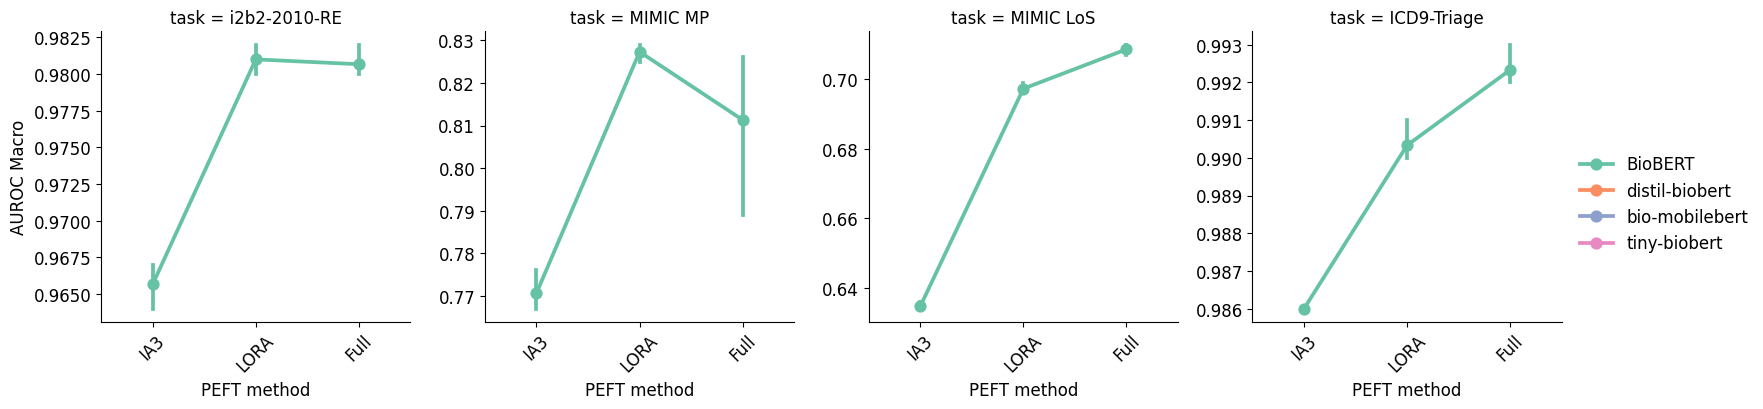

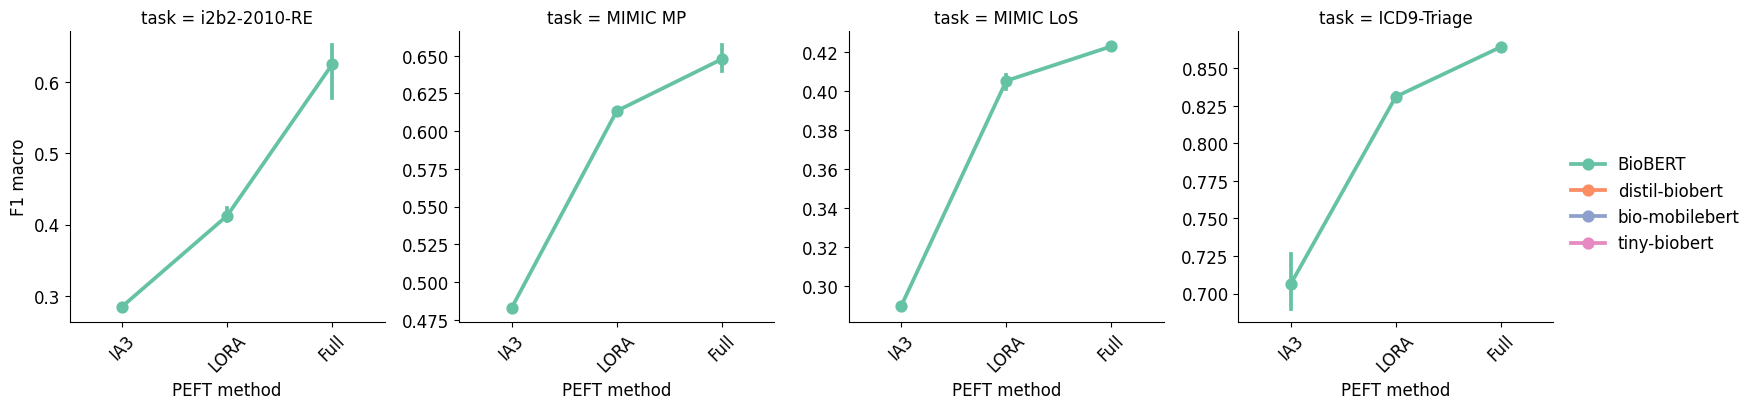

In [11]:


metrics = ['roc_auc_macro', 'f1_macro']

for metric in metrics:
    
    fg = sns.FacetGrid(data=plot_df, col='task', sharey=False, legend_out=True, aspect = 1, height = 4)
    fg.map_dataframe(sns.pointplot, x='PEFT method', y=metric, hue='Model name', 
                    order=PEFT_methods_to_plot, 
                    hue_order = ['BioBERT','distil-biobert','bio-mobilebert', 'tiny-biobert'],
                    palette='Set2')
    fg.add_legend()
    # handles, labels = fg.axes[0,0].get_legend_handles_labels()
    # fg.fig.legend(handles, labels)
    # sns.move_legend(ax, "upper left", bbox_to_anchor=(1.02, 0.4))
    fg.set_xticklabels(rotation = 45)
    # set y label based on metric mapping
    fg.set_ylabels(metric_name_mapping[metric])
    plt.savefig(f'{save_path}/{metric}_PEFT methods.png', bbox_inches='tight')
    plt.show()


### Latex plots for PEFT cls results

In [30]:
# make a latex table from this

cls_paper_results = plot_df.groupby(['Model name', 'PEFT method', 'task', 'few_shot_n',])['roc_auc_macro'].mean().reset_index().pivot_table(index=['Model name', 'PEFT method'],
                                                                                                        columns=['task',],
                                                                                                        values='roc_auc_macro').reset_index()
# print(cls_paper_results.to_latex(
#             caption = "PEFT results for CLS tasks",
#             label = "peft-cls-results",
#             float_format="%.3f",
#             index = False,
#             multirow = False,
#             multicolumn = True,
#             position = "htp",))

In [27]:
np.median([706,703,708]), np.mean([706,703,708]), np.std([706,703,708])

(706.0, 705.6666666666666, 2.0548046676563256)

In [31]:
cls_paper_results

task,Model name,PEFT method,ICD9-Triage,i2b2-2010-RE,mimic-los,mimic-mp
0,BioBERT,Full,NaN,NaN,0.708667,NaN
1,BioBERT,IA3,0.986000,0.965667,0.634667,0.770667
2,BioBERT,LORA,0.990333,0.981000,0.697333,0.827333
3,BioDistilBERT,Full,0.991333,0.977667,0.705667,0.822333
4,BioDistilBERT,IA3,0.987333,0.978000,0.677000,0.796667
5,BioDistilBERT,LORA,0.992333,0.986667,0.702667,0.825333
6,BioMobileBERT,Full,0.992333,0.980000,0.702000,0.815333
7,BioMobileBERT,IA3,0.982333,0.966333,0.639000,0.773000
8,BioMobileBERT,LORA,0.987667,0.980000,0.672000,0.798667
9,TinyBioBERT,Full,0.986333,0.970667,0.684000,0.801333


In [24]:
# F1 micro for I2B2-2010-RE
metric = "f1_micro"
stat = "median"
task = "i2b2-2010-RE"
# plot_df.query("task == @task").groupby(['Model name', 'PEFT method', 'task', 'few_shot_n'])[metric].median().round(3).reset_index().pivot_table(index=['Model name', 'PEFT method'],
#                                                                                                         columns=['task',],
#                                                                                                         values=metric).reset_index()


plot_df.query("task == @task").groupby(['Model name', 'PEFT method', 'task']).agg(f1_micro=(metric, stat), 
                  std=(metric, "std"), 
                  params=("PEFT_params", "first")).round(3).reset_index()


 

,Model name,PEFT method,task,f1_micro,std,params
0,BioBERT,Full,i2b2-2010-RE,0.935,0.004,108310272
1,BioBERT,IA3,i2b2-2010-RE,0.896,0.004,64512
2,BioBERT,LORA,i2b2-2010-RE,0.925,0.001,294912
3,BioDistilBERT,Full,i2b2-2010-RE,0.927,0.003,66953472
4,BioDistilBERT,IA3,i2b2-2010-RE,0.906,0.002,622848
5,BioDistilBERT,LORA,i2b2-2010-RE,0.928,0.003,811776
6,BioMobileBERT,Full,i2b2-2010-RE,0.932,0.003,24581888
7,BioMobileBERT,IA3,i2b2-2010-RE,0.897,0.003,58368
8,BioMobileBERT,LORA,i2b2-2010-RE,0.918,0.002,221184
9,TinyBioBERT,Full,i2b2-2010-RE,0.910,0.005,13874136


In [25]:
# F1 macro for ICD9
metric = "f1_macro"
stat = "median"
task = "ICD9-Triage"

plot_df.query("task == @task").groupby(['Model name', 'PEFT method', 'task']).agg(f1_macro=(metric, stat), 
                  std=(metric, "std"), 
                  params=("PEFT_params", "first")).round(3).reset_index()


,Model name,PEFT method,task,f1_macro,std,params
0,BioBERT,Full,ICD9-Triage,0.864,0.002,108310272
1,BioBERT,IA3,ICD9-Triage,0.703,0.019,64512
2,BioBERT,LORA,ICD9-Triage,0.831,0.002,294912
3,BioDistilBERT,Full,ICD9-Triage,0.862,0.010,66953472
4,BioDistilBERT,IA3,ICD9-Triage,0.792,0.008,622848
5,BioDistilBERT,LORA,ICD9-Triage,0.855,0.005,811776
6,BioMobileBERT,Full,ICD9-Triage,0.851,0.004,24581888
7,BioMobileBERT,IA3,ICD9-Triage,0.730,0.012,58368
8,BioMobileBERT,LORA,ICD9-Triage,0.808,0.004,221184
9,TinyBioBERT,Full,ICD9-Triage,0.726,0.012,13874136


In [79]:
# roc_auc_macro for MIMIC LoS
metric = "roc_auc_macro"
task = "MIMIC LoS"
stat = "median"


plot_df.query("task == @task").groupby(['Model name', 'PEFT method', 'task']).agg(roc_auc_macro=(metric, stat), 
                  std=(metric, "std"), 
                  params=("PEFT_params", "first")).round(3).reset_index()


,Model name,PEFT method,task,roc_auc_macro,std,params
0,BioBERT,Full,MIMIC LoS,0.709,0.002,108310272
1,BioBERT,IA3,MIMIC LoS,0.634,0.001,64512
2,BioBERT,LORA,MIMIC LoS,0.697,0.002,294912
3,BioDistilBERT,Full,MIMIC LoS,0.706,0.003,66953472
4,BioDistilBERT,IA3,MIMIC LoS,0.677,0.000,622848
5,BioDistilBERT,LORA,MIMIC LoS,0.702,0.001,811776
6,BioMobileBERT,Full,MIMIC LoS,0.704,0.004,24581888
7,BioMobileBERT,IA3,MIMIC LoS,0.639,0.001,58368
8,BioMobileBERT,LORA,MIMIC LoS,0.671,0.004,221184
9,TinyBioBERT,Full,MIMIC LoS,0.684,0.001,13874136


In [26]:
# roc_auc_macro for MIMIC MP
metric = "roc_auc_macro"
task = "MIMIC MP"
stat = "median"


plot_df.query("task == @task").groupby(['Model name', 'PEFT method', 'task']).agg(roc_auc_macro=(metric, stat), 
                  std=(metric, "std"), 
                  params=("PEFT_params", "first")).round(3).reset_index()


,Model name,PEFT method,task,roc_auc_macro,std,params
0,BioBERT,Full,MIMIC MP,0.819,0.020,108310272
1,BioBERT,IA3,MIMIC MP,0.769,0.005,64512
2,BioBERT,LORA,MIMIC MP,0.828,0.002,294912
3,BioDistilBERT,Full,MIMIC MP,0.825,0.006,66953472
4,BioDistilBERT,IA3,MIMIC MP,0.797,0.001,622848
5,BioDistilBERT,LORA,MIMIC MP,0.825,0.001,811776
6,BioMobileBERT,Full,MIMIC MP,0.819,0.011,24581888
7,BioMobileBERT,IA3,MIMIC MP,0.774,0.002,58368
8,BioMobileBERT,LORA,MIMIC MP,0.798,0.002,221184
9,TinyBioBERT,Full,MIMIC MP,0.802,0.001,13874136


#### Number of trainable parameters

In [14]:
plot_df.head()

tag,index,Model name,model_name_or_path,task,few_shot_n,peft_method,accuracy,eval/accuracy,eval/f1_macro,eval/f1_micro,...,train/train_runtime,train/train_samples_per_second,train/train_steps_per_second,PEFT_params,PEFT_params_perc,Total_params,full_model_size_GB,full_model_size_MB,peft_full_model_size_GB,peft_full_model_size_MB
59,59,tiny-biobert,nlpie/tiny-biobert,mimic-mp,250,PREFIX_TUNING,0.895642,0.894458,0.472145,0.894458,...,581.825195,291.789001,9.126,24960,0.179895,13874762,0.051688,52.928017,0.051688,52.928017
55,55,tiny-biobert,nlpie/tiny-biobert,mimic-los,250,PREFIX_TUNING,0.378311,0.366431,0.134083,0.366431,...,516.727905,294.362000,9.202,24960,0.179895,13874762,0.051688,52.928017,0.051688,52.928017
51,51,tiny-biobert,nlpie/tiny-biobert,i2b2-2010-RE,250,PREFIX_TUNING,0.854186,0.853116,0.102304,0.853116,...,226.291595,491.755005,15.378,24960,0.179895,13874762,0.051688,52.928017,0.051688,52.928017
47,47,tiny-biobert,nlpie/tiny-biobert,ICD9-Triage,250,PREFIX_TUNING,0.554224,0.544958,0.145761,0.544958,...,186.902496,255.722000,7.999,24960,0.179895,13874762,0.051688,52.928017,0.051688,52.928017
58,58,tiny-biobert,nlpie/tiny-biobert,mimic-mp,250,LORA,0.895642,0.894458,0.472145,0.894458,...,603.383789,281.363007,8.800,39936,0.287832,13874762,0.051688,52.928017,0.051688,52.928017


In [26]:
cls_results_df["model_name_or_path"].unique()

array(['bert-base-uncased', 'emilyalsentzer/Bio_ClinicalBERT',
       'dmis-lab/biobert-v1.1', 'distilbert-base-uncased',
       'meta-llama/Llama-2-7b-hf', 'roberta-base',
       'huawei-noah/TinyBERT_General_4L_312D',
       'nlpie/bio-distilbert-uncased', 'nlpie/bio-mobilebert',
       'nlpie/clinical-distilbert', 'nlpie/clinical-mobilebert',
       'nlpie/distil-biobert', 'google/mobilebert-uncased',
       'nlpie/tiny-biobert', 'nlpie/tiny-clinicalbert'], dtype=object)

In [25]:
cls_results_df["Model name"].unique()

array(['BERT-base', 'Bio-ClinicalBERT', 'BioBERT', 'DistilBERT-base',
       'Llama-2-7b', 'RoBERTa-base', 'TinyBERT_General_4L_312D',
       'bio-distilbert-uncased', 'bio-mobilebert', 'clinical-distilbert',
       'clinical-mobilebert', 'distil-biobert', 'mobilebert-uncased',
       'tiny-biobert', 'tiny-clinicalbert'], dtype=object)

make plot of n trainable params vs peft

In [80]:
PEFT_methods_to_plot = ["IA3", "LORA","Full"]

In [81]:
plot_df = cls_results_df.loc[cls_results_df['few_shot_n'] == 250].copy()
plot_df =  plot_df.loc[plot_df['task'] != 'mednli']
plot_df = plot_df.loc[plot_df['Model name'].isin(
    [
    'BioBERT',
    # 'distil-biobert',
    'BioDistilBERT',
    'BioMobileBERT',
    'TinyBioBERT'])] # , 'distil-biobert', 'bio-mobilebert', 'Bio-ClinicalBERT', 'tiny-biobert'
plot_df = plot_df.loc[plot_df['PEFT method'].isin(PEFT_methods_to_plot)]
plot_df.sort_values(['Model name', 'PEFT method', 'task', 'few_shot_n', 'f1_macro'], 
                            ascending=False, inplace=True)

# do not want to drop duplicates anymore
# plot_df.drop_duplicates(['Model name', 'PEFT method', 'task', 'few_shot_n'], inplace=True)
plot_df['roc_auc_macro'] = plot_df['roc_auc_macro'].apply(lambda x: round(x, 3)).values

In [21]:
plot_df["Model name"].unique()

array(['TinyBioBERT', 'BioMobileBERT'], dtype=object)

In [34]:
# check data with BioBERT Model name
plot_df.loc[plot_df["Model name"] == "TinyBioBERT"][["Model name", "PEFT method", "task", "few_shot_n", "random_seed", "roc_auc_macro", "f1_macro","eval/roc_auc_macro"]]

tag,Model name,PEFT method,task,few_shot_n,random_seed,roc_auc_macro,f1_macro,eval/roc_auc_macro
133,TinyBioBERT,LORA,mimic-mp,250.0,34.0,0.768,0.478412,0.754007
132,TinyBioBERT,LORA,mimic-mp,250.0,12.0,0.762,0.474473,0.748749
134,TinyBioBERT,LORA,mimic-mp,250.0,56.0,0.764,0.474442,0.756703
123,TinyBioBERT,LORA,mimic-los,250.0,12.0,0.650,0.329460,0.640242
124,TinyBioBERT,LORA,mimic-los,250.0,34.0,0.649,0.320600,0.641754
125,TinyBioBERT,LORA,mimic-los,250.0,56.0,0.639,0.292383,0.632610
115,TinyBioBERT,LORA,i2b2-2010-RE,250.0,34.0,0.970,0.310469,0.971652
116,TinyBioBERT,LORA,i2b2-2010-RE,250.0,56.0,0.954,0.303925,0.952270
114,TinyBioBERT,LORA,i2b2-2010-RE,250.0,12.0,0.958,0.289480,0.960944
105,TinyBioBERT,LORA,ICD9-Triage,250.0,12.0,0.978,0.610833,0.973860


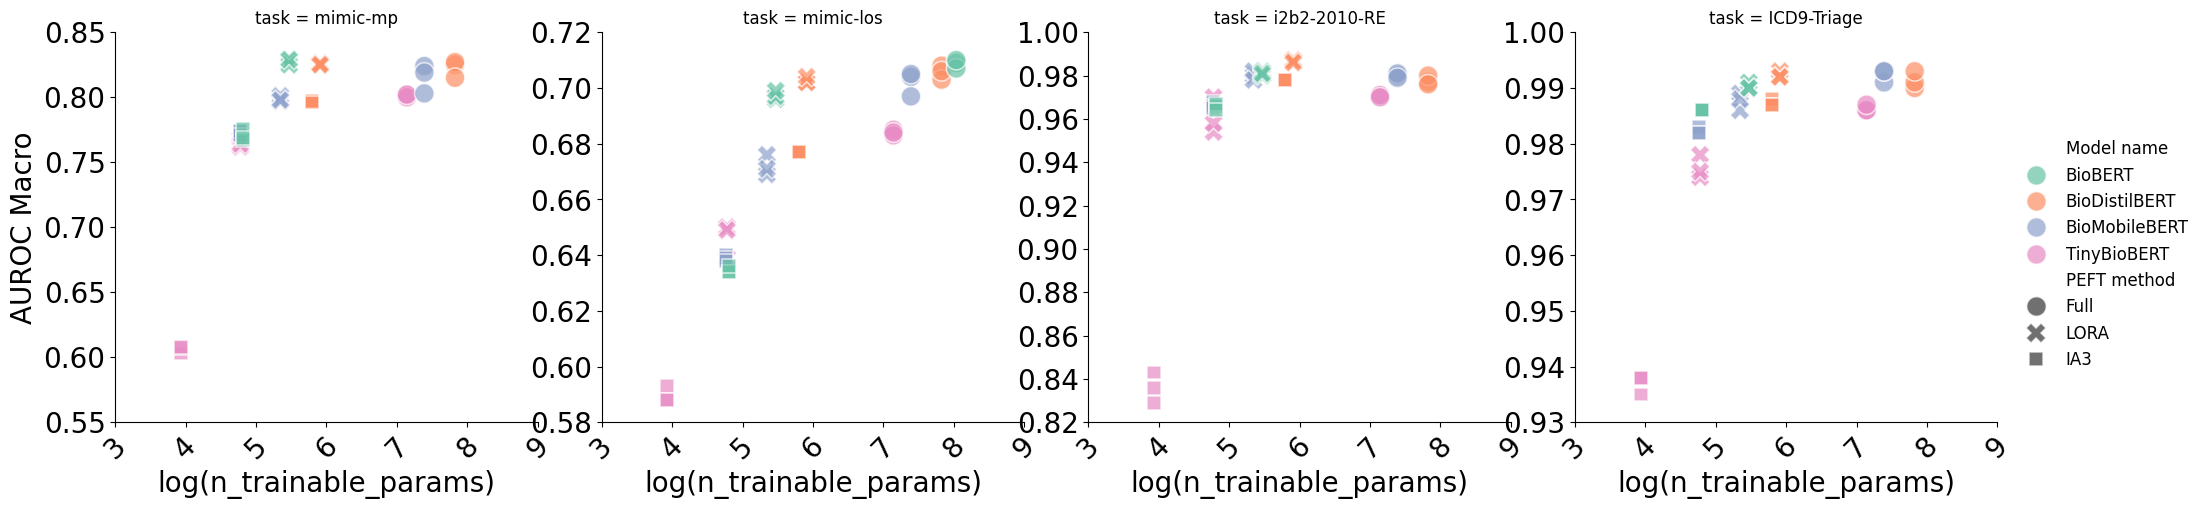

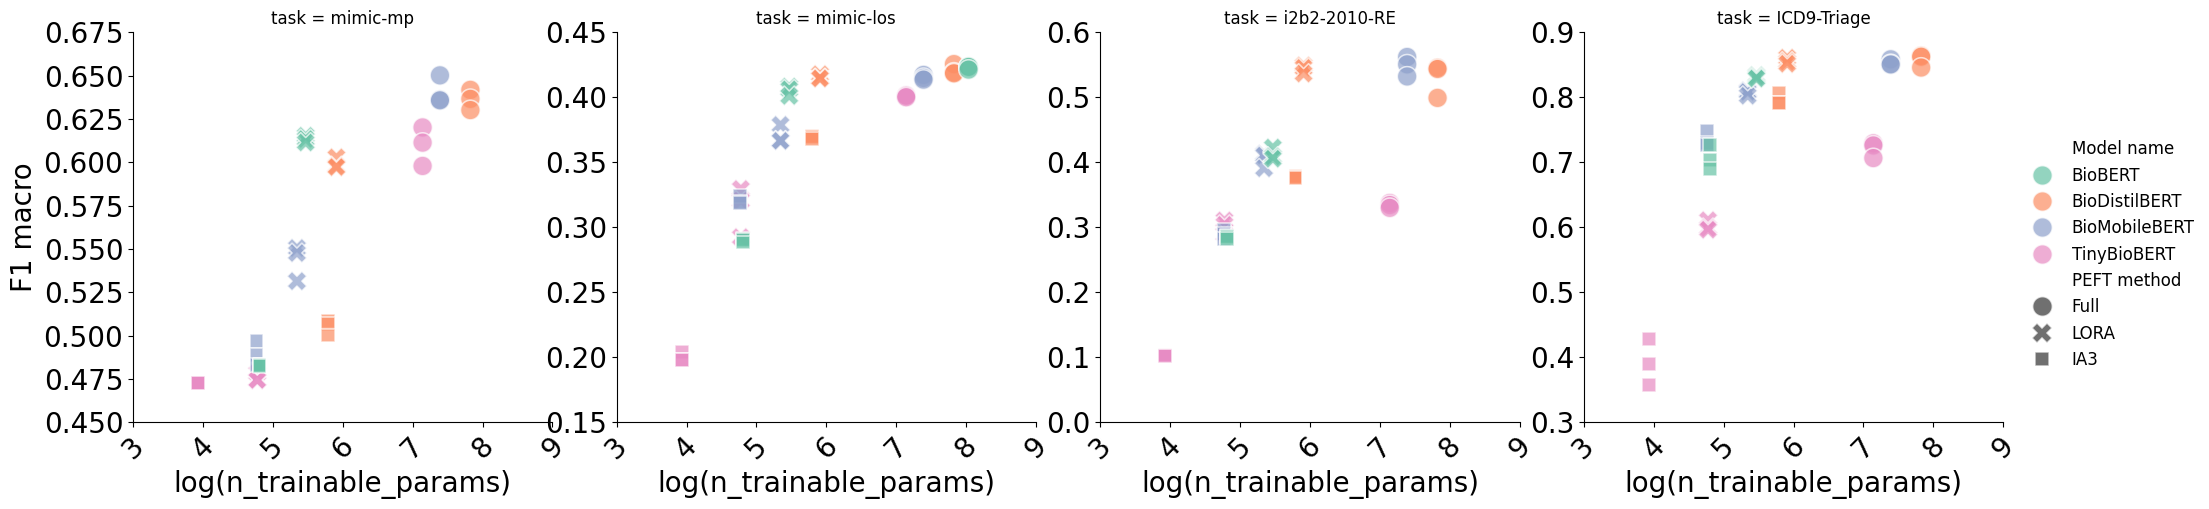

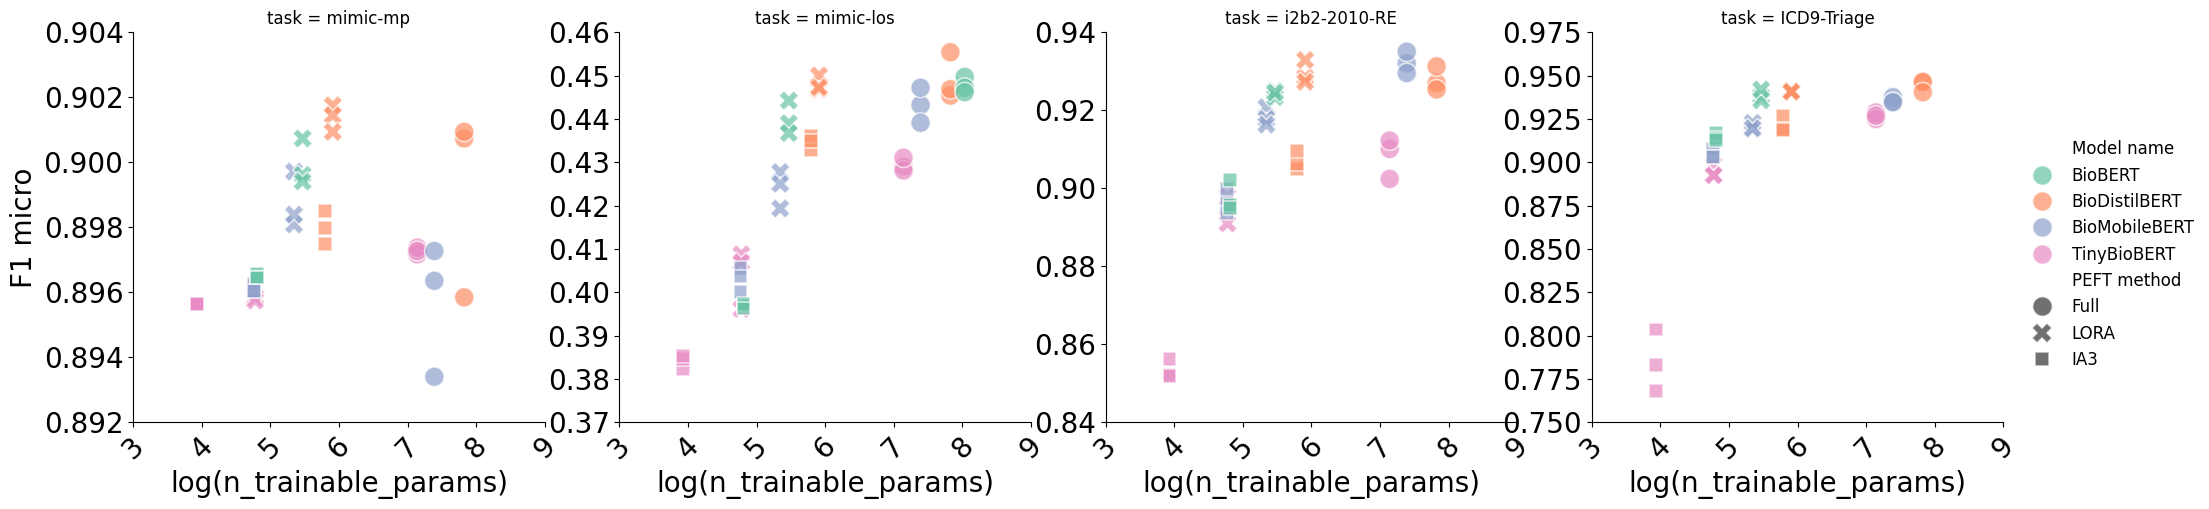

In [35]:
metrics = ['roc_auc_macro', 'f1_macro', 'f1_micro']
plot_df['log(n_trainable_params)'] = np.log10(plot_df['PEFT_params'])
# have a nicer metric name mapping


for metric in metrics:
    # change font size
    
    fg = sns.FacetGrid(data=plot_df, col='task', sharey=False, 
                       sharex=True, legend_out=True, aspect=1, height=5)
    fg.map_dataframe(sns.scatterplot,
                     x='log(n_trainable_params)',
                     y=metric, style='PEFT method', 
                     hue='Model name',
                     hue_order = ['BioBERT',
                                  # 'distil-biobert',
                                  'BioDistilBERT',
                                  'BioMobileBERT',
                                  'TinyBioBERT'],
                       palette='Set2', s=200, alpha=0.7,
                     style_order=PEFT_methods_to_plot[::-1],
                     )
                     
    # fg.map_dataframe(sns.lineplot, x='log(n_trainable_params)', y=metric, style='PEFT method', 
    #                  hue='Model name', palette='viridis', alpha=0.7,
    #                  style_order=['Full', 'PREFIX_TUNING', 'LORA', 'PROMPT_TUNING'])
    fg.add_legend()
    fg.set_xticklabels(rotation = 45, fontsize =20)
    fg.set_yticklabels(fontsize =20)
    fg.set_xlabels('log(n_trainable_params)', fontsize =20)
    fg.set_ylabels(metric_name_mapping[metric], fontsize =20)
    # set subplot titles
    # fg.set_titles(col_template="{col_name}", row_template="{row_name}", fontsize =30)


    # plt.savefig(f'{save_path}/{metric}_peft_methods_trainable_params_fg.png', bbox_inches='tight')
    plt.show()


In [49]:
task = "MIMIC MP"
# task_df = plot_df.query("task == @task").groupby(['Model name', 'PEFT method', 'task'])[metric,"PEFT_params"].median().reset_index()
# task_df = plot_df.query("task == @task").groupby(['Model name', 'PEFT method', 'task']).agg({"roc_auc_macro": ["median","std"],
                                                                                             
#                                                                                              "PEFT_params": "first"}).reset_index()


task_df = plot_df.query("task == @task").groupby(['Model name', 'PEFT method', 'task']).agg(roc_auc_macro=("roc_auc_macro", "median"), 
                  std=("roc_auc_macro", "std"), 
                  params=("PEFT_params", "first")).reset_index()

In [50]:
task_df


,Model name,PEFT method,task,roc_auc_macro,std,params
0,BioBERT,IA3,mimic-mp,0.769,0.004726,64512
1,BioBERT,LORA,mimic-mp,0.828,0.002082,294912
2,BioDistilBERT,Full,mimic-mp,0.825,0.006429,66953472
3,BioDistilBERT,IA3,mimic-mp,0.797,0.000577,622848
4,BioDistilBERT,LORA,mimic-mp,0.825,0.000577,811776
5,BioMobileBERT,Full,mimic-mp,0.819,0.010970,24581888
6,BioMobileBERT,IA3,mimic-mp,0.774,0.001732,58368
7,BioMobileBERT,LORA,mimic-mp,0.798,0.002082,221184
8,TinyBioBERT,Full,mimic-mp,0.802,0.001155,13874136
9,TinyBioBERT,IA3,mimic-mp,0.607,0.002646,8544


In [45]:
task_df.columns

MultiIndex([(   'Model name',       ''),
            (  'PEFT method',       ''),
            (         'task',       ''),
            ('roc_auc_macro', 'median'),
            ('roc_auc_macro',    'std'),
            (  'PEFT_params',  'first')],
           names=['tag', None])

In [68]:
pivot_df = plot_df.pivot_table(index=['Model name', 'PEFT method', 'task', 'few_shot_n'], 
                               values=metric,
                               aggfunc=[np.median, np.mean, np.std])

pivot_df.columns = ['_'.join(col) for col in pivot_df.columns.values] 
# Flatten MultiIndex columns names

pivot_df = pivot_df.reset_index()

In [69]:
pivot_df

,Model name,PEFT method,task,few_shot_n,median_roc_auc_macro,mean_roc_auc_macro,std_roc_auc_macro
0,BioMobileBERT,IA3,ICD9-Triage,16.0,0.5000,0.506333,0.033946
1,BioMobileBERT,IA3,i2b2-2010-RE,16.0,0.4995,0.499500,0.002121
2,BioMobileBERT,IA3,mimic-los,16.0,0.5000,0.495667,0.009292
3,BioMobileBERT,IA3,mimic-mp,16.0,0.5000,0.500000,0.000000
4,BioMobileBERT,LORA,ICD9-Triage,16.0,0.5080,0.509333,0.010066
5,BioMobileBERT,LORA,i2b2-2010-RE,16.0,0.5095,0.509500,0.013435
6,BioMobileBERT,LORA,mimic-los,16.0,0.5000,0.495000,0.013229
7,BioMobileBERT,LORA,mimic-mp,16.0,0.5000,0.500000,0.000000
8,TinyBioBERT,Full,ICD9-Triage,16.0,0.7170,0.717000,0.004243
9,TinyBioBERT,Full,i2b2-2010-RE,16.0,0.5600,0.560000,0.011314


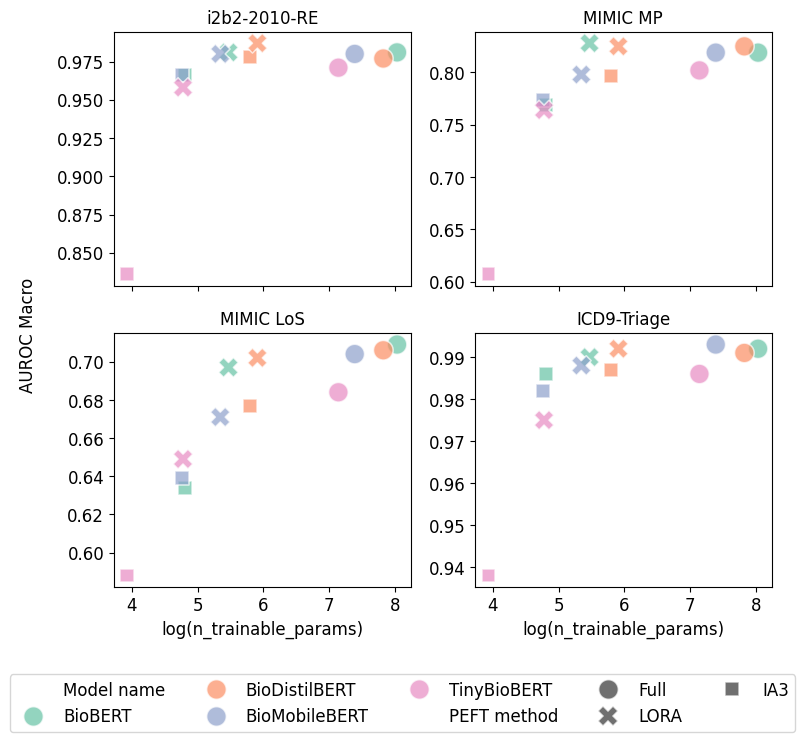

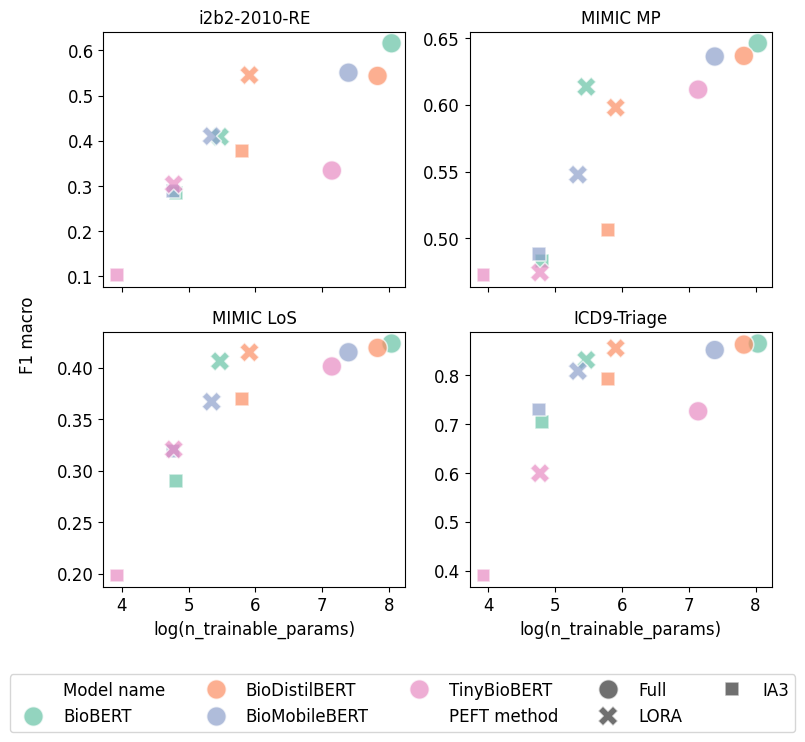

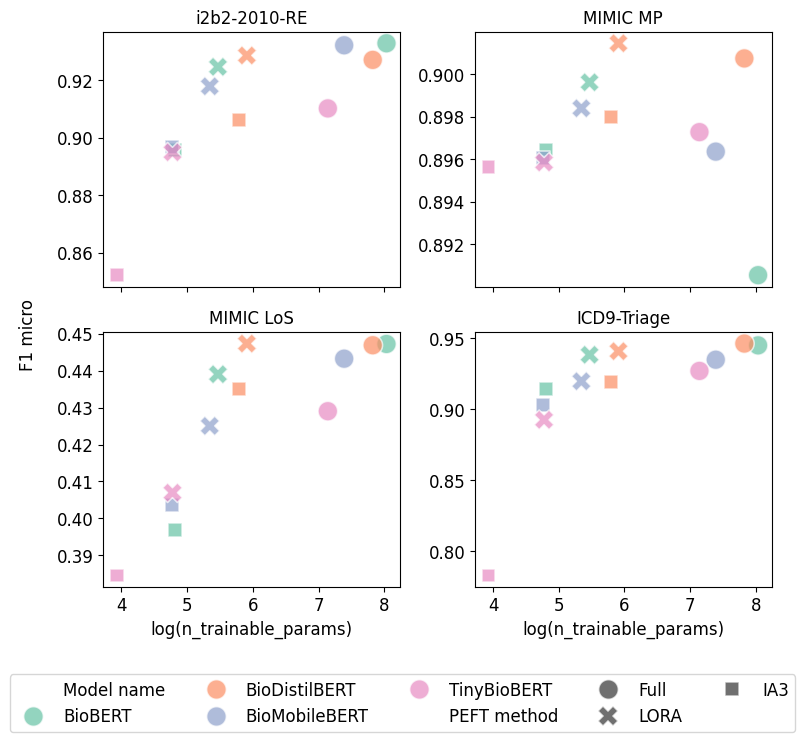

In [82]:
# for multiple runs - need to aggregate over random seed
metrics = ['roc_auc_macro', 'f1_macro', 'f1_micro']
plot_df['log(n_trainable_params)'] = np.log10(plot_df['PEFT_params'])
for metric in metrics:
    fig, ax = plt.subplots(2,2, figsize=(8,7), sharex=True, sharey=False)
    
    # loop over each task and plot on a different axis
    for i, task in enumerate(plot_df['task'].unique()):
        # subset to only the task we want and also find the median of the metric across each of the random seeds
        task_df = plot_df.query("task == @task").groupby(['Model name', 'PEFT method', 'task']).agg({metric: "median",
                                                                                                     "PEFT_params": "first",
                                                                                                     "log(n_trainable_params)":"first"}).reset_index()
        # task_df = plot_df.query("task == @task").groupby(['Model name', 'PEFT method', 'task']).agg(metric=(metric, "median"), 
        #           std=(metric, "std"), 
        #           log_params=("log(n_trainable_params)", "first")).reset_index()
        # plot on the correct axis
        
        sns.scatterplot(data=task_df,
                        x='log(n_trainable_params)',
                        y=metric, style='PEFT method', 
                        hue='Model name',
                        hue_order = HUE_ORDER[:-1] , # we don't need llama which is last entry
                          palette= PALETTE,
                          s=200, 
                          alpha=0.7,
                        style_order=PEFT_methods_to_plot[::-1],
                        ax=ax.flatten()[i])
        ax.flatten()[i].set_title(task)
        ax.flatten()[i].set_xlabel('log(n_trainable_params)')
        # ax.flatten()[i].set_ylabel(metric_name_mapping[metric])
        ax.flatten()[i].set_ylabel('')
        # ax.flatten()[i].set_ylabel(metric_name_mapping[metric]) if i == 0 else ax.flatten()[i].set_ylabel('')
        
        # get legend handles
        handles, labels = ax.flatten()[i].get_legend_handles_labels()
        
        # remove legend
        ax.flatten()[i].get_legend().remove()
        # ax.flatten()[i].set_xticklabels(rotation = 45)
        # ax.flatten()[i].set_yticklabels(rotation = 45)
      # set legend
    # plt.ylabel(metric_name_mapping[metric])
    fig.add_subplot(111, frameon=False, )
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    # plt.ylabel(metric_name_mapping[metric], x=-0.9, ha='left')
    fig.text(x=0.02, y=0.5, s=metric_name_mapping[metric], 
         ha='left', va='center', rotation=90)
    fig.legend(handles, labels, loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.08))
    plt.tight_layout()
    plt.savefig(f'{save_path}/{metric}_peft_methods_trainable_params.png',
                bbox_inches='tight')

In [38]:

plot_df = fs_cls_results_df.loc[fs_cls_results_df['Model name'] != 'RoBERTa-base']
# convert few_shot_n to string
plot_df['few_shot_n'] = plot_df['few_shot_n'].astype(str)
plot_df.rename(columns={'few_shot_n': 'Num training samples', 
                        'roc_auc_macro':metric_name_mapping['roc_auc_macro'],
                        'peft_method': 'PEFT method'}, inplace=True)
metrics = ['AUROC Macro']

for metric in metrics:
    fig, ax = plt.subplots(figsize=(8, 5))
    sns.pointplot(data=plot_df.loc[plot_df['PEFT method'] == 'LORA'], 
                  x='Num training samples', y=metric, 
                  hue='Model name', hue_order = ['BioBERT',
                                  # 'distil-biobert',
                                  'BioDistilBERT',
                                  'BioMobileBERT',
                                  'TinyBioBERT',
                                  'Llama-2-7b',
                                #   'RoBERTa-base',
                                  ],
                  alpha=0.7, linewidth=1.5, markersize=4, palette=PALETTE, legend=False)
    sns.scatterplot(data=plot_df, 
                  x='Num training samples', y=metric, 
                  hue='Model name',
                  hue_order = HUE_ORDER,
                  style='PEFT method', style_order=[ 'LORA', 'Full'],
                  alpha=0.7, markers=['X', 'o'], s=60, palette=PALETTE)
    
    plt.legend(bbox_to_anchor=(1.05, 0.8), loc=2, borderaxespad=0.)
    plt.tight_layout()
    plt.savefig(f'{save_path}/fewshot_sensitivity.png', bbox_inches='tight', dpi=300)
    plt.show()

KeyError: 'PEFT method'

In [17]:
# plot_df

In [39]:
plot_df["log(n_trainable_params)"]

112    4.777456
108    4.777456
105    4.777456
101    4.777456
111    3.931661
107    3.931661
104    3.931661
100    3.931661
110    7.142206
106    7.142206
103    7.142206
99     7.142206
55     5.344754
52     5.344754
49     5.344754
46     5.344754
54     4.766175
51     4.766175
48     4.766175
45     4.766175
53     7.390615
50     7.390615
47     7.390615
44     7.390615
43     5.909436
40     5.909436
37     5.909436
34     5.909436
42     5.794382
39     5.794382
36     5.794382
33     5.794382
41     7.825773
38     7.825773
35     7.825773
32     7.825773
22     5.469692
18     5.469692
14     5.469692
10     5.469692
21     4.809641
17     4.809641
13     4.809641
9      4.809641
20     8.034670
16     8.034670
12     8.034670
8      8.034670
Name: log(n_trainable_params), dtype: float64

In [36]:
HUE_ORDER[:-1]

['BioBERT', 'BioDistilBERT', 'BioMobileBERT', 'TinyBioBERT']

In [104]:
# plt.rcParams

the style order may be weird

In [44]:
# Plot the lines on two facets
# sns.relplot(
#     data=dots,
#     x="time", y="firing_rate",
#     hue="coherence", size="choice", col="align",
#     kind="line", size_order=["T1", "T2"], palette=palette,
#     height=5, aspect=.75, facet_kws=dict(sharex=False),
# )

In [134]:
plot_df.query("`Model name` == 'Bio-ClinicalBERT' & `task` == 'MIMIC LoS'")

tag,index,Model name,model_name_or_path,task,few_shot_n,peft_method,accuracy,f1_macro,f1_micro,f1_weighted,precision,recall,roc_auc_macro,PEFT_params,PEFT_params_perc,Total_params,log(n_trainable_params)
33,33,Bio-ClinicalBERT,emilyalsentzer/Bio_ClinicalBERT,mimic-los,250.0,Full,0.443862,0.422290,0.443862,0.438665,0.461359,0.415032,0.705,229376,0.211774,108311810,5.360548
34,34,Bio-ClinicalBERT,emilyalsentzer/Bio_ClinicalBERT,mimic-los,250.0,PREFIX_TUNING,0.410840,0.368367,0.410840,0.393162,0.470111,0.362654,0.672,368640,0.340351,108311810,5.566602
35,35,Bio-ClinicalBERT,emilyalsentzer/Bio_ClinicalBERT,mimic-los,250.0,PROMPT_TUNING,0.377591,0.268441,0.377591,0.329927,0.442458,0.289024,0.608,7680,0.007091,108311810,3.885361


### Look at training time etc

In [33]:
cls_results_df

tag,index,Model name,model_name_or_path,task,few_shot_n,peft_method,accuracy,f1_macro,f1_micro,f1_weighted,...,recall,roc_auc_macro,train/total_flos,train/train_loss,train/train_runtime,train/train_samples_per_second,train/train_steps_per_second,PEFT_params,PEFT_params_perc,Total_params
0,0,Bio-ClinicalBERT,emilyalsentzer/Bio_ClinicalBERT,ICD9-Triage,250.0,Full,0.948940,0.879353,0.948940,0.949106,...,0.885844,0.993043,1.178996e+16,0.182213,1151.783691,41.497002,1.298,108310272.0,99.998580,108311810.0
1,1,Bio-ClinicalBERT,emilyalsentzer/Bio_ClinicalBERT,ICD9-Triage,250.0,IA3,0.904303,0.661928,0.904303,0.889988,...,0.656008,0.982280,1.179958e+16,0.508661,1016.591003,47.014999,1.471,64512.0,0.059561,108311810.0
2,2,Bio-ClinicalBERT,emilyalsentzer/Bio_ClinicalBERT,ICD9-Triage,250.0,LORA,0.948298,0.876338,0.948298,0.948010,...,0.874291,0.991595,1.183130e+16,0.281233,973.616028,49.090000,1.536,294912.0,0.272281,108311810.0
3,3,Bio-ClinicalBERT,emilyalsentzer/Bio_ClinicalBERT,ICD9-Triage,250.0,PREFIX_TUNING,0.758831,0.377884,0.758831,0.702254,...,0.370109,0.904001,1.179070e+16,0.945242,911.373108,52.443001,1.640,184320.0,0.170175,108311810.0
4,4,Bio-ClinicalBERT,emilyalsentzer/Bio_ClinicalBERT,ICD9-Triage,250.0,PROMPT_TUNING,0.724470,0.309875,0.724470,0.646503,...,0.328047,0.892517,1.179070e+16,1.019554,930.424622,51.368999,1.607,7680.0,0.007091,108311810.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328,328,tiny-biobert,nlpie/tiny-biobert,mimic-mp,250.0,IA3,0.894458,0.472145,0.894458,0.844627,...,0.500000,0.610758,2.286669e+15,0.338250,628.517273,270.112000,8.448,8544.0,0.061579,13874762.0
329,329,tiny-biobert,nlpie/tiny-biobert,mimic-mp,250.0,LORA,0.895273,0.483743,0.895273,0.847377,...,0.505564,0.758608,2.302018e+15,0.310653,592.793823,286.390015,8.958,39936.0,0.287832,13874762.0
330,330,tiny-biobert,nlpie/tiny-biobert,mimic-mp,250.0,PREFIX_TUNING,0.894662,0.484691,0.894662,0.846581,...,0.505162,0.737646,2.282492e+15,0.317243,778.098083,218.186005,6.824,24960.0,0.179895,13874762.0
331,331,tiny-biobert,nlpie/tiny-biobert,mimic-mp,250.0,PROMPT_TUNING,0.894458,0.472145,0.894458,0.844627,...,0.500000,0.608066,2.282492e+15,0.335948,878.742371,193.197006,6.043,3120.0,0.022487,13874762.0


In [13]:
time_grouped_df = cls_results_df.groupby(["Model name", 
                                          "PEFT method",
                                          "task",
                                          "few_shot_n"])[["train/train_runtime","train/total_flos", "f1_macro"]].mean().reset_index()

In [32]:
time_grouped_df.query("`Model name` == 'tiny-biobert' & task == 'MIMIC LoS'")

tag,Model name,peft_method,task,few_shot_n,train/train_runtime,train/total_flos,f1_macro
311,tiny-biobert,Full,mimic-los,250.0,672.981689,2.044993e+15,0.394912
316,tiny-biobert,IA3,mimic-los,250.0,567.254883,2.049284e+15,0.200045
326,tiny-biobert,LORA,mimic-los,16.0,50.236301,4.340235e+12,0.082366
327,tiny-biobert,LORA,mimic-los,32.0,51.597698,8.680469e+12,0.117975
328,tiny-biobert,LORA,mimic-los,64.0,52.520100,1.736094e+13,0.185895
329,tiny-biobert,LORA,mimic-los,128.0,57.049000,3.472188e+13,0.229567
330,tiny-biobert,LORA,mimic-los,200.0,61.754700,5.425293e+13,0.239175
331,tiny-biobert,LORA,mimic-los,250.0,529.658508,2.063036e+15,0.332569
341,tiny-biobert,PREFIX_TUNING,mimic-los,250.0,696.214905,2.045541e+15,0.303347
346,tiny-biobert,PROMPT_TUNING,mimic-los,250.0,784.993591,2.045541e+15,0.200091


In [37]:
time_grouped_df.query("PEFT method == 'LORA' and few_shot_n == 250")

tag,Model name,peft_method,task,few_shot_n,train/train_runtime,train/total_flos,f1_macro
10,Bio-ClinicalBERT,LORA,ICD9-Triage,250.0,973.616028,1.183130e+16,0.876338
16,Bio-ClinicalBERT,LORA,i2b2-2010-RE,250.0,1168.505249,1.361401e+16,0.406977
17,Bio-ClinicalBERT,LORA,mednli,250.0,217.321594,3.172938e+15,0.266870
21,Bio-ClinicalBERT,LORA,mimic-los,250.0,2841.795898,3.765043e+16,0.400606
23,Bio-ClinicalBERT,LORA,mimic-mp,250.0,3164.370850,4.202153e+16,0.636708
44,BioLinkBERT-base,LORA,i2b2-2010-RE,250.0,1608.011230,1.207389e+16,0.468533
45,BioLinkBERT-base,LORA,mednli,250.0,281.238190,2.614242e+15,0.269277
46,BioLinkBERT-base,LORA,mimic-los,250.0,2780.993896,3.765043e+16,0.411788
47,BioLinkBERT-base,LORA,mimic-mp,250.0,3105.887695,4.202153e+16,0.651606
68,LinkBERT-base,LORA,i2b2-2010-RE,250.0,1858.796143,1.368241e+16,0.369720


In [35]:
# PEFT_methods_to_plot = ['PROMPT_TUNING', 'PREFIX_TUNING', 'LORA', 'IA3', 'Full']
PEFT_methods_to_plot = ['IA3', 'LORA', 'Full']
plot_df = cls_results_df.loc[cls_results_df['few_shot_n'] > 200].copy()
plot_df = plot_df.loc[plot_df['Model name'].isin(
    ['distil-biobert', 'bio-mobilebert', 'tiny-biobert', 'BioBERT'])] # , 'distil-biobert', 'bio-mobilebert', 'Bio-ClinicalBERT', 'tiny-biobert'
# subset to only the peft methods we want to plot
plot_df = plot_df.loc[plot_df['PEFT method'].isin(PEFT_methods_to_plot)]

plot_df.sort_values(['Model name', 'PEFT method', 'task', 'few_shot_n', 'roc_auc_macro'], 
                            ascending=False, inplace=True)
plot_df.drop_duplicates(['Model name', 'PEFT method', 'task', 'few_shot_n'], inplace=True)
plot_df['roc_auc_macro'] = plot_df['roc_auc_macro'].apply(lambda x: round(x, 3)).values

In [40]:
cls_results_df["Model name"].unique()

array(['Bio-ClinicalBERT', 'BioBERT', 'BioLinkBERT-base', 'LinkBERT-base',
       'Mimic-RoBERTa-DeCLUTR', 'RoBERTa-base', 'RoBERTa-mimic',
       'RoBERTa-mimic-note-two-epoch', 'bio-mobilebert', 'distil-biobert',
       'roberta-base-mimic-note-custom_pretraining_contrastive_max_epoch_2_weighted',
       'tiny-biobert'], dtype=object)

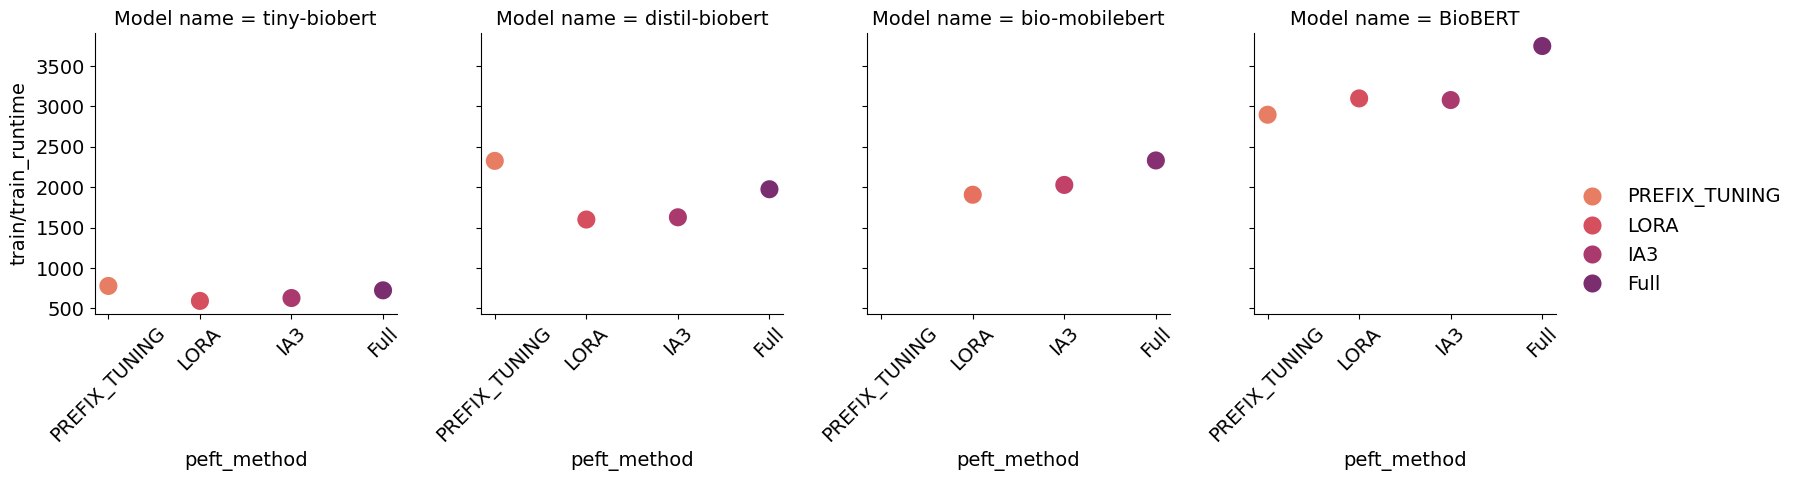

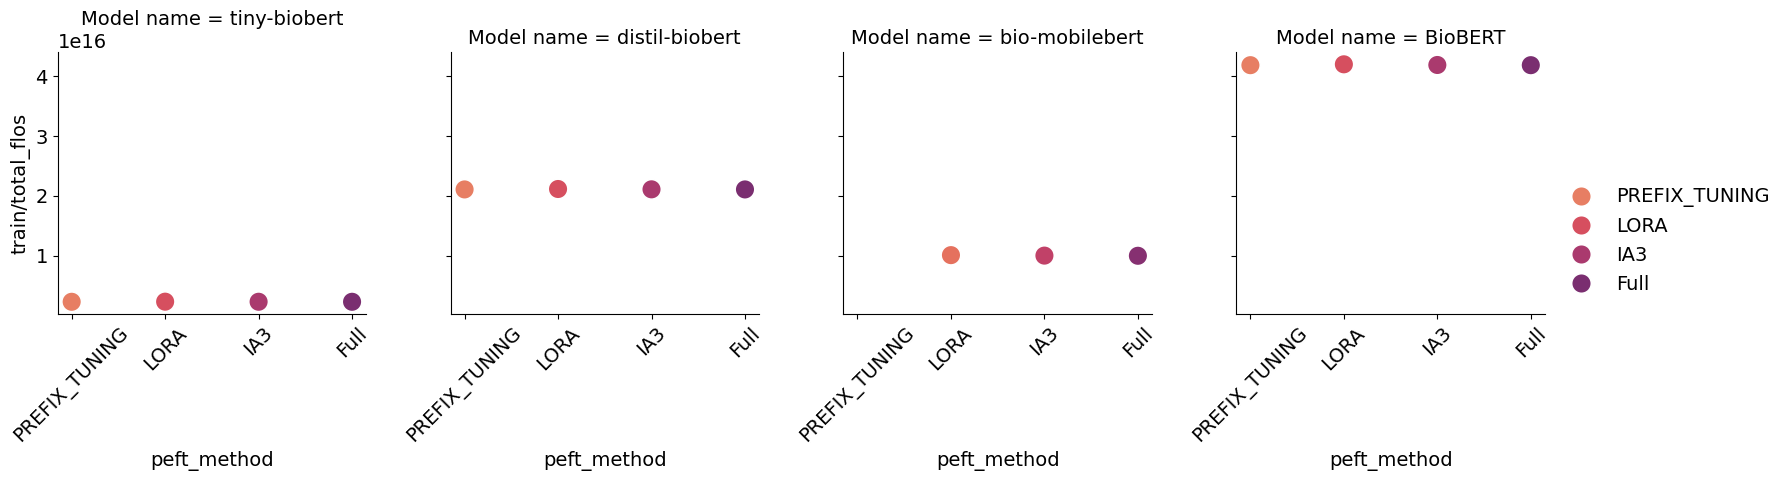

In [71]:
task = "MIMIC MP"

metrics = ["train/train_runtime","train/total_flos"]

for metric in metrics:
    
    fg = sns.FacetGrid(data=plot_df.query("task == @task"), col='Model name', sharey=True, legend_out=True, aspect = 1, height = 4)
    fg.map_dataframe(sns.scatterplot, x='PEFT method', y=metric, hue='PEFT method', 
                    # order=PEFT_methods_to_plot, 
                    palette='flare',
                    s = 200)
    fg.add_legend()
    # handles, labels = fg.axes[0,0].get_legend_handles_labels()
    # fg.fig.legend(handles, labels)
    # sns.move_legend(ax, "upper left", bbox_to_anchor=(1.02, 0.4))
    fg.set_xticklabels(rotation = 45)
    plt.show()

In [40]:
# how many nas in train_runtime
plot_df["train/total_flos"].isna().sum()

0

In [39]:
plot_df["train/train_runtime"]

351     778.098083
340     696.214905
329      68.249603
323     265.755798
312     262.315308
          ...     
57     3748.081299
55      388.900787
49      280.701111
44     1384.306396
39     1138.175049
Name: train/train_runtime, Length: 75, dtype: float64

In [76]:
plot_df.query("`Model name` == 'bio-mobilebert' & `task` == 'MIMIC MP'")

tag,index,Model name,model_name_or_path,task,few_shot_n,peft_method,accuracy,f1_macro,f1_micro,f1_weighted,...,roc_auc_macro,train/total_flos,train/train_loss,train/train_runtime,train/train_samples_per_second,train/train_steps_per_second,PEFT_params,PEFT_params_perc,Total_params,log(train/train_runtime)
259,259,bio-mobilebert,nlpie/bio-mobilebert,mimic-mp,250.0,LORA,0.897922,0.594404,NaN,0.870632,...,0.805,1.008930e+16,80.762421,1907.081055,89.021004,2.784,221184.0,0.899747,24582914.0,3.280369
258,258,bio-mobilebert,nlpie/bio-mobilebert,mimic-mp,250.0,IA3,0.894662,0.506085,0.894662,0.851521,...,0.760,1.000969e+16,55.185074,2028.612427,83.688004,2.618,58368.0,0.237433,24582914.0,3.307199
257,257,bio-mobilebert,nlpie/bio-mobilebert,mimic-mp,250.0,Full,0.901793,0.650529,0.901793,0.880001,...,0.824,9.980649e+15,59.196644,2331.474121,73.668999,2.304,24581888.0,99.995826,24582914.0,3.367631


ValueError: s must be a scalar, or float array-like with the same size as x and y

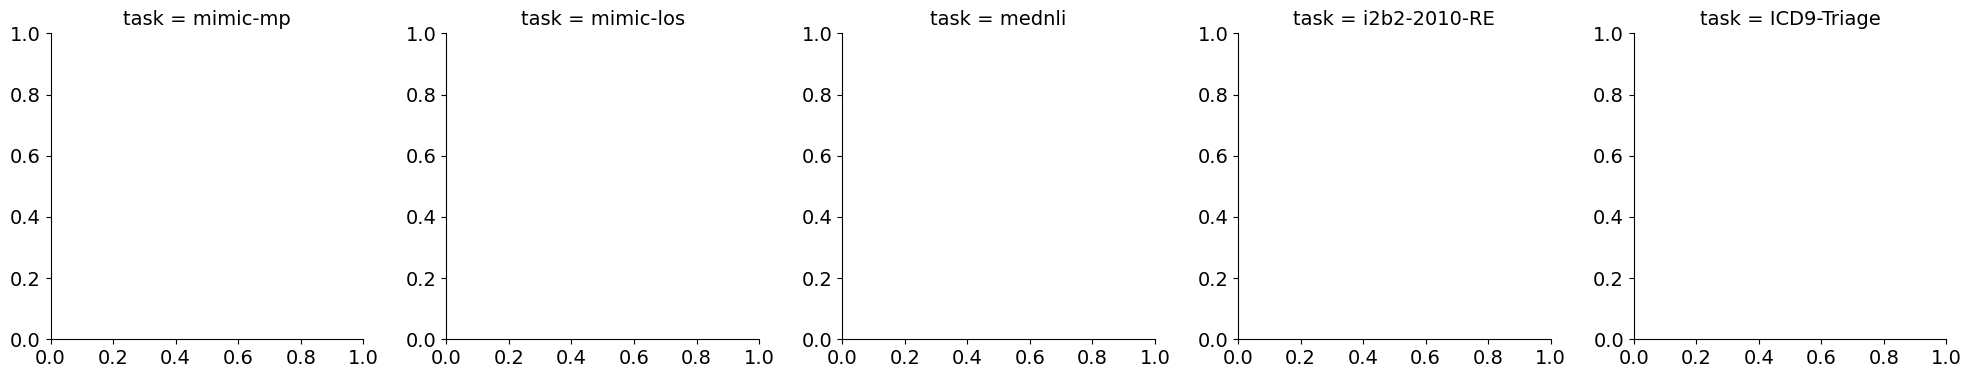

In [51]:
task = "MIMIC MP"
PEFT_methods_to_plot = ["IA3", "LORA","Full"]
metrics = ["f1_macro", "roc_auc_macro"]
time_metric = "train/train_runtime"
plot_df['log(n_trainable_params)'] = np.log2(plot_df['PEFT_params'])
for metric in metrics:
    
    fg = sns.FacetGrid(data=plot_df, col='task', sharey=False, sharex=False, legend_out=True, aspect = 1, height = 4)
    fg.map_dataframe(sns.scatterplot, x=time_metric, y=metric ,
                    hue='Model name',
                    palette='viridis',
                    style = "PEFT method",
                    # size = 'log(n_trainable_params)',
                    # size = 200,
                    s = plot_df["log(n_trainable_params)"],
                    )
    
    # remove x ticks
    fg.set(xticks=[])
    
    # fg.map_dataframe(sns.lineplot,
    #                  x = metric, 
    #                  y = cls_metric,
                      
    #                 palette='flare')
    fg.add_legend()
    # handles, labels = fg.axes[0,0].get_legend_handles_labels()
    # fg.fig.legend(handles, labels)
    # sns.move_legend(ax, "upper left", bbox_to_anchor=(1.02, 0.4))
    fg.set_xticklabels(rotation = 45)
    plt.show()

In [52]:
task

'mimic-mp'

In [97]:
# mean std scaling of peft params
# plot_df['norm_PEFT_params'] = ((plot_df['PEFT_params'] - plot_df['PEFT_params'].mean()) / plot_df['PEFT_params'].std())*10
plot_df['norm_PEFT_params'] = (plot_df['PEFT_params'])/1000

(array([41.,  5.,  5.,  0.,  0.,  0.,  5.,  0.,  0.,  5.]),
 array([8.54400000e+00, 1.08387168e+04, 2.16688896e+04, 3.24990624e+04,
        4.33292352e+04, 5.41594080e+04, 6.49895808e+04, 7.58197536e+04,
        8.66499264e+04, 9.74800992e+04, 1.08310272e+05]),
 <BarContainer object of 10 artists>)

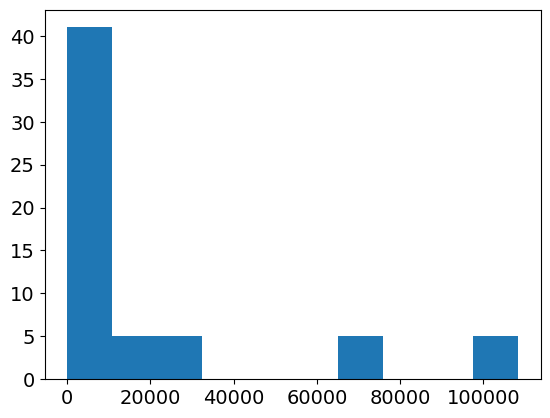

In [98]:
plt.hist(plot_df['norm_PEFT_params'])

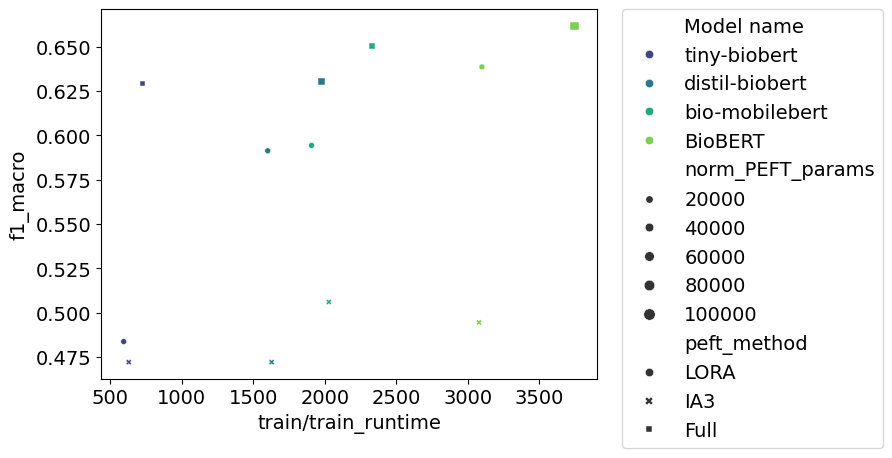

In [99]:
# single task plot
pdf = plot_df.query("task == @task").reset_index(drop=True)
sns.scatterplot(x="train/train_runtime", y=metric ,
                    hue='Model name',
                    palette='viridis',
                    style = "PEFT method",
                    size = pdf["norm_PEFT_params"],
                    data = pdf)

# move legend outside 
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
                    

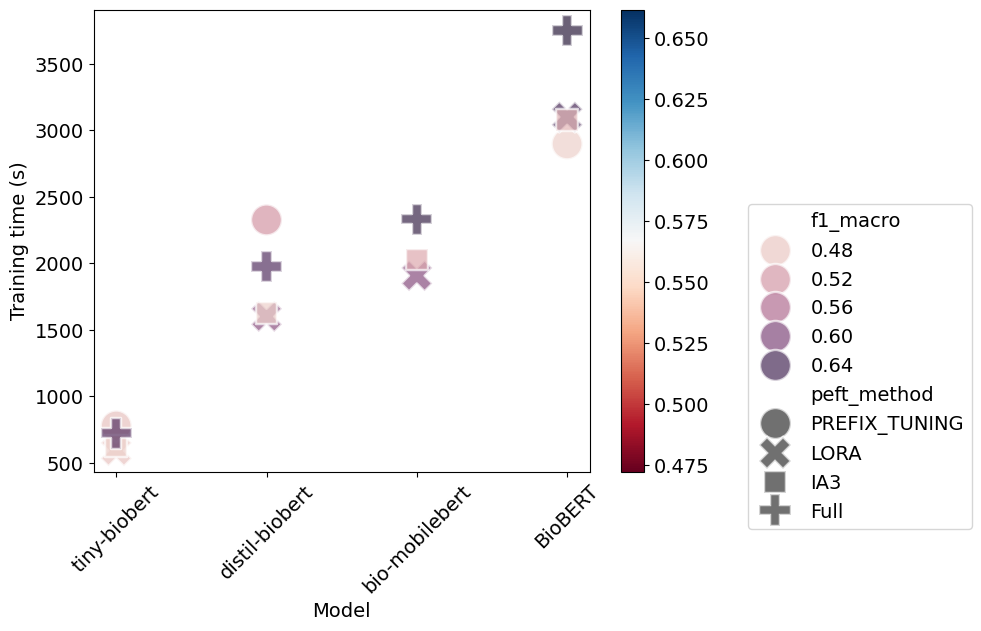

In [47]:
# make plot
plt.figure(figsize=(8, 6))
cls_metric = "f1_macro"
peft_type = "LORA"
time_plot_df = plot_df.query("task == @task and PEFT method == @peft_type")
time_plot_df = plot_df.query("task == @task")
ax = sns.scatterplot(data = time_plot_df,
                     x = "Model name",
                     y = "train/train_runtime",
                     hue = cls_metric,
                     style="PEFT method",
                     s = 500,
                     alpha = 0.7,
                     
                     )
norm = plt.Normalize(time_plot_df[cls_metric].min(), time_plot_df[cls_metric].max())
sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
sm.set_array([])
# Remove the legend and add a colorbar
# ax.get_legend().remove()
ax.figure.colorbar(sm, ax=ax)
# plt.suptitle(f"Alignment vs Uniformity for label {label}")
plt.xlabel("Model")
# rotate x tick labels by 45
plt.xticks(rotation=45)
plt.ylabel("Training time (s)")

    # for line in range(0,uniform_align_dfs.shape[0]):
    #     # print(f"line {line}")
    #     plt.text(uniform_align_dfs.iloc[line].uniform_loss+0.002, uniform_align_dfs.iloc[line].align_loss+0.02, uniform_align_dfs.iloc[line].model_name, horizontalalignment='center', size='medium', color='black', weight='semibold')
# texts = []
# for line in range(0,time_plot_df.shape[0]):
#     texts.append(plt.text(time_plot_df.iloc[line]["train/train_runtime"]+0.002,
#                           time_plot_df.iloc[line]["train/train_runtime"]+0.02,
#                           time_plot_df.iloc[line]["Model name"],
#                           horizontalalignment='left',
#                           size='medium',
#                           color='black',
#                           weight='semibold'))


# adjust_text(texts, arrowprops=dict(arrowstyle='-', color='red'))
# adjust_text(texts)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1.3, 0.6))
plt.savefig(f'{save_path}/{cls_metric}_PEFT methods_train_time.png', bbox_inches='tight')
plt.show()

### Storage analysis

In [26]:
model_type_size_mappings

{'distil': {'LORA': {'full_model_size_GB': 0.49018238950520754,
   'full_model_size_MB': 501.9467668533325,
   'model_size_GB': 0.24506665021181107,
   'model_size_MB': 250.94824981689453,
   'n_trainable_params': 147456,
   'n_trainable_params_perc': 0.2241497999728751,
   'peft_full_model_size_GB': 0.24627410527318716,
   'peft_full_model_size_MB': 252.18468379974365,
   'peft_model_size_GB': 0.00054931640625,
   'peft_model_size_MB': 0.5625,
   'total_trainable_params': 65784578},
  'PREFIX_TUNING': {'full_model_size_GB': 0.49018238950520754,
   'full_model_size_MB': 501.9467668533325,
   'model_size_GB': 0.24506665021181107,
   'model_size_MB': 250.94824981689453,
   'n_trainable_params': 92160,
   'n_trainable_params_perc': 0.14009362498304695,
   'peft_full_model_size_GB': 0.24638669844716787,
   'peft_full_model_size_MB': 252.2999792098999,
   'peft_model_size_GB': 0.00034332275390625,
   'peft_model_size_MB': 0.3515625,
   'total_trainable_params': 65784578},
  'PROMPT_TUNING':

In [12]:
# do above for all keys
# then concat all together
# then merge with cls_results_df

# create list of dataframes
dfs = []
for key in model_type_size_mappings.keys():
    df = pd.DataFrame(model_type_size_mappings[key]).T.reset_index().rename(columns={"index":"peft_type"})
    df["model_type"] = key
    # append to list
    dfs.append(df)
    
# concat all together
model_type_size_df = pd.concat(dfs)

In [51]:
model_type_size_df

,peft_type,full_model_size_GB,full_model_size_MB,model_size_GB,model_size_MB,n_trainable_params,n_trainable_params_perc,peft_full_model_size_GB,peft_full_model_size_MB,peft_model_size_GB,peft_model_size_MB,total_trainable_params,model_type
0,LORA,0.490182,501.946767,0.245067,250.948250,147456.0,0.224150,0.246274,252.184684,0.000549,0.562500,6.578458e+07,distil
1,PREFIX_TUNING,0.490182,501.946767,0.245067,250.948250,92160.0,0.140094,0.246387,252.299979,0.000343,0.351562,6.578458e+07,distil
2,PROMPT_TUNING,0.490182,501.946767,0.245067,250.948250,10756.0,0.016350,0.245194,251.078483,0.000040,0.041031,6.578458e+07,distil
3,P_TUNING,0.490182,501.946767,0.245067,250.948250,221696.0,0.337003,0.247358,253.294841,0.000826,0.845703,6.578458e+07,distil
0,LORA,49.353743,50538.232680,24.614304,25205.046875,4194304.0,0.063479,24.770985,25365.488444,0.015625,16.000000,6.607352e+09,llama-7b
1,PREFIX_TUNING,49.353743,50538.232680,24.614304,25205.046875,2621440.0,0.039675,24.774753,25369.347331,0.009766,10.000000,6.607352e+09,llama-7b
2,PROMPT_TUNING,49.353743,50538.232680,24.614304,25205.046875,57344.0,0.000868,24.739845,25333.601352,0.000214,0.218750,6.607352e+09,llama-7b
3,P_TUNING,49.353743,50538.232680,24.614304,25205.046875,1110272.0,0.016804,24.763512,25357.835853,0.004136,4.235352,6.607352e+09,llama-7b
0,LORA,0.183584,187.989936,0.091578,93.776375,221184.0,0.899747,0.093835,96.086712,0.000824,0.843750,2.458291e+07,mobile
1,PREFIX_TUNING,0.183584,187.989936,0.091578,93.776375,245760.0,0.999719,0.094868,97.145123,0.000916,0.937500,2.458291e+07,mobile


/mnt/sdc/niallt/venvs/39nlp/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/mnt/sdc/niallt/venvs/39nlp/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/mnt/sdc/niallt/venvs/39nlp/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/mnt/sdc/niallt/venvs/39nlp/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Categorica

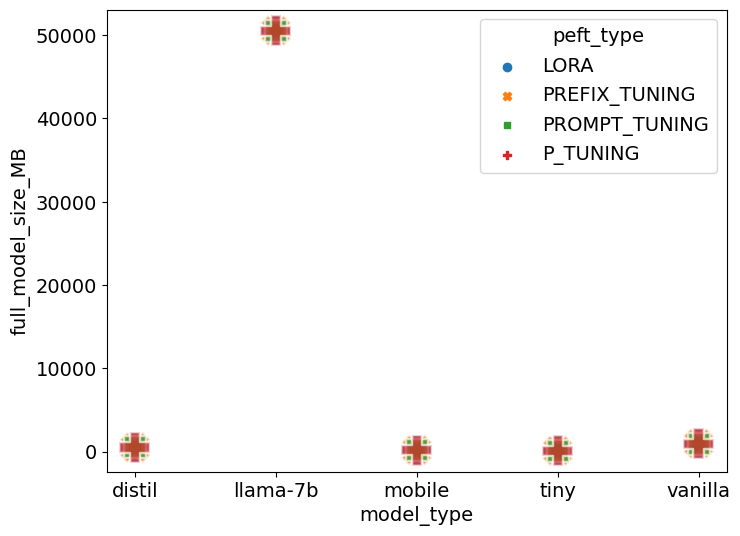

In [53]:
# plot the model type size df
# look at model type vs full model size
plt.figure(figsize=(8, 6))
ax = sns.scatterplot(data = model_type_size_df,
                     x = "model_type",
                     y = "full_model_size_MB",
                     hue = "peft_type",
                     style="peft_type",
                     s = 500,
                     alpha = 0.7,
                     
                     )


## Sensitivity analysis


### domain pre-training

In [25]:
logs_dir = '/mnt/sdd/efficient_ml_data/saved_models/peft/logs/' # original with single run for all models

dm_logs_df = read_tb_files(logs_dir)

# load

  0%|          | 0/244 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/mnt/sdd/efficient_ml_data/saved_models/peft/logs/mimic-mp/full/mimic-roberta-base/declutr/2_anch_2_pos_min_1024/LORA/22-12-2023--15-56/config.yaml'
[Errno 2] No such file or directory: '/mnt/sdd/efficient_ml_data/saved_models/peft/logs/mimic-mp/full/mimic-roberta-base/declutr/2_anch_2_pos_min_1024/LORA/22-12-2023--17-58/config.yaml'
[Errno 2] No such file or directory: '/mnt/sdd/efficient_ml_data/saved_models/peft/logs/mimic-mp/full/mimic-roberta-base/declutr/2_anch_2_pos_min_1024/LORA/22-12-2023--18-13/config.yaml'
[Errno 2] No such file or directory: '/mnt/sdd/efficient_ml_data/saved_models/peft/logs/mimic-mp/full/mimic-roberta-base_declutr_2_anch_2_pos_min_1024/LORA/22-12-2023--18-14/config.yaml'


  0%|          | 0/149856 [00:00<?, ?it/s]

In [87]:
# get the SEQ_CLS results for dm
dm_cls_results_df = produce_results_table(dm_logs_df,
                                            metric = ["f1",
                                                        "accuracy",
                                                        "precision",
                                                        "recall",
                                                        "auc"],
                                            mode = "all",
                                            groupby_list = ["Model name", "model_name_or_path", "task","few_shot_n", "PEFT method"],
                                            task_type = "SEQ_CLS",
                                            value_aggregate_method = "max",
                                            )

# same for NER
dm_ner_results_df = produce_results_table(dm_logs_df,
                                            metric = ["f1",
                                                        "accuracy",
                                                        "precision",
                                                        "recall",
                                                        "auc"],
                                            mode = "all",
                                            groupby_list = ["Model name", "model_name_or_path", "task","few_shot_n", "PEFT method"],
                                            task_type = "TOKEN_CLS",
                                            value_aggregate_method = "max",
                                            )

# concat the two dataframes 

dm_results_df = pd.concat([dm_cls_results_df, dm_ner_results_df])

In [88]:
dm_results_df

tag,index,Model name,model_name_or_path,task,few_shot_n,PEFT method,accuracy,eval/accuracy,eval/f1_macro,eval/f1_micro,...,eval/recall,eval/roc_auc_macro,f1_macro,f1_micro,f1_weighted,precision,recall,roc_auc_macro,eval/f1,f1
0,0,BERTbase,bert-base-uncased,ICD9-Triage,250.0,Full,0.944830,0.947013,0.876877,0.947013,...,0.886185,0.992056,0.872126,0.944830,0.945184,0.864495,0.881448,0.990813,NaN,NaN
1,1,BERTbase,bert-base-uncased,ICD9-Triage,250.0,LORA,0.912358,0.903019,0.631389,0.903019,...,0.650440,0.979965,0.632121,0.912358,0.899699,0.654783,0.655423,0.982676,NaN,NaN
2,2,BERTbase,bert-base-uncased,i2b2-2010-RE,250.0,Full,0.932000,0.930837,0.544309,0.930837,...,0.540983,0.981138,0.562515,0.932000,0.930019,0.588317,0.545287,0.975311,NaN,NaN
3,3,BERTbase,bert-base-uncased,i2b2-2010-RE,250.0,LORA,0.920419,0.917488,0.358018,0.917488,...,0.380196,0.978922,0.353060,0.920419,0.912713,0.372255,0.377330,0.979977,NaN,NaN
4,4,BERTbase,bert-base-uncased,mimic-los,250.0,Full,0.444583,0.430426,0.413175,0.430426,...,0.410729,0.691006,0.422577,0.444583,0.436728,0.433734,0.419396,0.702027,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,97,distil-biobert,nlpie/distil-biobert,i2b2-2012-NER,250.0,PREFIX_TUNING,0.763942,0.756912,NaN,NaN,...,0.418775,NaN,NaN,NaN,NaN,0.449556,0.422174,NaN,0.426700,0.435435
98,98,distil-biobert,nlpie/distil-biobert,i2b2-2014-NER,250.0,Full,0.995336,0.995452,NaN,NaN,...,0.955479,NaN,NaN,NaN,NaN,0.957572,0.953188,NaN,0.952837,0.955375
99,99,distil-biobert,nlpie/distil-biobert,i2b2-2014-NER,250.0,IA3,0.984981,0.985205,NaN,NaN,...,0.833733,NaN,NaN,NaN,NaN,0.852133,0.828818,NaN,0.841732,0.840314
100,100,distil-biobert,nlpie/distil-biobert,i2b2-2014-NER,250.0,LORA,0.991248,0.992098,NaN,NaN,...,0.910445,NaN,NaN,NaN,NaN,0.911723,0.901745,NaN,0.912711,0.906706


In [89]:
dm_PEFT_methods_to_plot = ["LORA","Full"]

In [90]:
dm_plot_df = dm_results_df.loc[dm_results_df['few_shot_n'] == 250].copy()
dm_plot_df =  dm_plot_df.loc[dm_plot_df['task'] != 'mednli']
# dm_plot_df = dm_plot_df.loc[dm_plot_df['Model name'].isin(
#     ['BioBERT','distil-biobert','bio-mobilebert', 'tiny-biobert'])] # , 'distil-biobert', 'bio-mobilebert', 'Bio-ClinicalBERT', 'tiny-biobert'
dm_plot_df = dm_plot_df.loc[dm_plot_df['PEFT method'].isin(dm_PEFT_methods_to_plot)]
dm_plot_df.sort_values(['Model name', 'PEFT method', 'task', 'few_shot_n', 'f1_macro'], 
                            ascending=False, inplace=True)
dm_plot_df.drop_duplicates(['Model name', 'PEFT method', 'task', 'few_shot_n'], inplace=True)
dm_plot_df['roc_auc_macro'] = dm_plot_df['roc_auc_macro'].apply(lambda x: round(x, 3)).values

In [91]:
dm_plot_df.query("`Model name` == 'RoBERTa-base'")

tag,index,Model name,model_name_or_path,task,few_shot_n,PEFT method,accuracy,eval/accuracy,eval/f1_macro,eval/f1_micro,...,eval/recall,eval/roc_auc_macro,f1_macro,f1_micro,f1_weighted,precision,recall,roc_auc_macro,eval/f1,f1
90,90,RoBERTa-base,roberta-base,mimic-mp,250.0,LORA,0.900224,0.605469,0.532737,0.605469,...,0.605469,0.820007,0.600925,0.900224,0.874397,0.743701,0.574960,0.825,NaN,NaN
89,89,RoBERTa-base,roberta-base,mimic-mp,250.0,Full,0.894115,0.656250,0.619048,0.656250,...,0.656250,0.851135,0.635777,0.894115,0.878500,0.701446,0.609044,0.806,NaN,NaN


In [92]:
dm_plot_df["Model name"].unique()

array(['distil-biobert', 'TinyClinicalBERT', 'TinyBioBERT', 'TinyBERT',
       'RoBERTa-base', 'MobileBERT', 'Llama-2-7b', 'DistilBERTbase',
       'ClinicalMobileBERT', 'ClinicalDistilBERT', 'BioMobileBERT',
       'BioDistilBERT', 'BioClinicalBERT', 'BioBERT', 'BERTbase'],
      dtype=object)

In [93]:
# plotting order 
dm_peft_model_order = [
                        "TinyBioBERT", 
                        "TinyClinicalBERT",
                        "TinyBERT", 
                       "BioMobileBERT",
                       "ClinicalMobileBERT",
                       "MobileBERT",
                       "BioDistilBERT",
                       "ClinicalDistilBERT",
                       "DistilBERTbase",
                       "BERTbase",
                       "BioBERT",
                       "BioClinicalBERT",
                    #    "RoBERTa-base"
                       ]

# set mapping of domain pre-training to model name
dm_model_mapping = {"TinyBERT":"General",
                    "MobileBERT":"General",
                    "DistilBERTbase":"General",
                    "BioBERT":"Bio",
                    "TinyBioBERT":"Bio",
                    "BioMobileBERT":"Bio",
                    "BioDistilBERT":"Bio",
                    "BERTbase":"General",
                    # "RoBERTa-base":"General",
                    "BioClinicalBERT":"Clinical",
                    "TinyClinicalBERT":"Clinical",
                    "ClinicalMobileBERT":"Clinical",
                    "ClinicalDistilBERT":"Clinical"}

# set a model type mapping too for plotting
dm_model_type_mapping = {"TinyBERT":"tiny",
                    "MobileBERT":"mobile",
                    "DistilBERTbase":"distil",
                    "BioBERT":"BERT",
                    "TinyBioBERT":"tiny",
                    "BioMobileBERT":"mobile",
                    "BioDistilBERT":"distil",
                    "BERTbase":"BERT",
                    # "RoBERTa-base":"RoBERTa",
                    "TinyClinicalBERT":"tiny",
                    "ClinicalMobileBERT":"mobile",
                    "ClinicalDistilBERT":"distil",
                    "BioClinicalBERT":"BERT"}

# add as new column
dm_plot_df["Domain pretraining"] = dm_plot_df["Model name"].map(dm_model_mapping)
# add type mapping too
dm_plot_df["Model type"] = dm_plot_df["Model name"].map(dm_model_type_mapping)

In [96]:
dm_plot_df.head()

tag,index,Model name,model_name_or_path,task,few_shot_n,PEFT method,accuracy,eval/accuracy,eval/f1_macro,eval/f1_micro,...,f1_macro,f1_micro,f1_weighted,precision,recall,roc_auc_macro,eval/f1,f1,Domain pretraining,Model type
134,134,distil-biobert,nlpie/distil-biobert,mimic-mp,250.0,LORA,0.898493,0.897922,0.535726,0.897922,...,0.526809,0.898493,0.858656,0.776498,0.527449,0.797,NaN,NaN,NaN,NaN
130,130,distil-biobert,nlpie/distil-biobert,mimic-los,250.0,LORA,0.426395,0.406286,0.352438,0.406286,...,0.376631,0.426395,0.407209,0.430320,0.368288,0.675,NaN,NaN,NaN,NaN
100,100,distil-biobert,nlpie/distil-biobert,i2b2-2014-NER,250.0,LORA,0.991248,0.992098,NaN,NaN,...,NaN,NaN,NaN,0.911723,0.901745,NaN,0.912711,0.906706,NaN,NaN
96,96,distil-biobert,nlpie/distil-biobert,i2b2-2012-NER,250.0,LORA,0.864203,0.878370,NaN,NaN,...,NaN,NaN,NaN,0.682386,0.693115,NaN,0.720114,0.687709,NaN,NaN
127,127,distil-biobert,nlpie/distil-biobert,i2b2-2010-RE,250.0,LORA,0.906558,0.908465,0.328647,0.908465,...,0.328966,0.906558,0.900034,0.309850,0.361653,0.976,NaN,NaN,NaN,NaN


In [94]:
dm_plot_df.query("task == 'i2b2-2010-RE'")[["Model name", "Domain pretraining", "PEFT method", "eval/f1_macro", "eval/f1_micro", "eval/roc_auc_macro","f1_weighted"]]

tag,Model name,Domain pretraining,PEFT method,eval/f1_macro,eval/f1_micro,eval/roc_auc_macro,f1_weighted
127,distil-biobert,NaN,LORA,0.328647,0.908465,0.975334,0.900034
126,distil-biobert,NaN,Full,0.561167,0.928326,0.984173,0.927556
117,TinyClinicalBERT,Clinical,LORA,0.319277,0.901070,0.967912,0.894316
116,TinyClinicalBERT,Clinical,Full,0.339610,0.912326,0.971817,0.906660
105,TinyBioBERT,Bio,LORA,0.268724,0.887023,0.953217,0.869152
103,TinyBioBERT,Bio,Full,0.333454,0.907860,0.972151,0.903352
94,TinyBERT,General,LORA,0.147782,0.864791,0.905218,0.816214
93,TinyBERT,General,Full,0.237101,0.886884,0.921025,0.863091
84,MobileBERT,General,LORA,0.405351,0.911442,0.979771,0.905170
83,MobileBERT,General,Full,0.525380,0.927953,0.984873,0.925160


In [101]:
dm_plot_df.query("task == 'MIMIC LoS'")[["Model name", "Domain pretraining", "PEFT method", "eval/f1_macro", "eval/f1_micro", "eval/roc_auc_macro","f1_weighted"]]

tag,Model name,Domain pretraining,PEFT method,eval/f1_macro,eval/f1_micro,eval/roc_auc_macro,f1_weighted
130,distil-biobert,NaN,LORA,0.352438,0.406286,0.660010,0.407209
128,distil-biobert,NaN,Full,0.410929,0.429970,0.690352,0.434849
119,TinyClinicalBERT,NaN,LORA,0.330938,0.401275,0.653870,0.400425
118,TinyClinicalBERT,NaN,Full,0.384684,0.424732,0.683137,0.433733
108,TinyBioBERT,NaN,LORA,0.300728,0.387611,0.635998,0.365567
106,TinyBioBERT,NaN,Full,0.380408,0.421089,0.673502,0.418606
96,TinyBERT,NaN,LORA,0.204148,0.375313,0.588501,0.289188
95,TinyBERT,NaN,Full,0.384688,0.411296,0.665535,0.415505
86,MobileBERT,NaN,LORA,0.348924,0.406513,0.651268,0.395369
85,MobileBERT,NaN,Full,0.409864,0.439080,0.695632,0.435117


#### latex table

In [97]:
dm_plot_df.task.unique()

array(['mimic-mp', 'mimic-los', 'i2b2-2014-NER', 'i2b2-2012-NER',
       'i2b2-2010-RE', 'i2b2-2010-NER', 'ICD9-Triage'], dtype=object)

In [100]:
# produce latex table of all the dm results
dm_paper_results = dm_plot_df.groupby(['Model name', 'PEFT method', 'task', 'few_shot_n'])['roc_auc_macro'].max().reset_index().pivot_table(index=['Model name', 'PEFT method'],
                                                                                                        columns=['task',],
                                                                                                        values='roc_auc_macro').reset_index()
print(dm_paper_results.to_latex(
            caption = "PEFT results for CLS tasks dependent on domain pre-training received",
            label = "domain-peft-cls-results",
            float_format="%.3f",
            index = False,
            multirow = False,
            multicolumn = True,
            position = "htp",))


\begin{table}[htp]
\centering
\caption{PEFT results for CLS tasks dependent on domain pre-training received}
\label{domain-peft-cls-results}
\begin{tabular}{llrrrr}
\toprule
        Model name & PEFT method &  ICD9-Triage &  i2b2-2010-RE &  mimic-los &  mimic-mp \\
\midrule
          BERTbase &        Full &        0.991 &         0.975 &      0.702 &     0.799 \\
          BERTbase &        LORA &        0.983 &         0.980 &      0.679 &     0.811 \\
           BioBERT &        Full &        0.991 &         0.982 &      0.711 &     0.812 \\
           BioBERT &        LORA &        0.991 &         0.985 &      0.697 &     0.828 \\
   BioClinicalBERT &        Full &        0.993 &         0.978 &      0.697 &     0.793 \\
   BioClinicalBERT &        LORA &        0.990 &         0.981 &      0.701 &     0.822 \\
     BioDistilBERT &        Full &        0.992 &         0.979 &      0.697 &     0.803 \\
     BioDistilBERT &        LORA &        0.993 &         0.988 &      0.704 &   

/tmp/ipykernel_39157/2741877156.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(dm_paper_results.to_latex(


In [101]:
dm_paper_results = dm_plot_df.groupby(['Model name', 'PEFT method', 'task', 'few_shot_n'])['f1'].max().reset_index().pivot_table(index=['Model name', 'PEFT method'],
                                                                                                        columns=['task',],
                                                                                                        values='f1').reset_index()
print(dm_paper_results.to_latex(
            caption = "PEFT results for CLS tasks dependent on domain pre-training received",
            label = "domain-peft-cls-results",
            float_format="%.3f",
            index = False,
            multirow = False,
            multicolumn = True,
            position = "htp",))


\begin{table}[htp]
\centering
\caption{PEFT results for CLS tasks dependent on domain pre-training received}
\label{domain-peft-cls-results}
\begin{tabular}{llrrr}
\toprule
        Model name & PEFT method &  i2b2-2010-NER &  i2b2-2012-NER &  i2b2-2014-NER \\
\midrule
          BERTbase &        Full &          0.806 &          0.792 &          0.974 \\
          BERTbase &        LORA &          0.673 &          0.697 &          0.951 \\
           BioBERT &        Full &          0.822 &          0.823 &          0.969 \\
           BioBERT &        LORA &          0.713 &          0.757 &          0.935 \\
   BioClinicalBERT &        Full &          0.846 &          0.820 &          0.960 \\
   BioClinicalBERT &        LORA &          0.704 &          0.746 &          0.920 \\
     BioDistilBERT &        Full &          0.809 &          0.794 &          0.965 \\
     BioDistilBERT &        LORA &          0.704 &          0.726 &          0.939 \\
     BioMobileBERT &        Full & 

/tmp/ipykernel_39157/67771776.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(dm_paper_results.to_latex(


#### the task here may be quite important

MIMIC MP, MIMIC LoS, and ICD9 may be unfair as the clinical models have been trained on presumably all mimic notes

############## Task is : i2b2-2010-RE ##############


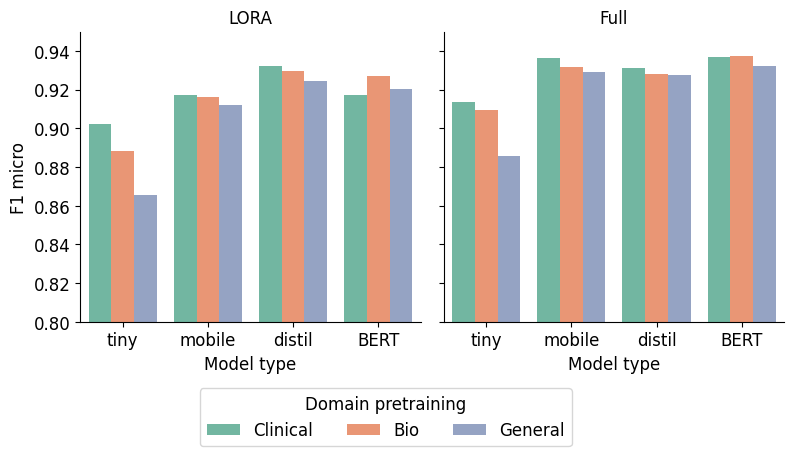

In [32]:
# metrics = ['roc_auc_macro', 'f1_macro', 'f1_micro', 'f1_weighted']
metrics = ['f1_micro']

dm_plot_df['log(n_trainable_params)'] = np.log10(dm_plot_df['PEFT_params'])


# tasks = ["MIMIC LoS", "MIMIC MP", "ICD9-Triage", "i2b2-2010-RE"]
tasks = [ "i2b2-2010-RE"]

# loop over task
for task in tasks:
        print(f"############## task is : {task} ##############")
        for metric in metrics:
                # change font size
                

                # fig, ax = plt.subplots(figsize=(7,7))
                g = sns.FacetGrid(data = dm_plot_df.query("task == @task"),
                                col='PEFT method',
                                sharey=True, 
                                legend_out=True, 
                                aspect = 1, 
                                height = 4)
                g.map_dataframe(sns.barplot,
                                x = "Model type",
                                y = metric,
                                hue = "Domain pretraining",
                                palette='Set2',
                                )
                
                # change the column name of the facet grid from PEFT method to Peft method
                g.set_titles(col_template="{col_name}", row_template="{row_name}")
                
                
                # add y limit to facegrid plot
                g.set(ylim=(0.8, 0.95))
                
                plt.legend(
                        title = "Domain pretraining",
                        loc='upper right', 
                        bbox_to_anchor=(0.4, -0.2),  
                        fancybox=True, shadow=False, 
                        ncol=5
                        )

                # replace y axis with metric name
                g.set_ylabels(metric_name_mapping[metric])

                # plt.suptitle("PEFT Method", x=0.5, y=0, ha='center')
                # plt.suptitle(f"MIMIC-III ICD9-Triage task - Frozen LLM")
                # save
                # plt.tight_layout()
                plt.savefig(f'{save_path}/{task}_{metric}_PEFT methods_dm.png', bbox_inches='tight')
                plt.show()

############## task is : mimic-los ##############


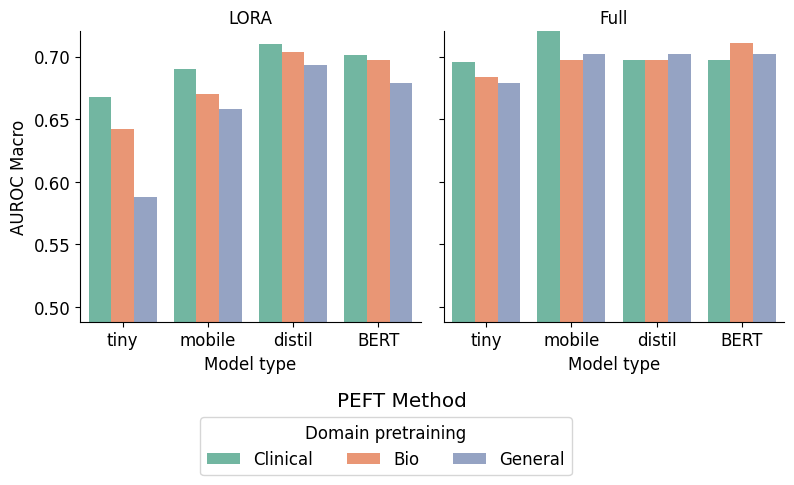

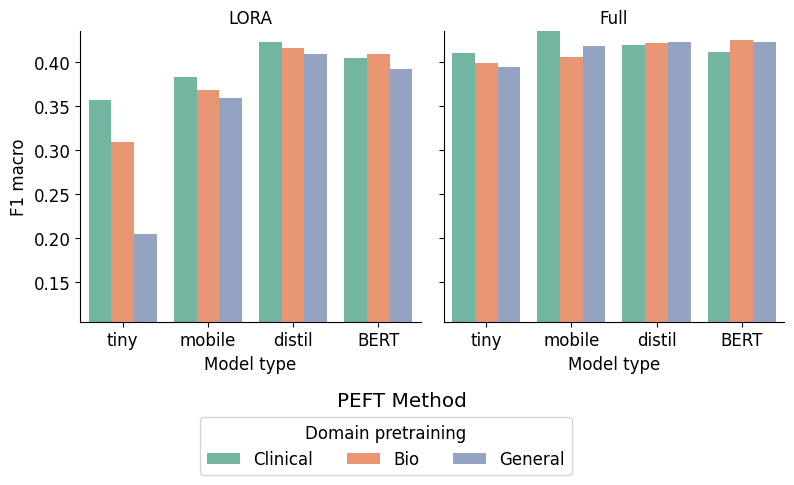

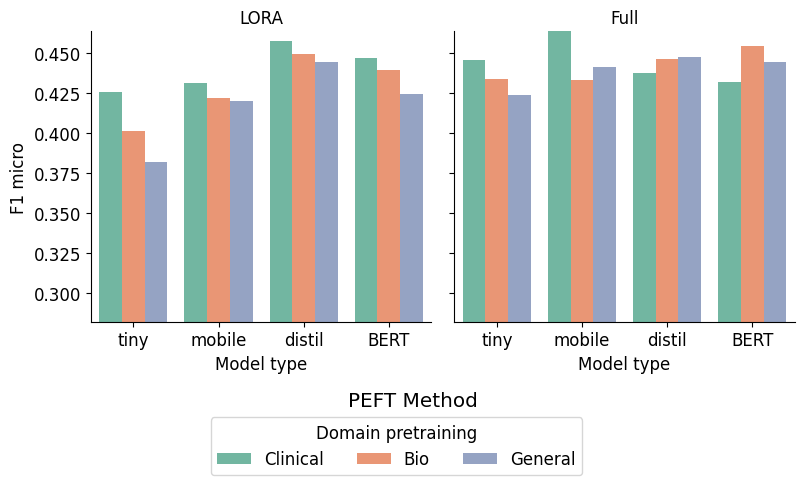

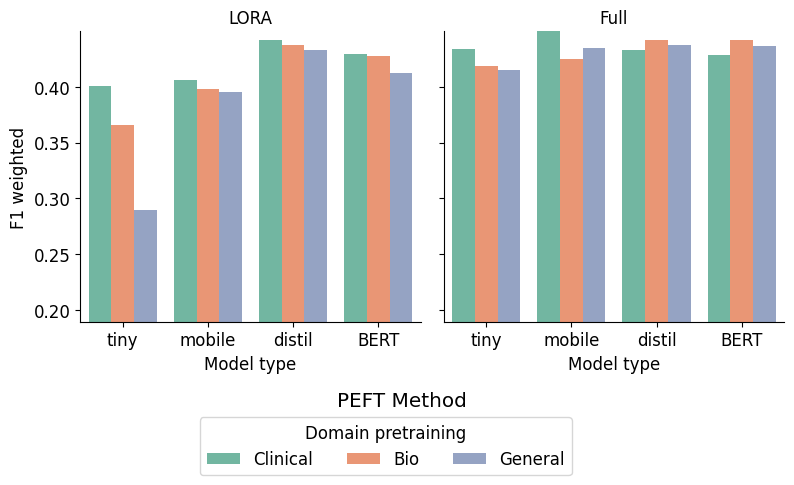

############## task is : mimic-mp ##############


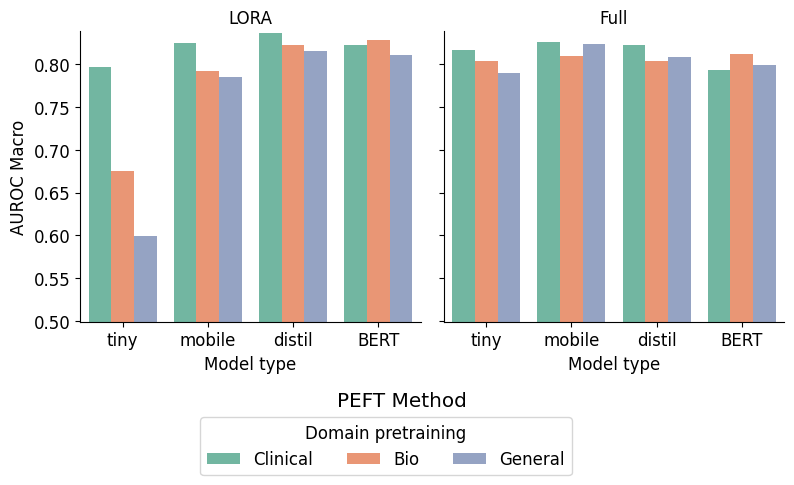

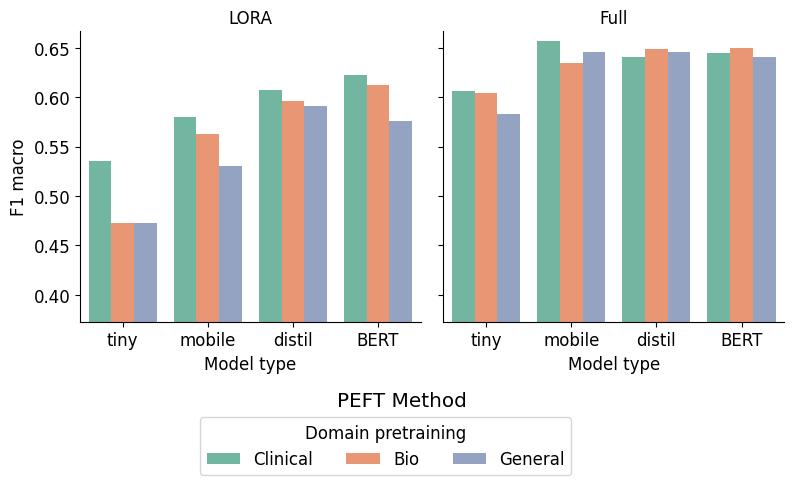

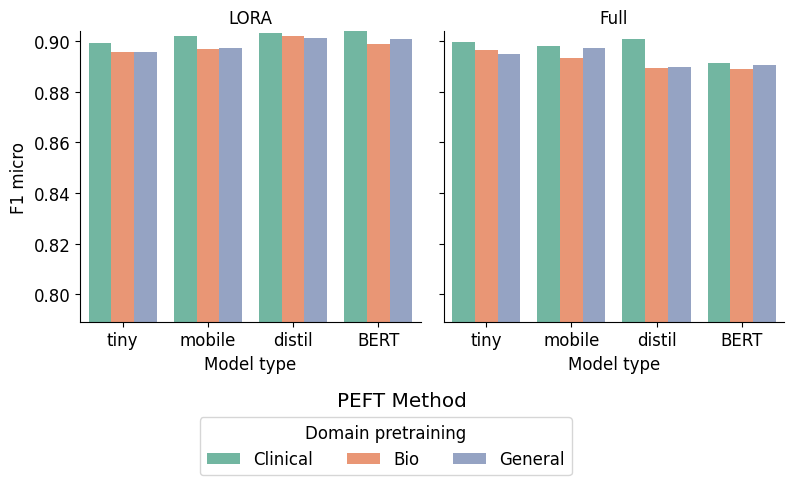

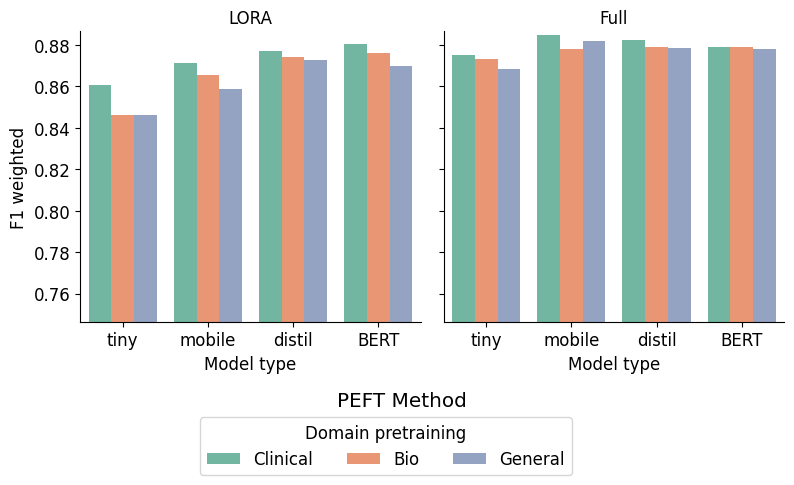

############## task is : ICD9-Triage ##############


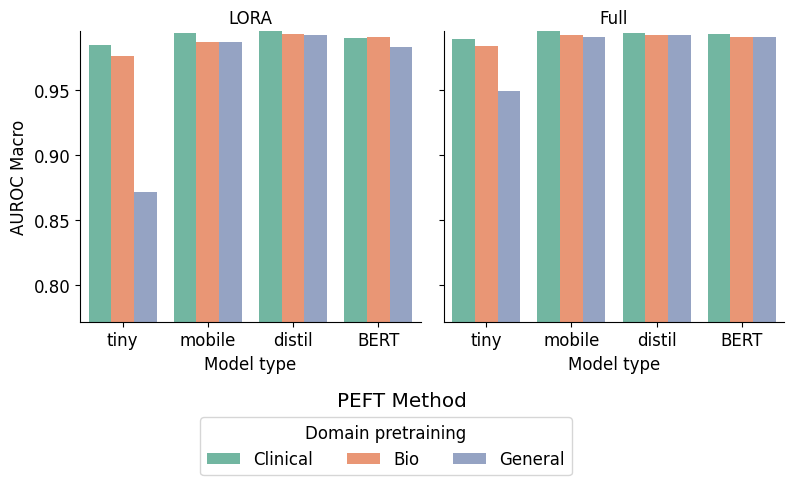

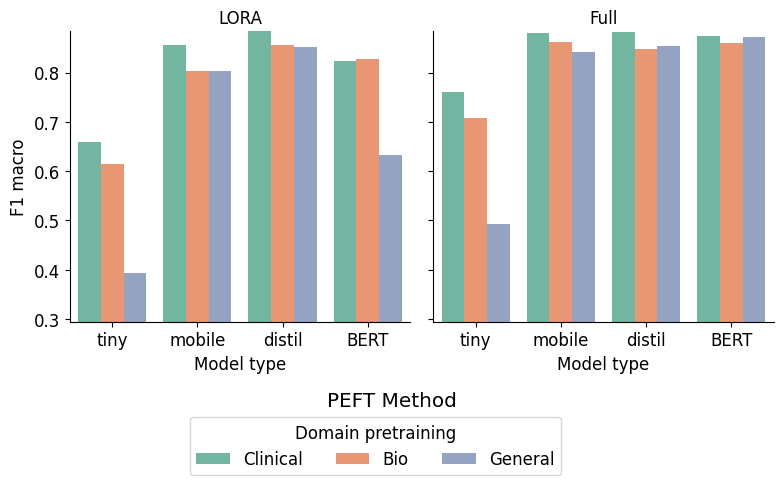

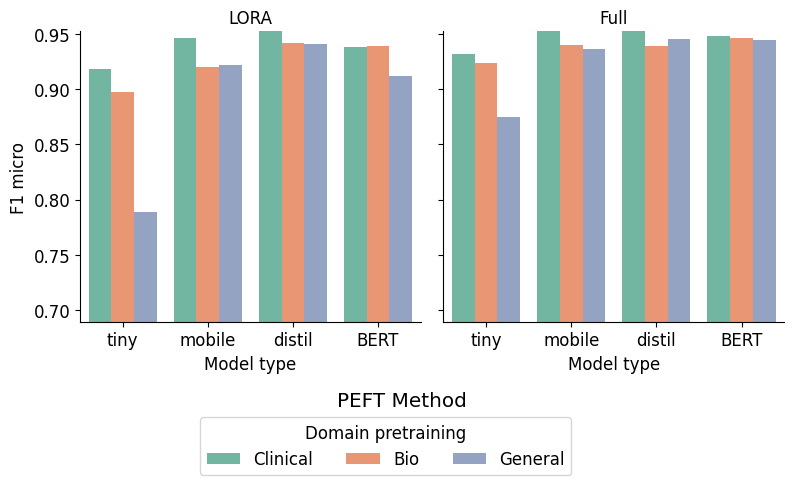

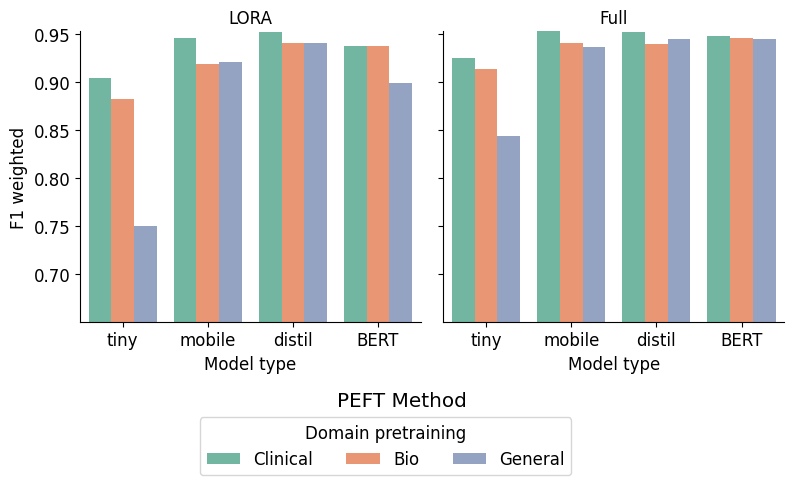

############## task is : i2b2-2010-RE ##############


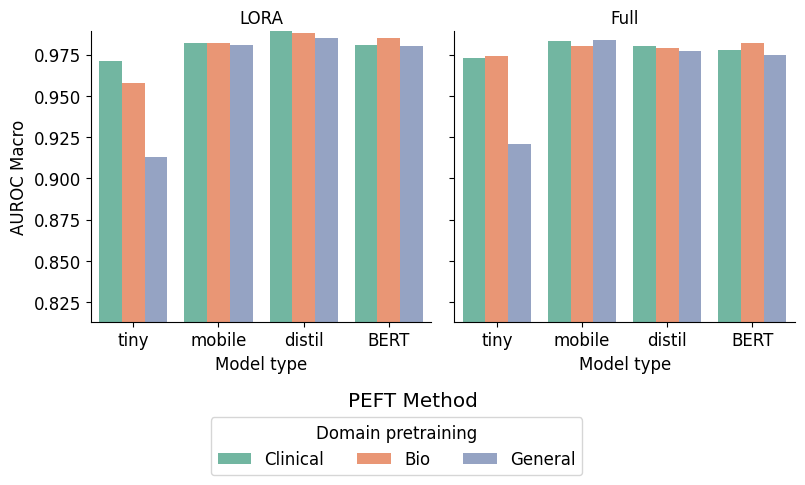

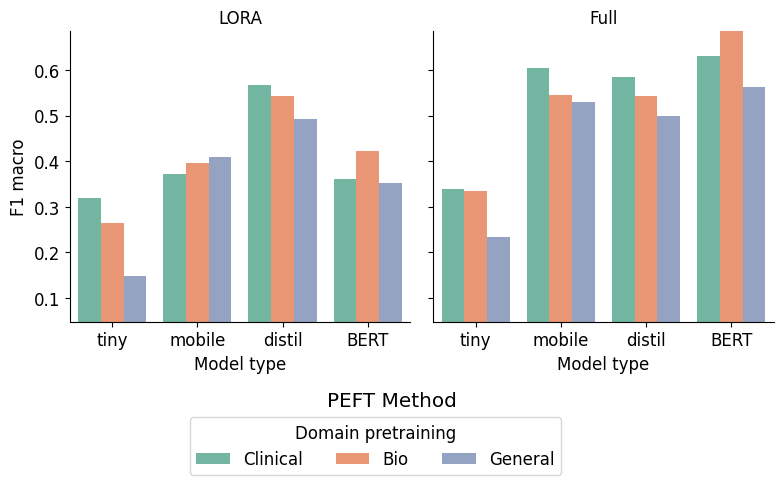

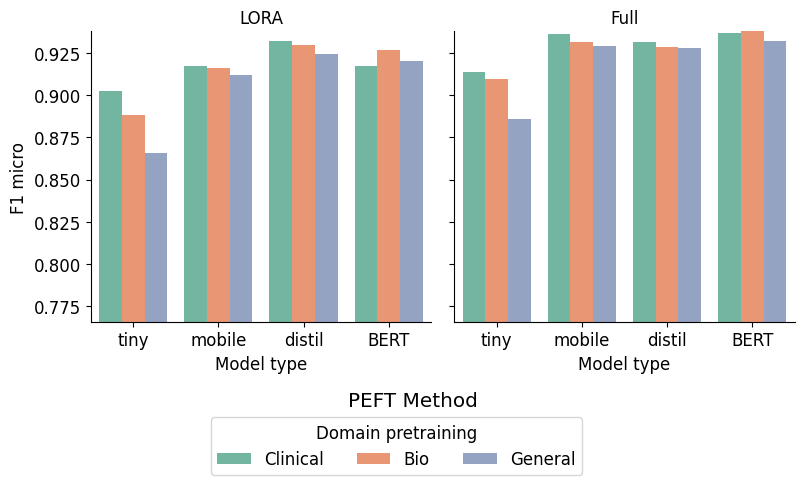

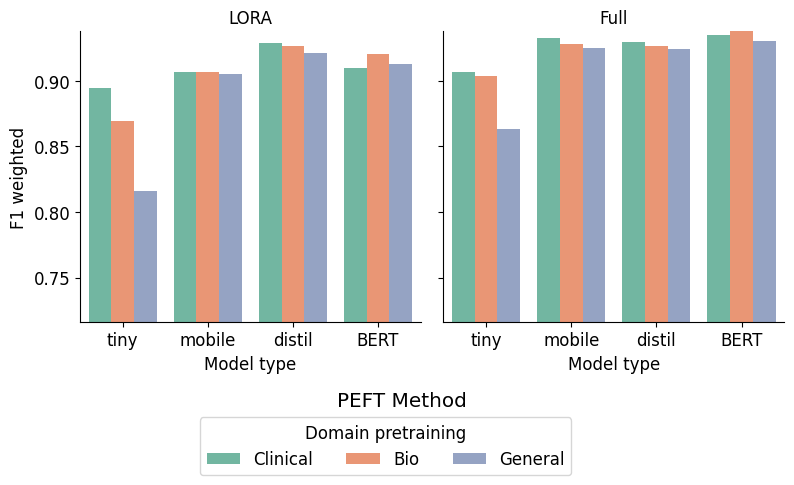

In [105]:
metrics = ['roc_auc_macro', 'f1_macro', 'f1_micro', 'f1_weighted']
# metrics = ['f1_micro']

dm_plot_df['log(n_trainable_params)'] = np.log10(dm_plot_df['PEFT_params'])


tasks = ["MIMIC LoS", "MIMIC MP", "ICD9-Triage", "i2b2-2010-RE"]
# tasks = [ "i2b2-2010-RE"]

# loop over task
for task in tasks:
        print(f"############## task is : {task} ##############")
        for metric in metrics:
                # change font size
                

                # fig, ax = plt.subplots(figsize=(7,7))
                g = sns.FacetGrid(data = dm_plot_df.query("task == @task"),
                                col='PEFT method',
                                sharey=True, 
                                legend_out=True, 
                                aspect = 1, 
                                height = 4)
                g.map_dataframe(sns.barplot,
                                x = "Model type",
                                y = metric,
                                hue = "Domain pretraining",
                                palette='Set2',
                                )
                
                # change the column name of the facet grid from PEFT method to Peft method
                g.set_titles(col_template="{col_name}", row_template="{row_name}")
                
                
                # add y limit to facegrid plot
                # set the y limit dynamically based on the min and max?
                y_min = dm_plot_df.query("task == @task")[metric].min()
                y_max = dm_plot_df.query("task == @task")[metric].max()
                g.set(ylim=(y_min-0.1, y_max))
                # g.set(ylim=(0.8, 0.95))
                
                plt.legend(
                        title = "Domain pretraining",
                        loc='upper right', 
                        bbox_to_anchor=(0.4, -0.3),  
                        fancybox=True, shadow=False, 
                        ncol=5
                        )

                # replace y axis with metric name
                g.set_ylabels(metric_name_mapping[metric])

                plt.suptitle("PEFT Method", x=0.5, y=0, ha='center')
                # plt.suptitle(f"MIMIC-III ICD9-Triage task - Frozen LLM")
                # save
                plt.savefig(f'{save_path}/{task}_{metric}_peft_methods_dm.png', bbox_inches='tight')
                plt.show()

### Fewshot sampling vs performance

In [26]:
# the dir needs the trailing slash 
# fs_logs_dir = "/mnt/sdd/efficient_ml_data/saved_models/peft/fewshot_budget_linearLR/logs/"
fs_logs_dir = "/mnt/sdh/effecient_ml/fewshot_budget/logs/"

In [27]:
# load in the few shot sensitivity 
fs_logs_df = read_tb_files(fs_logs_dir)

# cls_results_df = produce_results_table(logs_df, 
#                                 metric = ["f1",
#                                         "accuracy",
#                                         "precision",
#                                         "recall",
#                                         "auc", 
#                                         "train/total_flos", "train/train_loss",
#                                         "train/train_runtime", "train/train_samples_per_second",
#                                         "train/train_steps_per_second"],
#                                 mode = "all",
#                                 groupby_list = ["Model name", "model_name_or_path", "task","few_shot_n", "PEFT method"],
#                                 task_type = "SEQ_CLS",
#                                 value_aggregate_method = "max",
#                                 )

# do same for fs_logs_df

fs_cls_results_df = produce_results_table(fs_logs_df,
                                metric = ["f1",
                                        "accuracy",
                                        "precision",
                                        "recall",
                                        "auc", 
                                        "train/total_flos", "train/train_loss",
                                        "train/train_runtime", "train/train_samples_per_second",
                                        "train/train_steps_per_second"],
                                mode = "all",
                                groupby_list = ["Model name", "model_name_or_path", "task","few_shot_n", "PEFT method"],
                                task_type = "SEQ_CLS",
                                value_aggregate_method = "max",
                                )

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/13779 [00:00<?, ?it/s]

In [22]:
fs_cls_results_df.head()

tag,index,Model name,model_name_or_path,task,few_shot_n,peft_method,accuracy,eval/accuracy,eval/f1_macro,eval/f1_micro,...,f1_micro,f1_weighted,precision,recall,roc_auc_macro,train/total_flos,train/train_loss,train/train_runtime,train/train_samples_per_second,train/train_steps_per_second
0,0,BioBERT,dmis-lab/biobert-v1.1,mimic-mp,16,Full,0.514254,0.542969,0.542906,0.542969,...,0.514254,0.604579,0.512562,0.533600,0.532807,4.735999e+13,0.616700,40.445599,7.912,0.247
1,1,BioBERT,dmis-lab/biobert-v1.1,mimic-mp,16,LORA,0.553044,0.546875,0.545877,0.546875,...,0.553044,0.639203,0.508196,0.521639,0.520717,7.947832e+13,0.680826,47.839199,6.689,0.209
2,2,BioBERT,dmis-lab/biobert-v1.1,mimic-mp,32,Full,0.507941,0.535156,0.534581,0.535156,...,0.507941,0.598894,0.511245,0.530076,0.539727,1.105066e+14,0.674736,50.742500,12.613,0.394
3,3,BioBERT,dmis-lab/biobert-v1.1,mimic-mp,32,LORA,0.384952,0.527344,0.511512,0.527344,...,0.384952,0.471395,0.508643,0.520890,0.525758,1.589566e+14,0.710534,52.774601,12.127,0.379
4,4,BioBERT,dmis-lab/biobert-v1.1,mimic-mp,64,Full,0.599369,0.574219,0.572752,0.574219,...,0.599369,0.677201,0.526088,0.567325,0.593590,3.157333e+14,0.535528,84.508202,15.146,0.473


In [23]:
fs_cls_results_df.few_shot_n.unique()

array([  16,   32,   64,  128,  256,  512, 1024, 2048, 4096])

In [34]:
fs_cls_results_df.columns

Index(['index', 'Model name', 'model_name_or_path', 'task', 'few_shot_n',
       'peft_method', 'accuracy', 'eval/accuracy', 'eval/f1_macro',
       'eval/f1_micro', 'eval/f1_weighted', 'eval/precision', 'eval/recall',
       'eval/roc_auc_macro', 'f1_macro', 'f1_micro', 'f1_weighted',
       'precision', 'recall', 'roc_auc_macro', 'train/total_flos',
       'train/train_loss', 'train/train_runtime',
       'train/train_samples_per_second', 'train/train_steps_per_second'],
      dtype='object', name='tag')

In [35]:
fs_cls_results_df.query("few_shot_n == 4096")[["Model name", "task", "few_shot_n", "PEFT method", "eval/roc_auc_macro", "train/train_runtime"]]

tag,Model name,task,few_shot_n,peft_method,eval/roc_auc_macro,train/train_runtime
16,BioBERT,mimic-mp,4096,Full,0.798677,2025.520508
17,BioBERT,mimic-mp,4096,LORA,0.804639,1547.642700
18,Llama-2-7b,mimic-mp,4096,LORA,0.826167,28254.244141
35,RoBERTa-base,mimic-mp,4096,Full,0.797783,1599.247559
36,RoBERTa-base,mimic-mp,4096,LORA,0.802199,1377.530518
53,bio-mobilebert,mimic-mp,4096,Full,0.803967,989.753906
54,bio-mobilebert,mimic-mp,4096,LORA,0.791002,1051.067993
71,distil-biobert,mimic-mp,4096,Full,0.793782,976.901672
72,distil-biobert,mimic-mp,4096,LORA,0.798827,908.158691
89,tiny-biobert,mimic-mp,4096,Full,0.785742,419.180511


In [18]:
fs_cls_results_df["Model name"].unique()

array(['BioBERT', 'BioDistilBERT', 'BioMobileBERT', 'RoBERTa-base',
       'TinyBioBERT'], dtype=object)

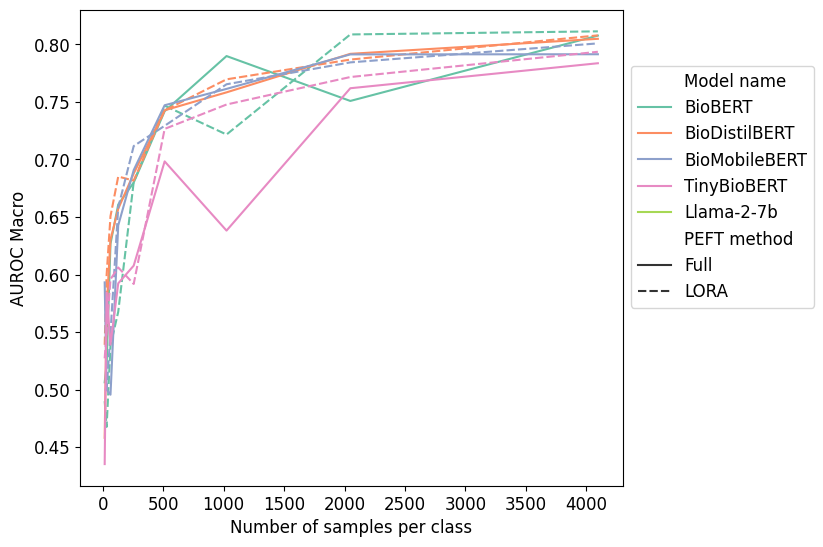

In [110]:
task = "MIMIC MP"

fig, ax = plt.subplots(figsize=(7,7))
metric = "roc_auc_macro" # | roc_auc_macro
# lineplot looking at few_shot_n on x-axis and f1_macro on y-axis
sns.lineplot(data = fs_cls_results_df.query("task == @task & `Model name` != 'RoBERTa-base'"),
             x = "few_shot_n",
             y = metric,
             hue = "Model name",
            hue_order = HUE_ORDER,
             style = "PEFT method",
             ax = ax,
             legend = True,
             palette = PALETTE
             )

# do pointplot instead
# sns.pointplot(data = fs_cls_results_df.query("PEFT method == 'LORA'"),
#              x = "few_shot_n",
#              y = metric,
#              hue = "Model name",
#              linestyles= "--",
#              ax = ax,
#              legend = True
#              )

# change y label based on metric mapping
ax.set_ylabel(metric_name_mapping[metric])
plt.legend(loc=2, # 'upper right',
           bbox_to_anchor=(1., 0.9),  
           fancybox=True, shadow=False, 
           ncol=1)


# draw a horizontal line for the full training set and set at value of peft method with full training set
# and set to same plot as above
# ax.axhline(y=cls_results_df.query("`Model name` == 'BioBERT' & task == @task & few_shot_n == 250")["roc_auc_macro"].values[0], color='black', linestyle='--', alpha = 0.5)
# remove x axis label
ax.set_xlabel("Number of samples per class")

# fig.suptitle("Number of samples per class", x=0.5, y=0.1, ha='center')
# plt.suptitle(f"MIMIC-III ICD9-Triage task - Frozen LLM")
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(wspace=0.25)

# save
plt.savefig(f'{save_path}/{task}_few_shot_n_sensitivity.png', bbox_inches='tight')

In [65]:
save_path

'/mnt/sdd/efficient_ml_data/figures_and_plots/'

<Figure size 700x700 with 0 Axes>

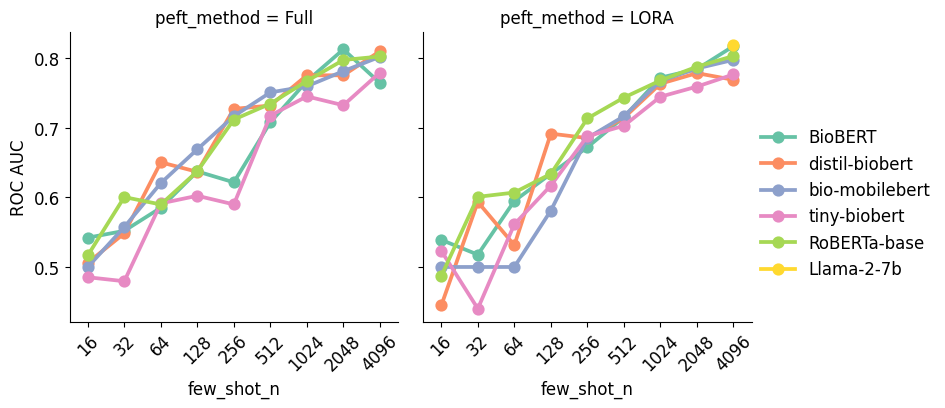

<Figure size 700x700 with 0 Axes>

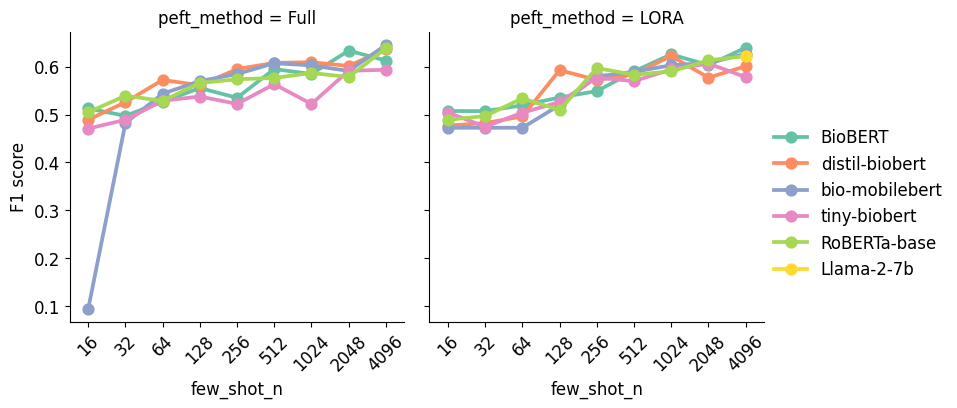

In [30]:
# same as above but with facet

metrics = ['roc_auc_macro', 'f1_macro']

for metric in metrics:

    plt.figure(figsize=(7, 7))
    fg = sns.FacetGrid(data=fs_cls_results_df,
                        col='PEFT method', 
                        sharey=True,
                          sharex=True,
                            legend_out=True,
                              aspect = 1, 
                              height = 4,
                              )
    fg.map_dataframe(sns.pointplot,
                      x='few_shot_n',
                        y=metric,
                          hue='Model name', 
                      hue_order = [
                                'BioBERT',
                                  # 'distil-biobert',
                                  'BioDistilBERT',
                                  'BioMobileBERT',
                                  'TinyBioBERT',
                                  'Llama-2-7b',
                                  # 'RoBERTa-base'
                                  ],
                    palette='Set2')
    fg.add_legend()
    # handles, labels = fg.axes[0,0].get_legend_handles_labels()
    # fg.fig.legend(handles, labels)
    # sns.move_legend(ax, "upper left", bbox_to_anchor=(1.02, 0.4))
    fg.set_xticklabels(rotation = 45)
    # set y label based on metric mapping
    fg.set_ylabels(metric_name_mapping[metric])
    
    # add grid lines
    # fg.grid()
    # save
    # plt.savefig(f'{save_path}/{metric}_few_shot_n_sensitivity_facet.png', bbox_inches='tight')
    plt.show()

In [113]:
metric_name_mapping

{'f1_macro': 'F1 macro',
 'f1_micro': 'F1 micro',
 'f1': 'F1',
 'f1_weighted': 'F1 weighted',
 'roc_auc_macro': 'AUROC Macro'}

/tmp/ipykernel_12593/372582581.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['few_shot_n'] = plot_df['few_shot_n'].astype(str)
/tmp/ipykernel_12593/372582581.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df.rename(columns={'few_shot_n': 'Num training samples',


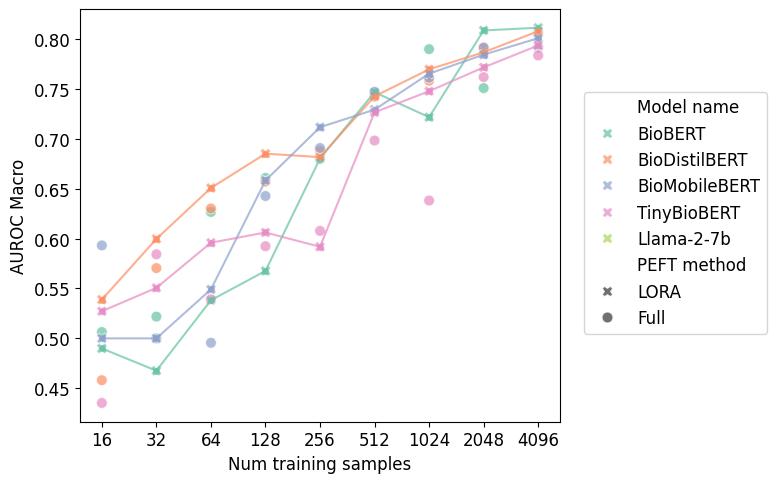

In [16]:

plot_df = fs_cls_results_df.loc[fs_cls_results_df['Model name'] != 'RoBERTa-base']
# convert few_shot_n to string
plot_df['few_shot_n'] = plot_df['few_shot_n'].astype(str)
plot_df.rename(columns={'few_shot_n': 'Num training samples', 
                        'roc_auc_macro':metric_name_mapping['roc_auc_macro'],
                        'peft_method': 'PEFT method'}, inplace=True)
metrics = ['AUROC Macro']

for metric in metrics:
    fig, ax = plt.subplots(figsize=(8, 5))
    sns.pointplot(data=plot_df.loc[plot_df['PEFT method'] == 'LORA'], 
                  x='Num training samples', y=metric, 
                  hue='Model name', hue_order = ['BioBERT',
                                  # 'distil-biobert',
                                  'BioDistilBERT',
                                  'BioMobileBERT',
                                  'TinyBioBERT',
                                  'Llama-2-7b',
                                #   'RoBERTa-base',
                                  ],
                  alpha=0.7, linewidth=1.5, markersize=4, palette=PALETTE, legend=False)
    sns.scatterplot(data=plot_df, 
                  x='Num training samples', y=metric, 
                  hue='Model name',
                  hue_order = HUE_ORDER,
                  style='PEFT method', style_order=[ 'LORA', 'Full'],
                  alpha=0.7, markers=['X', 'o'], s=60, palette=PALETTE)
    
    plt.legend(bbox_to_anchor=(1.05, 0.8), loc=2, borderaxespad=0.)
    plt.tight_layout()
    plt.savefig(f'{save_path}/fewshot_sensitivity.png', bbox_inches='tight', dpi=300)
    plt.show()

### Time budget

In [28]:
from datetime import datetime
def extract_datetime(x):
    dt = x.split('/')[-1]
    dt = datetime.strptime(dt, '%d-%m-%Y--%H-%M')
    return dt

# load in the few shot sensitivity logs
fs_logs_dir = '/mnt/sdh/effecient_ml/tb_2000/logs/'
fs_logs_df = read_tb_files(fs_logs_dir)
fs_logs_df['datetime'] = fs_logs_df['dir_name'].apply(lambda x: extract_datetime(x))

fs_logs_df.shape

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/48339 [00:00<?, ?it/s]

(48339, 63)

In [29]:
llama_logs = fs_logs_df.loc[fs_logs_df['Model name'] == 'Llama-2-7b']
fs_logs_df = fs_logs_df.loc[fs_logs_df['scheduler_type'] == 'linear']
fs_logs_df = pd.concat((fs_logs_df, llama_logs))

# Group by model name and peft method and keep all rows with only the
# latest datetime
fs_logs_df = fs_logs_df.loc[fs_logs_df.groupby(
    ['Model name', 'PEFT method'])['datetime'].transform(
        lambda x: x == x.max()).reindex()]

In [60]:
fs_logs_df.columns

Index(['step', 'tag', 'value', 'wall_time', 'dir_name', 'cache_dir',
       'ckpt_save_dir', 'combined_val_test_sets', 'custom_model_name',
       'data_dir', 'dropout', 'early_stopping_patience',
       'early_stopping_threshold', 'eight_bit_training', 'eval_batch_size',
       'eval_data_dir', 'eval_every_steps', 'eval_few_shot_n',
       'evaluation_strategy', 'few_shot_n', 'gradient_accumulation_steps',
       'label_col', 'label_name', 'learning_rate', 'loader_workers',
       'log_every_steps', 'log_save_dir', 'lora_alpha', 'lora_dropout',
       'lora_rank', 'max_epochs', 'max_length', 'metric_mode',
       'model_name_or_path', 'monitor', 'n_trainable_params', 'no_cuda',
       'num_virtual_tokens', 'optimizer', 'optuna', 'patience', 'peft_method',
       'pretrained_models_dir', 'remove_columns', 'save_adapter',
       'save_every_steps', 'saving_strategy', 'scheduler_type', 'task',
       'task_to_keys', 'task_type', 'test_file', 'text_col', 'text_column',
       'time_budget

In [141]:
save_path

'/mnt/sdd/efficient_ml_data/figures_and_plots/'

In [54]:
fs_logs_df["Model name"].unique()

array(['BioDistilBERT', 'BioMobileBERT', 'BioBERT', 'distil-biobert',
       'RoBERTa-base', 'TinyBioBERT', 'Llama-2-7b'], dtype=object)

In [56]:
fs_logs_df[['step', 'tag', 'value', 'wall_time', 'Model name', 'PEFT method']].query("`Model name` != 'RoBERTa-base'")["Model name"].unique()

array(['BioDistilBERT', 'BioMobileBERT', 'BioBERT', 'distil-biobert',
       'TinyBioBERT', 'Llama-2-7b'], dtype=object)

In [118]:
fs_logs_df.columns

Index(['step', 'tag', 'value', 'wall_time', 'dir_name', 'cache_dir',
       'ckpt_save_dir', 'combined_val_test_sets', 'custom_model_name',
       'data_dir', 'dropout', 'early_stopping_patience',
       'early_stopping_threshold', 'eight_bit_training', 'eval_batch_size',
       'eval_data_dir', 'eval_every_steps', 'eval_few_shot_n',
       'evaluation_strategy', 'few_shot_n', 'gradient_accumulation_steps',
       'label_col', 'label_name', 'learning_rate', 'loader_workers',
       'log_every_steps', 'log_save_dir', 'lora_alpha', 'lora_dropout',
       'lora_rank', 'max_epochs', 'max_length', 'metric_mode',
       'model_name_or_path', 'monitor', 'n_trainable_params', 'no_cuda',
       'num_virtual_tokens', 'optimizer', 'optuna', 'patience', 'PEFT method',
       'pretrained_models_dir', 'remove_columns', 'save_adapter',
       'save_every_steps', 'saving_strategy', 'scheduler_type', 'task',
       'task_to_keys', 'task_type', 'test_file', 'text_col', 'text_column',
       'time_budget

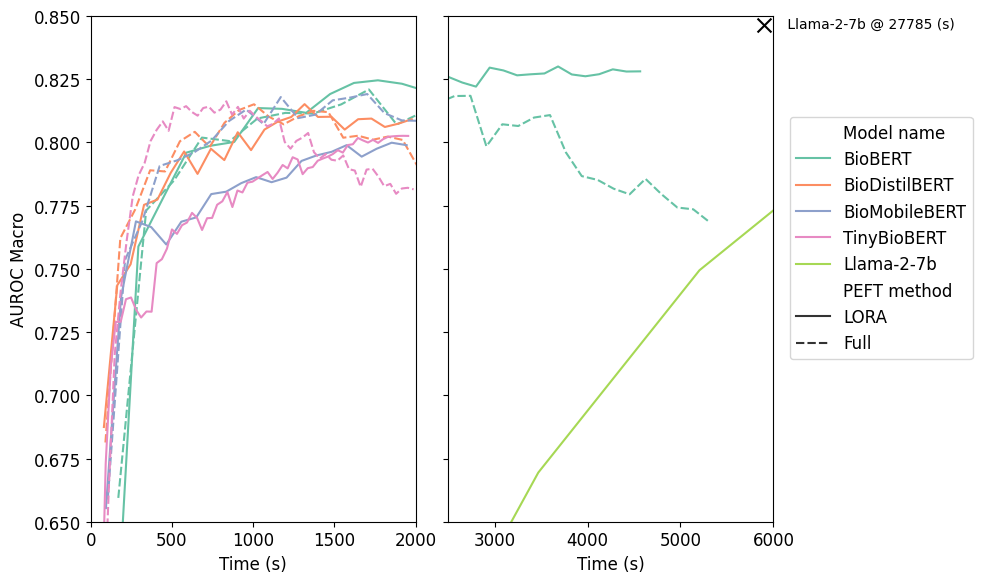

In [19]:

plot_df = fs_logs_df[['step', 'tag', 'value', 'wall_time', 'Model name', 'PEFT method']].query("`Model name` != 'RoBERTa-base'")
plot_df['Time (s)'] = plot_df.groupby(['Model name', 'PEFT method'])['wall_time'].transform(lambda x: x - x.min()).reindex().values
plot_df = plot_df.loc[plot_df['tag'].str.contains('eval/roc_auc') ]
plot_df.rename(columns={'value': 'AUROC_macro'}, inplace=True)
# fg = sns.FacetGrid(data=plot_df, col='PEFT method', sharey=True, sharex=True, 
#                    legend_out=True, aspect = 1, height = 4, 
#                    col_order=['Full', 'LORA'])
# fg.map_dataframe(sns.lineplot, x='rel_time', y='value', hue='Model name', 
#                  hue_order=plot_df['Model name'].unique(), palette='Set2')
# fg.add_legend()

fig, ax = plt.subplots(1, 2, figsize=(10, 6), sharey=True, sharex=False)
# ax = ax.flatten()
for ax_num, xrange in enumerate([(0, 2000), (2500, 6000)]):
    sns.lineplot(data=plot_df, x='Time (s)', y='AUROC_macro', 
                hue='Model name', 
                # hue_order=plot_df['Model name'].unique(), 
                hue_order = HUE_ORDER,
                style='PEFT method', style_order=['LORA','Full' ], 
                palette=PALETTE, ax=ax[ax_num], legend=ax_num==len(ax)-1)
    ax[ax_num].set_xlim(xrange)
    ax[ax_num].set_ylim((0.65, 0.85))
    
# add a single point showing the maximum value for Llama 2 on the right plot
max_llama = plot_df.loc[plot_df['Model name'] == 'Llama-2-7b'].query("AUROC_macro == AUROC_macro.max()")
# max_llama = plot_df.loc[plot_df['Model name'] == 'Llama-2-7b']['AUROC_macro'].max()
ax[1].scatter(5900, max_llama["AUROC_macro"], marker='x', s=100, c='black')
# add a label for this single point explaining the wall time at this point
# need to add white space to the right of the plot to fit the label
ax[1].text(6100, max_llama["AUROC_macro"]-0.001, f' Llama-2-7b @ {int(max_llama["Time (s)"].values[0])} (s) ',
           fontsize=10, 
           horizontalalignment='left')


    
# set y label to AUROC macro
ax[0].set_ylabel("AUROC Macro")

# move seaborn legend outside
plt.legend(bbox_to_anchor=(1.05, 0.8), loc=2, borderaxespad=0.)

plt.tight_layout()
# change whitespace between subplots
plt.subplots_adjust(wspace=0.1)

plt.savefig(f'{save_path}/time_budget_sensitivity.png', bbox_inches='tight', dpi=300)
# plt.savefig(f'time_budget_sensitivity.png', bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
# whole of llama model for sake of it

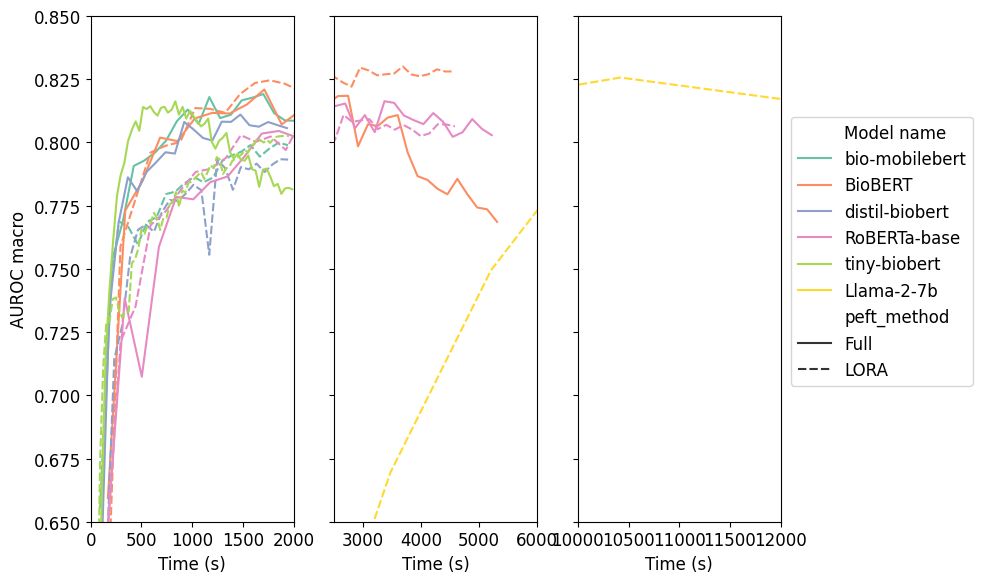

In [73]:
# can we do a 3 by plot with llama on its own at end - or add a single point with the max value of llama super imposed


fig, ax = plt.subplots(1, 3, figsize=(10, 6), sharey=True, sharex=False)
ax = ax.flatten()
for ax_num, xrange in enumerate([(0, 2000), (2500, 6000), (10000, 12000)]):
    sns.lineplot(data=plot_df, x='Time (s)', y='AUROC_macro', 
                hue='Model name', hue_order=plot_df['Model name'].unique(), 
                style='PEFT method', style_order=['Full', 'LORA'], 
                palette='Set2', ax=ax[ax_num], legend=ax_num==len(ax)-1)
    ax[ax_num].set_xlim(xrange)
    ax[ax_num].set_ylim((0.65, 0.85))
    
# add a single point showing the maximum value for Llama 2 on the right plot
# max_llama = plot_df.loc[plot_df['Model name'] == 'Llama-2-7b']['AUROC_macro'].max()
# ax[1].scatter(5990, max_llama, marker='x', s=150, c='black')

    
# set y label to AUROC macro
ax[0].set_ylabel("AUROC macro")

# move seaborn legend outside
plt.legend(bbox_to_anchor=(1.05, 0.8), loc=2, borderaxespad=0.)

plt.tight_layout()
# change whitespace between subplots
plt.subplots_adjust(wspace=0.15)

# plt.savefig(f'{save_path}/time_budget_sensitivity.png', bbox_inches='tight', dpi=300)
# plt.savefig(f'time_budget_sensitivity.png', bbox_inches='tight', dpi=300)
plt.show()

### combine budget to form a general efficiency metric


In [30]:
# tb_logs_dir = "/mnt/sdh/effecient_ml/tb_2000/logs/"
# # load in the few shot sensitivity logs
# tb_logs_df = read_tb_files(tb_logs_dir)

# # cls_results_df = produce_results_table(logs_df, 
# #                                 metric = ["f1",
# #                                         "accuracy",
# #                                         "precision",
# #                                         "recall",
# #                                         "auc", 
# #                                         "train/total_flos", "train/train_loss",
# #                                         "train/train_runtime", "train/train_samples_per_second",
# #                                         "train/train_steps_per_second"],
# #                                 mode = "all",
# #                                 groupby_list = ["Model name", "model_name_or_path", "task","few_shot_n", "PEFT method"],
# #                                 task_type = "SEQ_CLS",
# #                                 value_aggregate_method = "max",
# #                                 )

# # do same for fs_logs_df

# first combine fs_logs_df with cls_results_df in order to get maximum of each? not sure it will work or not

all_logs_df = pd.concat([logs_df, fs_logs_df])

cls_results_df = produce_results_table(all_logs_df, # fs_logs_df
                                metric = ["f1",
                                        "accuracy",
                                        "precision",
                                        "recall",
                                        "auc", 
                                        "train/total_flos", "train/train_loss",
                                        "train/train_runtime", "train/train_samples_per_second",
                                        "train/train_steps_per_second",
                                        "eval/samples_per_second",
                                        "eval/runtime"],
                                mode = "all",
                                groupby_list = ["Model name", "model_name_or_path", "task","few_shot_n", "PEFT method"],
                                task_type = "SEQ_CLS",
                                value_aggregate_method = "max",
                                )

/tmp/ipykernel_17609/1093808666.py:24: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  all_logs_df = pd.concat([logs_df, fs_logs_df])


In [129]:
all_logs_df.tag.unique()

array(['eval/accuracy', 'eval/f1_macro', 'eval/f1_micro',
       'eval/f1_weighted', 'eval/loss', 'eval/precision', 'eval/recall',
       'eval/roc_auc_macro', 'eval/runtime', 'eval/samples_per_second',
       'eval/steps_per_second', 'test/accuracy', 'test/f1_macro',
       'test/f1_micro', 'test/f1_weighted', 'test/loss', 'test/precision',
       'test/recall', 'test/roc_auc_macro', 'test/runtime',
       'test/samples_per_second', 'test/steps_per_second', 'train/epoch',
       'train/learning_rate', 'train/loss', 'train/total_flos',
       'train/train_loss', 'train/train_runtime',
       'train/train_samples_per_second', 'train/train_steps_per_second',
       'eval/f1', 'test/f1'], dtype=object)

In [131]:
cls_results_df.columns

Index(['index', 'Model name', 'model_name_or_path', 'task', 'few_shot_n',
       'PEFT method', 'accuracy', 'eval/accuracy', 'eval/f1_macro',
       'eval/f1_micro', 'eval/f1_weighted', 'eval/precision', 'eval/recall',
       'eval/roc_auc_macro', 'eval/runtime', 'eval/samples_per_second',
       'f1_macro', 'f1_micro', 'f1_weighted', 'precision', 'recall',
       'roc_auc_macro', 'train/total_flos', 'train/train_loss',
       'train/train_runtime', 'train/train_samples_per_second',
       'train/train_steps_per_second'],
      dtype='object', name='tag')

In [31]:
# add trainable params mapping
# tb_cls_results_df["PEFT_params"] = tb_cls_results_df.apply(lambda x: trainable_params_mapping.get(x['model_name_or_path'],{}).
#                                                      get(x['PEFT method'], {}).get('n_peft_params', np.NaN), axis=1)
# tb_cls_results_df['PEFT_params_perc'] = tb_cls_results_df.apply(lambda x: trainable_params_mapping.get(x['model_name_or_path'],{}).
#                                                      get(x['PEFT method'], {}).get('n_peft_params_perc', np.NaN), axis=1)
# tb_cls_results_df['Total_params'] = tb_cls_results_df.apply(lambda x: trainable_params_mapping.get(x['model_name_or_path'],{}).
#                                                      get(x['PEFT method'], {}).get('total_params', np.NaN), axis=1)
# tb_cls_results_df['full_model_size_GB'] = tb_cls_results_df.apply(lambda x: trainable_params_mapping.get(x['model_name_or_path'],{}).
#                                                         get(x['PEFT method'], {}).get('model_size_GB', np.NaN), axis=1)
# tb_cls_results_df['full_model_size_MB'] = tb_cls_results_df.apply(lambda x: trainable_params_mapping.get(x['model_name_or_path'],{}).
#                                                         get(x['PEFT method'], {}).get('model_size_MB', np.NaN), axis=1)
# tb_cls_results_df['peft_full_model_size_GB'] = tb_cls_results_df.apply(lambda x: trainable_params_mapping.get(x['model_name_or_path'],{}).
#                                                         get(x['PEFT method'], {}).get('peft_model_size_GB', np.NaN), axis=1)
# tb_cls_results_df['peft_full_model_size_MB'] = tb_cls_results_df.apply(lambda x: trainable_params_mapping.get(x['model_name_or_path'],{}).
#                                                         get(x['PEFT method'], {}).get('peft_model_size_MB', np.NaN), axis=1)


cls_results_df["PEFT_params"] = cls_results_df.apply(lambda x: trainable_params_mapping.get(x['model_name_or_path'],{}).
                                                     get(x['PEFT method'], {}).get('n_peft_params', np.NaN), axis=1)
cls_results_df['PEFT_params_perc'] = cls_results_df.apply(lambda x: trainable_params_mapping.get(x['model_name_or_path'],{}).
                                                     get(x['PEFT method'], {}).get('n_peft_params_perc', np.NaN), axis=1)
cls_results_df['Total_params'] = cls_results_df.apply(lambda x: trainable_params_mapping.get(x['model_name_or_path'],{}).
                                                     get(x['PEFT method'], {}).get('total_params', np.NaN), axis=1)
cls_results_df['full_model_size_GB'] = cls_results_df.apply(lambda x: trainable_params_mapping.get(x['model_name_or_path'],{}).
                                                        get(x['PEFT method'], {}).get('model_size_GB', np.NaN), axis=1)
cls_results_df['full_model_size_MB'] = cls_results_df.apply(lambda x: trainable_params_mapping.get(x['model_name_or_path'],{}).
                                                        get(x['PEFT method'], {}).get('model_size_MB', np.NaN), axis=1)
cls_results_df['peft_full_model_size_GB'] = cls_results_df.apply(lambda x: trainable_params_mapping.get(x['model_name_or_path'],{}).
                                                        get(x['PEFT method'], {}).get('peft_model_size_GB', np.NaN), axis=1)
cls_results_df['peft_full_model_size_MB'] = cls_results_df.apply(lambda x: trainable_params_mapping.get(x['model_name_or_path'],{}).
                                                        get(x['PEFT method'], {}).get('peft_model_size_MB', np.NaN), axis=1)



either we use the tb logs which have slightly optimised results but will have a fixed train time or we use cls_results

In [156]:
cls_results_df.shape

(136, 35)

In [104]:
cls_results_df.query("`Model name` == 'BioBERT' & task == 'MIMIC LoS' & few_shot_n == 250")["train/train_runtime"]

16    3420.683350
17    2786.532471
18    2799.647949
19    2626.601074
Name: train/train_runtime, dtype: float64

In [24]:
cls_results_df["train/total_flos"]

0      1.178996e+16
1      1.183130e+16
2      1.283238e+16
3      1.287760e+16
4      3.751990e+16
           ...     
221    1.889166e+16
222    2.108343e+16
223    2.109995e+16
224    2.115628e+16
225    2.108418e+16
Name: train/total_flos, Length: 226, dtype: float64

In [26]:
# get total flos for each model type
temp_df = cls_results_df.loc[cls_results_df['PEFT method'] == 'LORA']
temp_df['train/total_flos_scaled'] = temp_df['train/total_flos']/1e12
temp_df.groupby(["Model name"])["train/total_flos_scaled"].mean().reset_index().sort_values("train/total_flos_scaled", ascending=False)

/tmp/ipykernel_63639/4168866070.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['train/total_flos_scaled'] = temp_df['train/total_flos']/1e12


,Model name,train/total_flos_scaled
8,Llama-2-7b,1.398980e+06
10,RoBERTa-base,5.129128e+04
1,BioBERT,2.843159e+04
2,BioClinicalBERT,2.627201e+04
0,BERTbase,2.609522e+04
5,ClinicalDistilBERT,1.343836e+04
3,BioDistilBERT,1.334017e+04
7,DistilBERTbase,1.334017e+04
14,distil-biobert,1.324082e+04
4,BioMobileBERT,6.265844e+03


In [32]:
# budget metrics to consider
budget_metrics = ["train/train_runtime", "train/total_flos", "full_model_size_MB",]
# create new efficiency metric as a linear combination of the above

# standardise each metric
for metric in budget_metrics:
    cls_results_df[f"{metric}_scaled"] = (cls_results_df[metric] - cls_results_df[metric].min()) / (cls_results_df[metric].max() - cls_results_df[metric].min())
    

cls_results_df["raw_efficiency"] = cls_results_df["train/train_runtime_scaled"] + cls_results_df["train/total_flos_scaled"] + cls_results_df["full_model_size_MB_scaled"]


# rescale effiency to be between 0 and 1 and round to 3 dp
 
# cls_results_df["efficiency"] = (1 - (cls_results_df["raw_efficiency"] - cls_results_df["raw_efficiency"].min()) / (cls_results_df["raw_efficiency"].max() - cls_results_df["raw_efficiency"].min())).round(3)
cls_results_df["efficiency"] = (1 - cls_results_df["raw_efficiency"]).round(3)


# take log of raw efficiency
cls_results_df["log_efficiency"] = (100 - np.log(cls_results_df["raw_efficiency"]))/100



# now rescale between 0 and 1
cls_results_df["log_efficiency"] = (cls_results_df["log_efficiency"] - cls_results_df["log_efficiency"].min()) / (cls_results_df["log_efficiency"].max() - cls_results_df["log_efficiency"].min())

# or just scaled flops?
cls_results_df['total_flos_scaled'] = cls_results_df['train/total_flos']/1e12

# take log of the total flos scaled
cls_results_df["log_total_flos_scaled"] = (100 - np.log(cls_results_df["total_flos_scaled"]))

In [25]:
print(float(1e-12))

1e-12


In [205]:
# find row where effiency is not nan
cls_results_df[cls_results_df["efficiency"].notna()]["Model name"]

0              BERT-base
1              BERT-base
2              BERT-base
3              BERT-base
4              BERT-base
             ...        
131    tiny-clinicalbert
132    tiny-clinicalbert
133    tiny-clinicalbert
134    tiny-clinicalbert
135    tiny-clinicalbert
Name: Model name, Length: 136, dtype: object

In [106]:
cls_results_df["model_name_or_path"].unique()

array(['bert-base-uncased', 'dmis-lab/biobert-v1.1',
       'emilyalsentzer/Bio_ClinicalBERT', 'nlpie/bio-distilbert-uncased',
       'nlpie/bio-mobilebert', 'nlpie/clinical-distilbert',
       'nlpie/clinical-mobilebert', 'distilbert-base-uncased',
       'meta-llama/Llama-2-7b-hf', 'google/mobilebert-uncased',
       'roberta-base', 'huawei-noah/TinyBERT_General_4L_312D',
       'nlpie/tiny-biobert', 'nlpie/tiny-clinicalbert',
       'nlpie/distil-biobert'], dtype=object)

In [107]:
cls_results_df["Model name"].unique()

array(['BERTbase', 'BioBERT', 'BioClinicalBERT', 'BioDistilBERT',
       'BioMobileBERT', 'ClinicalDistilBERT', 'ClinicalMobileBERT',
       'DistilBERTbase', 'Llama-2-7b', 'MobileBERT', 'RoBERTa-base',
       'TinyBERT', 'TinyBioBERT', 'TinyClinicalBERT', 'distil-biobert'],
      dtype=object)

In [207]:
cls_results_df.query("`Model name` == 'Llama-2-7b'")

tag,index,Model name,model_name_or_path,task,few_shot_n,peft_method,accuracy,eval/accuracy,eval/f1_macro,eval/f1_micro,...,PEFT_params,PEFT_params_perc,Total_params,full_model_size_GB,full_model_size_MB,peft_full_model_size_GB,peft_full_model_size_MB,raw_efficiency,efficiency,log_efficiency
40,40,Llama-2-7b,meta-llama/Llama-2-7b-hf,mimic-mp,250.0,LORA,0.898188,0.902812,0.669392,0.902812,...,4194304,0.063479,6607351808,24.614304,25205.046875,0.015656,16.03125,1.398980e+18,0.0,0.582177


In [33]:
PEFT_methods_to_plot = ['LORA', 'Full']
ef_plot_df = cls_results_df.loc[cls_results_df['few_shot_n'] == 250].copy()
ef_plot_df =  ef_plot_df.loc[ef_plot_df['task'] != 'mednli']
ef_plot_df = ef_plot_df.loc[ef_plot_df['Model name'].isin(
    ['BioBERT','BioDistilBERT','BioMobileBERT', 'TinyBioBERT', 'RoBERTa-base','Llama-2-7b'])] # , 'distil-biobert', 'bio-mobilebert', 'Bio-ClinicalBERT', 'tiny-biobert'
ef_plot_df = ef_plot_df.loc[ef_plot_df['PEFT method'].isin(PEFT_methods_to_plot)]
ef_plot_df.sort_values(['Model name', 'PEFT method', 'task', 'few_shot_n', 'f1_macro'], 
                            ascending=False, inplace=True)
ef_plot_df.drop_duplicates(['Model name', 'PEFT method', 'task', 'few_shot_n'], inplace=True)
ef_plot_df['roc_auc_macro'] = ef_plot_df['roc_auc_macro'].apply(lambda x: round(x, 3)).values

In [126]:
ef_plot_df.columns

Index(['index', 'Model name', 'model_name_or_path', 'task', 'few_shot_n',
       'PEFT method', 'accuracy', 'eval/accuracy', 'eval/f1_macro',
       'eval/f1_micro', 'eval/f1_weighted', 'eval/precision', 'eval/recall',
       'eval/roc_auc_macro', 'f1_macro', 'f1_micro', 'f1_weighted',
       'precision', 'recall', 'roc_auc_macro', 'train/total_flos',
       'train/train_loss', 'train/train_runtime',
       'train/train_samples_per_second', 'train/train_steps_per_second',
       'PEFT_params', 'PEFT_params_perc', 'Total_params', 'full_model_size_GB',
       'full_model_size_MB', 'peft_full_model_size_GB',
       'peft_full_model_size_MB'],
      dtype='object', name='tag')

In [26]:
ef_plot_df.query(" `task` == 'MIMIC MP'")[[ "Model name",
                                            "PEFT method",
                                           "eval/roc_auc_macro", "roc_auc_macro", "train/train_runtime",
                                           "train/total_flos","eval/runtime", "full_model_size_MB", "efficiency",
                                           "raw_efficiency", "log_efficiency"]]

tag,Model name,PEFT method,eval/roc_auc_macro,roc_auc_macro,train/train_runtime,train/total_flos,eval/runtime,full_model_size_MB,efficiency,raw_efficiency,log_efficiency
112,TinyBioBERT,LORA,0.802615,0.804,1970.063843,5.852876e+15,10.747100,52.928017,0.996,5.852876e+15,0.712579
110,TinyBioBERT,Full,0.816259,0.804,2000.935547,4.771707e+15,11.513100,52.928017,0.997,4.771707e+15,0.739152
90,RoBERTa-base,LORA,0.820007,0.825,4722.450195,5.129128e+16,40.207500,475.491219,0.964,5.129128e+16,0.430155
89,RoBERTa-base,Full,0.851135,0.806,5439.417969,5.025174e+16,38.700001,475.491219,0.965,5.025174e+16,0.432819
80,Llama-2-7b,LORA,0.846324,0.838,43390.453125,1.398980e+18,718.354309,25205.046875,0.000,1.398980e+18,0.000000
55,BioMobileBERT,LORA,0.799893,0.816,2001.018555,1.008930e+16,25.156300,93.776375,0.993,1.008930e+16,0.641727
53,BioMobileBERT,Full,0.819139,0.811,2355.455566,9.980649e+15,25.775200,93.776375,0.993,9.980649e+15,0.643135
43,BioDistilBERT,LORA,0.815145,0.822,2000.842651,2.148109e+16,23.411900,255.413094,0.985,2.148109e+16,0.543399
41,BioDistilBERT,Full,0.815090,0.803,2013.183594,2.108343e+16,22.792801,255.413094,0.985,2.108343e+16,0.545831
22,BioBERT,LORA,0.830042,0.832,4659.600098,5.059875e+16,40.369499,413.176765,0.964,5.059875e+16,0.431924


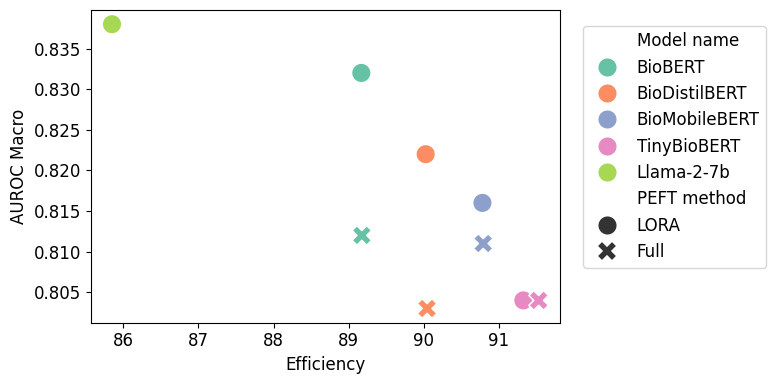

In [53]:
task = "MIMIC MP"
metric = "roc_auc_macro"
fig, ax = plt.subplots(figsize=(8,4))
        # lineplot looking at few_shot_n on x-axis and f1_macro on y-axis
sns.scatterplot(data = ef_plot_df.query("task == @task & `Model name` != 'RoBERTa-base'"),
        x = "log_total_flos_scaled", # log_total_flos_scaled | log_efficiency
        y = metric,
        hue = "Model name",
        hue_order = HUE_ORDER,
        style = "PEFT method",
        style_order = ['LORA', 'Full'],
        ax = ax,
        legend = True,
        palette = PALETTE,
        s = 200
        )

# do pointplot instead
# sns.pointplot(data = fs_cls_results_df.query("PEFT method == 'LORA'"),
#              x = "few_shot_n",
#              y = metric,
#              hue = "Model name",
#              linestyles= "--",
#              ax = ax,
#              legend = True
#              )

# change y label based on metric mapping
ax.set_ylabel(metric_name_mapping[metric])
# plt.legend(loc='upper right', 
#         bbox_to_anchor=(1.0, -0.2),  
#         fancybox=True, shadow=False, 
#         ncol=3)


plt.legend(bbox_to_anchor=(1.05, 0.95), loc=2, borderaxespad=0.)
# rotate x tick labels by 45
plt.xticks(rotation=0
            )
plt.xlabel("Efficiency")

# fig.suptitle("PEFT Method", x=0.55, y=0.4, ha='center')
# plt.suptitle(f"MIMIC-III ICD9-Triage task - Frozen LLM")
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(wspace=0.25)
plt.tight_layout()
# save
# plt.savefig(f'{save_path}/effiency_{task}_{metric}.png', bbox_inches='tight', dpi = 300)

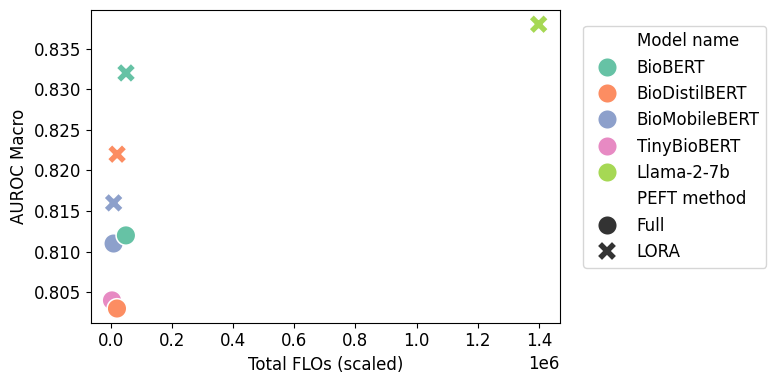

In [21]:
# just scaled FLOs
task = "MIMIC MP"
metric = "roc_auc_macro"
fig, ax = plt.subplots(figsize=(8,4))
        # lineplot looking at few_shot_n on x-axis and f1_macro on y-axis
sns.scatterplot(data = ef_plot_df.query("task == @task & `Model name` != 'RoBERTa-base'"),
        x = "total_flos_scaled",
        y = metric,
        hue = "Model name",
        hue_order = HUE_ORDER,
        style = "PEFT method",
        style_order = ['Full', 'LORA'],
        ax = ax,
        legend = True,
        palette = PALETTE,
        s = 200
        )

# do pointplot instead
# sns.pointplot(data = fs_cls_results_df.query("PEFT method == 'LORA'"),
#              x = "few_shot_n",
#              y = metric,
#              hue = "Model name",
#              linestyles= "--",
#              ax = ax,
#              legend = True
#              )

# change y label based on metric mapping
ax.set_ylabel(metric_name_mapping[metric])
# plt.legend(loc='upper right', 
#         bbox_to_anchor=(1.0, -0.2),  
#         fancybox=True, shadow=False, 
#         ncol=3)


plt.legend(bbox_to_anchor=(1.05, 0.95), loc=2, borderaxespad=0.)
# rotate x tick labels by 45
plt.xticks(rotation=0
            )
plt.xlabel("Total FLOs (scaled)")

# fig.suptitle("PEFT Method", x=0.55, y=0.4, ha='center')
# plt.suptitle(f"MIMIC-III ICD9-Triage task - Frozen LLM")
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(wspace=0.25)
plt.tight_layout()
# save
plt.savefig(f'{save_path}/totalFLOs_{task}_{metric}.png', bbox_inches='tight', dpi = 300)

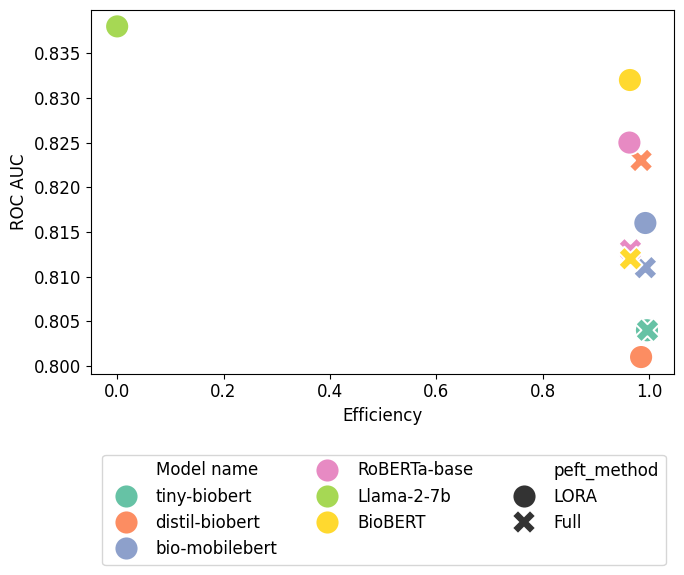

In [212]:
# raw efficiency 
task = "MIMIC MP"
metric = "roc_auc_macro"
fig, ax = plt.subplots(figsize=(7,6))
        # lineplot looking at few_shot_n on x-axis and f1_macro on y-axis
sns.scatterplot(data = ef_plot_df.query("task == @task"),
        x = "efficiency",
        y = metric,
        hue = "Model name",
        
        style = "PEFT method",
        ax = ax,
        legend = True,
        palette = "Set2",
        s = 300
        )

# do pointplot instead
# sns.pointplot(data = fs_cls_results_df.query("PEFT method == 'LORA'"),
#              x = "few_shot_n",
#              y = metric,
#              hue = "Model name",
#              linestyles= "--",
#              ax = ax,
#              legend = True
#              )

# change y label based on metric mapping
ax.set_ylabel(metric_name_mapping[metric])
plt.legend(loc='upper right', 
        bbox_to_anchor=(1.0, -0.2),  
        fancybox=True, shadow=False, 
        ncol=3)
# rotate x tick labels by 45
plt.xticks(rotation=0
            )
plt.xlabel("Efficiency")

# fig.suptitle("PEFT Method", x=0.55, y=0.4, ha='center')
# plt.suptitle(f"MIMIC-III ICD9-Triage task - Frozen LLM")
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(wspace=0.25)
plt.tight_layout()
# save
# plt.savefig(f'{save_path}/effiency_{task}_{metric}.png', bbox_inches='tight', dpi = 300)

### Lora Rank 

In [65]:
lr_logs_dir = "/mnt/sdd/efficient_ml_data/saved_models/peft/lora_rank_analysis/logs/" # need last backslash
lora_logs_df = read_tb_files(lr_logs_dir)

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/40434 [00:00<?, ?it/s]

In [67]:
lora_logs_df.head()

,step,tag,value,dir_name,cache_dir,ckpt_save_dir,combined_val_test_sets,custom_model_name,data_dir,dropout,...,test_file,text_col,text_column,train_batch_size,training_data_dir,training_file,validation_file,warmup_steps,save_adapter,Model name
0,299,eval/accuracy,0.924213,ICD9-Triage/full/bio-mobilebert/LORA/01-09-202...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/l...,False,bio-mobilebert,,0.1,...,test.csv,text,text,32,/mnt/sdd/efficient_ml_data/datasets/icd9-triag...,train.csv,valid.csv,100,NaN,bio-mobilebert
1,598,eval/accuracy,0.933847,ICD9-Triage/full/bio-mobilebert/LORA/01-09-202...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/l...,False,bio-mobilebert,,0.1,...,test.csv,text,text,32,/mnt/sdd/efficient_ml_data/datasets/icd9-triag...,train.csv,valid.csv,100,NaN,bio-mobilebert
2,897,eval/accuracy,0.942197,ICD9-Triage/full/bio-mobilebert/LORA/01-09-202...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/l...,False,bio-mobilebert,,0.1,...,test.csv,text,text,32,/mnt/sdd/efficient_ml_data/datasets/icd9-triag...,train.csv,valid.csv,100,NaN,bio-mobilebert
3,1196,eval/accuracy,0.938022,ICD9-Triage/full/bio-mobilebert/LORA/01-09-202...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/l...,False,bio-mobilebert,,0.1,...,test.csv,text,text,32,/mnt/sdd/efficient_ml_data/datasets/icd9-triag...,train.csv,valid.csv,100,NaN,bio-mobilebert
4,1495,eval/accuracy,0.942197,ICD9-Triage/full/bio-mobilebert/LORA/01-09-202...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/l...,False,bio-mobilebert,,0.1,...,test.csv,text,text,32,/mnt/sdd/efficient_ml_data/datasets/icd9-triag...,train.csv,valid.csv,100,NaN,bio-mobilebert


In [68]:
lora_logs_df.columns

Index(['step', 'tag', 'value', 'dir_name', 'cache_dir', 'ckpt_save_dir',
       'combined_val_test_sets', 'custom_model_name', 'data_dir', 'dropout',
       'eight_bit_training', 'eval_batch_size', 'eval_data_dir',
       'eval_every_steps', 'eval_few_shot_n', 'evaluation_strategy',
       'fast_dev_run', 'few_shot_n', 'label_col', 'label_name',
       'learning_rate', 'loader_workers', 'log_every_steps', 'log_save_dir',
       'lora_alpha', 'lora_dropout', 'lora_rank', 'max_epochs', 'max_length',
       'metric_mode', 'model_name_or_path', 'monitor', 'n_trainable_params',
       'no_cuda', 'num_virtual_tokens', 'optimizer', 'patience', 'peft_method',
       'pretrained_models_dir', 'remove_columns', 'save_every_steps',
       'saving_strategy', 'sensitivity', 'task', 'task_to_keys', 'task_type',
       'test_file', 'text_col', 'text_column', 'train_batch_size',
       'training_data_dir', 'training_file', 'validation_file', 'warmup_steps',
       'save_adapter', 'Model name'],
      d

In [69]:
lr_cls_results_df = produce_results_table(lora_logs_df, 
                                        metric = ["f1",
                                                  "accuracy",
                                                  "precision",
                                                  "recall",
                                                  "auc", 
                                                   "train/total_flos", "train/train_loss",
                                                "train/train_runtime", "train/train_samples_per_second",
                                                "train/train_steps_per_second"],
                                        mode = "all",
                                        groupby_list = ["Model name", "model_name_or_path", "task","few_shot_n", "PEFT method", "lora_rank"],
                                        task_type = "SEQ_CLS",
                                        value_aggregate_method = "max",
                                        )

In [71]:
lr_cls_results_df.head()

tag,index,Model name,model_name_or_path,task,few_shot_n,peft_method,lora_rank,accuracy,f1_macro,f1_micro,f1_weighted,precision,recall,roc_auc_macro,train/total_flos,train/train_loss,train/train_runtime,train/train_samples_per_second,train/train_steps_per_second
0,0,BioBERT,dmis-lab/biobert-v1.1,mimic-mp,250,LORA,128,0.897107,0.641178,0.897107,0.880251,0.739413,0.611306,0.805939,4.418444e+16,0.284852,3201.988525,53.020000,1.658
1,1,RoBERTa-base,roberta-base,mimic-mp,250,LORA,8,0.898941,0.634734,0.898941,0.877630,0.837479,0.647711,0.813773,4.231030e+16,0.276593,3103.336914,54.706001,1.711
2,2,RoBERTa-base,roberta-base,mimic-mp,250,LORA,16,0.894458,0.472145,0.894458,0.844627,0.447229,0.500000,0.532313,4.245449e+16,0.338095,3097.967773,54.799999,1.714
3,3,RoBERTa-base,roberta-base,mimic-mp,250,LORA,32,0.899144,0.632771,0.899144,0.878094,0.758052,0.618167,0.815220,4.274288e+16,0.275554,3103.418213,54.703999,1.711
4,4,RoBERTa-base,roberta-base,mimic-mp,250,LORA,64,0.897107,0.624484,0.897107,0.875041,0.733170,0.639778,0.813521,4.331965e+16,0.276114,3128.766602,54.261002,1.697


In [72]:
PEFT_methods_to_plot

['PREFIX_TUNING', 'IA3', 'LORA', 'Full']

In [74]:
plot_df = lr_cls_results_df

plot_df = plot_df.loc[plot_df['Model name'].isin(
    ['BioBERT','distil-biobert','bio-mobilebert', 'tiny-biobert'])] # , 'distil-biobert', 'bio-mobilebert', 'Bio-ClinicalBERT', 'tiny-biobert'
plot_df = plot_df.loc[plot_df['PEFT method'].isin(PEFT_methods_to_plot)]
plot_df.sort_values(['Model name', 'PEFT method', 'task', 'few_shot_n', 'f1_macro'], 
                            ascending=False, inplace=True)
# plot_df.drop_duplicates(['Model name', 'PEFT method', 'task', 'few_shot_n'], inplace=True)
plot_df['roc_auc_macro'] = plot_df['roc_auc_macro'].apply(lambda x: round(x, 3)).values

In [80]:
plot_df["Model name"].unique()

array(['tiny-biobert', 'distil-biobert', 'bio-mobilebert', 'BioBERT'],
      dtype=object)

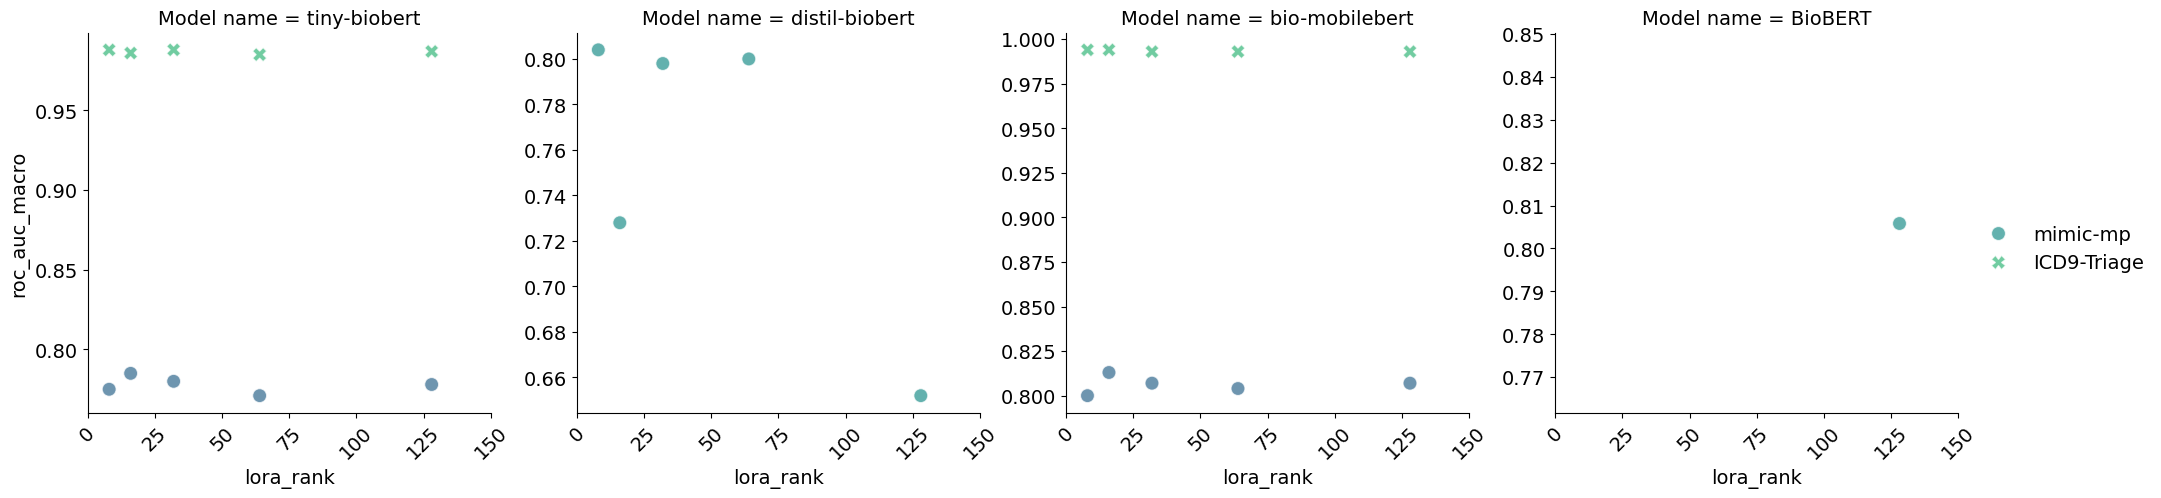

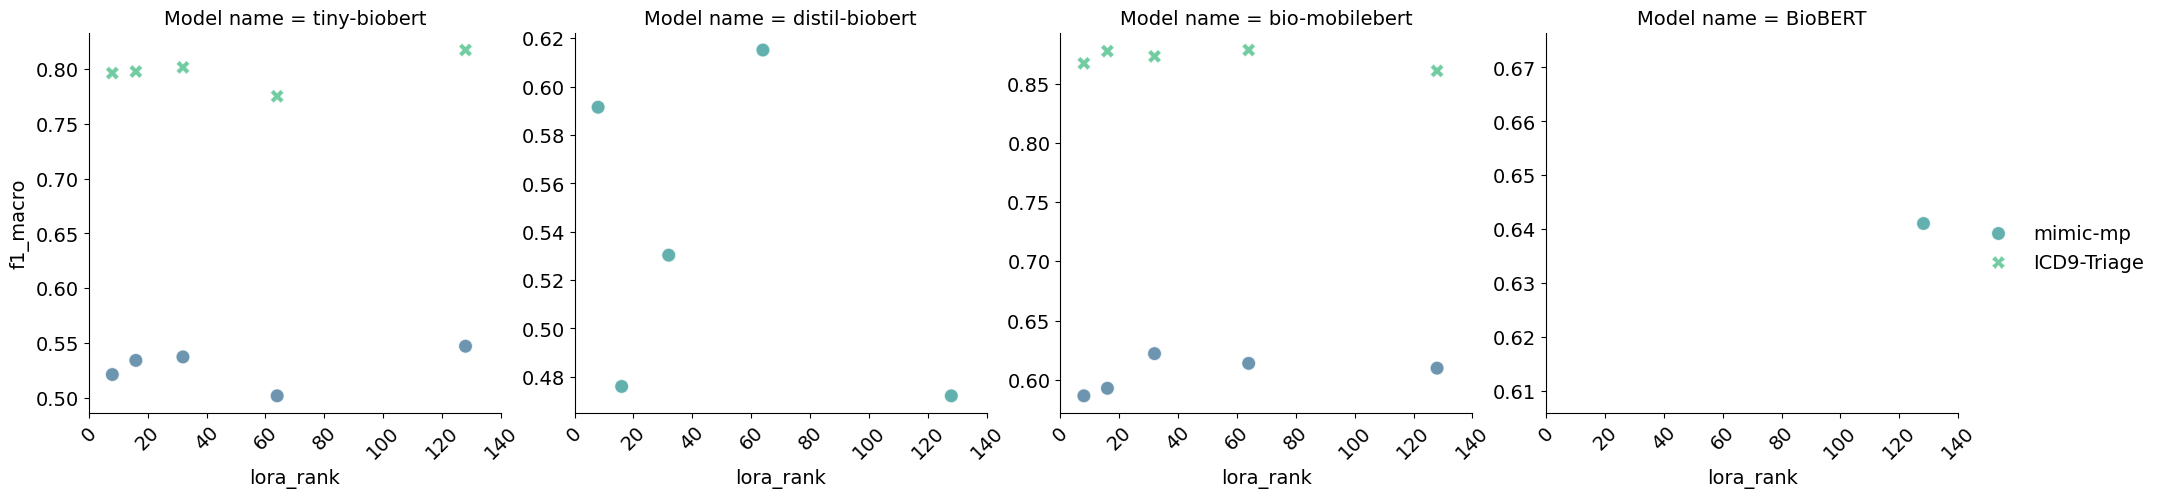

In [86]:
metrics = ['roc_auc_macro', 'f1_macro']

for metric in metrics:
    # change font size
    
    fg = sns.FacetGrid(data=plot_df, col='Model name', sharey=False, 
                       sharex=True, legend_out=True, aspect=1, height=5)
    fg.map_dataframe(sns.scatterplot, x='lora_rank', y=metric, style = 'task',
                     hue='task', palette='viridis', s=100, alpha=0.7,
                     )
    # fg.map_dataframe(sns.lineplot, x='log(n_trainable_params)', y=metric, style='PEFT method', 
    #                  hue='Model name', palette='viridis', alpha=0.7,
    #                  style_order=['Full', 'PREFIX_TUNING', 'LORA', 'PROMPT_TUNING'])
    fg.add_legend()
    fg.set_xticklabels(rotation = 45)
    plt.savefig(f'{save_path}/{metric}_PEFT methods_lora_rank.png', bbox_inches='tight')
    plt.show()


# NER tasks

In [17]:
ner_results_df.head()

tag,index,Model name,model_name_or_path,task,few_shot_n,peft_method,accuracy,eval/accuracy,eval/f1,eval/precision,eval/recall,f1,precision,recall
0,0,BERT-base,bert-base-uncased,i2b2-2010-NER,250.0,Full,0.927843,0.938022,0.840604,0.835983,0.847973,0.806471,0.807763,0.805184
1,1,BERT-base,bert-base-uncased,i2b2-2010-NER,250.0,LORA,0.893014,0.908728,0.691431,0.691139,0.701014,0.672783,0.675753,0.669838
2,2,BERT-base,bert-base-uncased,i2b2-2012-NER,250.0,Full,0.896997,0.904368,0.815264,0.797377,0.836096,0.792244,0.771275,0.814386
3,3,BERT-base,bert-base-uncased,i2b2-2012-NER,250.0,LORA,0.862989,0.867565,0.717303,0.700615,0.734807,0.697306,0.676653,0.719260
4,4,BERT-base,bert-base-uncased,i2b2-2014-NER,250.0,Full,0.997375,0.997420,0.973744,0.974541,0.972948,0.973636,0.975124,0.972154


In [18]:
ner_results_df["Model name"].unique()

array(['BERT-base', 'Bio-ClinicalBERT', 'BioBERT', 'DistilBERT-base',
       'TinyBERT_General_4L_312D', 'bio-distilbert-uncased',
       'bio-mobilebert', 'clinical-distilbert', 'clinical-mobilebert',
       'distil-biobert', 'mobilebert-uncased', 'tiny-biobert',
       'tiny-clinicalbert'], dtype=object)

In [50]:
PEFT_methods_to_plot = [ "IA3","LORA", "Full"]

In [27]:
plot_df = ner_results_df.loc[ner_results_df['few_shot_n'] == 250].copy()

plot_df = plot_df.loc[plot_df['Model name'].isin(
    [
    'BioBERT',
    # 'distil-biobert',
    'BioDistilBERT',
    'BioMobileBERT',
    'TinyBioBERT'])]  # , 'distil-biobert', 'bio-mobilebert', 'Bio-ClinicalBERT', 'tiny-biobert'
plot_df = plot_df.loc[plot_df['PEFT method'].isin(PEFT_methods_to_plot)]
plot_df.sort_values(['Model name', 'PEFT method', 'task', 'few_shot_n', 'f1'], 
                            ascending=False, inplace=True)
# plot_df.drop_duplicates(['Model name', 'PEFT method', 'task', 'few_shot_n'], inplace=True)


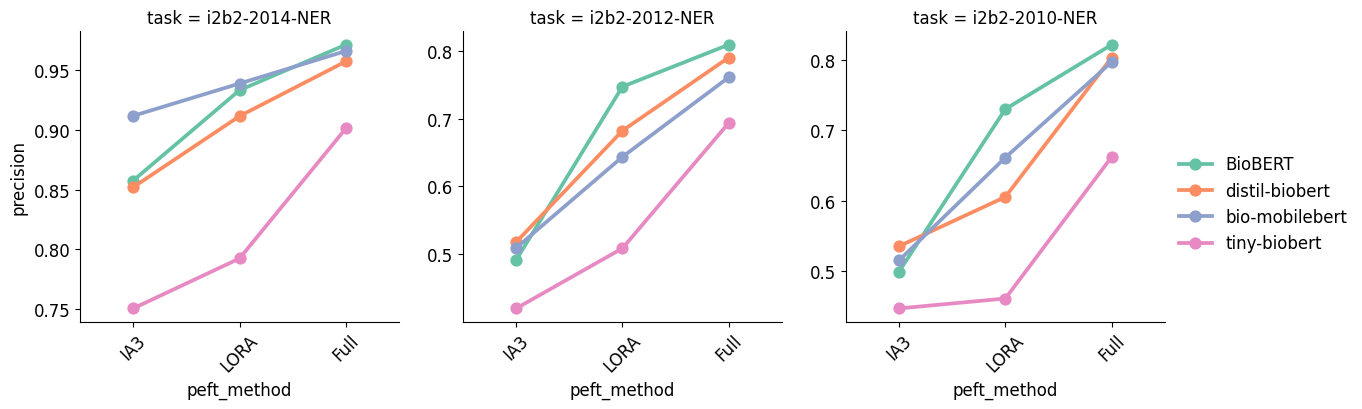

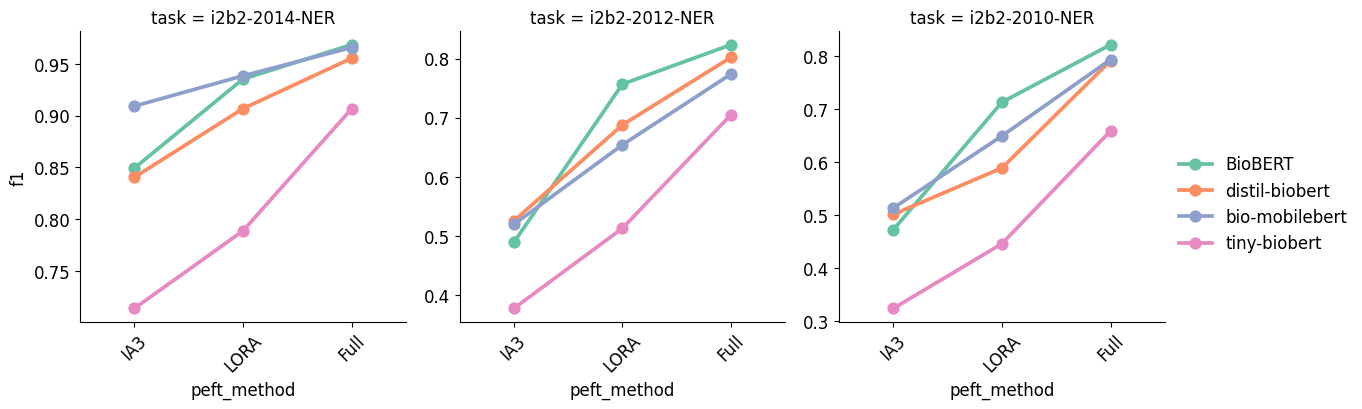

In [149]:
metrics = ['precision', 'f1']

  
for metric in metrics:
    
    fg = sns.FacetGrid(data=plot_df, col='task', sharey=False, legend_out=True, aspect = 1, height = 4)
    fg.map_dataframe(sns.pointplot, x='PEFT method', y=metric, hue='Model name', 
                    order=PEFT_methods_to_plot, 
                    hue_order = ['BioBERT','distil-biobert','bio-mobilebert', 'tiny-biobert'],
                    palette='Set2')
    fg.add_legend()
    # handles, labels = fg.axes[0,0].get_legend_handles_labels()
    # fg.fig.legend(handles, labels)
    # sns.move_legend(ax, "upper left", bbox_to_anchor=(1.02, 0.4))
    fg.set_xticklabels(rotation = 45)
    # plt.savefig(f'{save_path}/NER_{metric}_PEFT methods.png', bbox_inches='tight')
    plt.show()

In [19]:
ner_results_df

tag,index,Model name,model_name_or_path,task,few_shot_n,PEFT method,random_seed,accuracy,eval/accuracy,eval/f1,eval/precision,eval/recall,f1,precision,recall
0,0,BioBERT,dmis-lab/biobert-v1.1,i2b2-2010-NER,250.0,IA3,12.0,0.830870,0.851808,0.477532,0.492891,0.464101,0.475029,0.502972,0.450027
1,1,BioBERT,dmis-lab/biobert-v1.1,i2b2-2010-NER,250.0,IA3,34.0,0.829707,0.850812,0.473423,0.490476,0.458179,0.470815,0.498927,0.445703
2,2,BioBERT,dmis-lab/biobert-v1.1,i2b2-2010-NER,250.0,IA3,56.0,0.831513,0.850911,0.463846,0.482786,0.446336,0.473074,0.502161,0.447172
3,3,BioBERT,dmis-lab/biobert-v1.1,i2b2-2010-NER,250.0,LORA,12.0,0.905214,0.921422,0.719969,0.745051,0.696521,0.696060,0.713149,0.679772
4,4,BioBERT,dmis-lab/biobert-v1.1,i2b2-2010-NER,250.0,LORA,34.0,0.902597,0.923314,0.723340,0.742212,0.705403,0.693984,0.707952,0.680555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,92,TinyBioBERT,nlpie/tiny-biobert,i2b2-2014-NER,250.0,IA3,34.0,0.970365,0.970553,0.713376,0.749199,0.680822,0.712582,0.746793,0.681368
93,93,TinyBioBERT,nlpie/tiny-biobert,i2b2-2014-NER,250.0,IA3,56.0,0.970563,0.970278,0.711907,0.748859,0.680822,0.714500,0.749480,0.682641
94,94,TinyBioBERT,nlpie/tiny-biobert,i2b2-2014-NER,250.0,LORA,12.0,0.983310,0.982972,0.819464,0.822859,0.816096,0.821379,0.827076,0.815761
95,95,TinyBioBERT,nlpie/tiny-biobert,i2b2-2014-NER,250.0,LORA,34.0,0.981364,0.981392,0.799694,0.798634,0.806678,0.796691,0.797751,0.795633


In [30]:
# F1 micro for I2B2-2010-RE | I2B2-2012-NER | I2B2-2014-NER
metric = "f1"
stat = "median"
task = "i2b2-2014-NER"
# plot_df.query("task == @task").groupby(['Model name', 'PEFT method', 'task', 'few_shot_n'])[metric].median().round(3).reset_index().pivot_table(index=['Model name', 'PEFT method'],
#                                                                                                         columns=['task',],
#                                                                                                         values=metric).reset_index()


plot_df.query("task == @task").groupby(['Model name', 'PEFT method', 'task']).agg(f1_micro=(metric, stat), 
                  std=(metric, "std")
                  ).round(3).reset_index()

,Model name,PEFT method,task,f1_micro,std
0,BioBERT,Full,i2b2-2014-NER,0.967,0.001
1,BioBERT,IA3,i2b2-2014-NER,0.850,0.001
2,BioBERT,LORA,i2b2-2014-NER,0.935,0.000
3,BioDistilBERT,Full,i2b2-2014-NER,0.967,0.001
4,BioDistilBERT,IA3,i2b2-2014-NER,0.883,0.000
5,BioDistilBERT,LORA,i2b2-2014-NER,0.940,0.001
6,BioMobileBERT,Full,i2b2-2014-NER,0.966,0.000
7,BioMobileBERT,IA3,i2b2-2014-NER,0.908,0.000
8,BioMobileBERT,LORA,i2b2-2014-NER,0.941,0.001
9,TinyBioBERT,Full,i2b2-2014-NER,0.906,0.003


In [22]:
# make a latex table from this

ner_paper_results = plot_df.groupby(['Model name', 'PEFT method', 'task'])['f1'].max().reset_index().pivot_table(index=['Model name', 'PEFT method'],
                                                                                                        columns=['task',],
                                                                                                        values='f1').reset_index()
print(ner_paper_results.to_latex(
            caption = "PEFT results for NER tasks",
            label = "tab:peft-ner-results",
            float_format="%.3f",
            index = False,
            multirow = False,
            multicolumn = True,
            position = "htp",))


# do same as above but for NER


\begin{table}[htp]
\centering
\caption{PEFT results for NER tasks}
\label{tab:peft-ner-results}
\begin{tabular}{llrrr}
\toprule
   Model name & PEFT method &  i2b2-2010-NER &  i2b2-2012-NER &  i2b2-2014-NER \\
\midrule
      BioBERT &         IA3 &          0.475 &          0.491 &          0.850 \\
      BioBERT &        LORA &          0.697 &          0.754 &          0.936 \\
BioDistilBERT &        Full &          0.806 &          0.798 &          0.967 \\
BioDistilBERT &         IA3 &          0.504 &          0.504 &          0.883 \\
BioDistilBERT &        LORA &          0.718 &          0.729 &          0.942 \\
BioMobileBERT &        Full &          0.800 &          0.777 &          0.966 \\
BioMobileBERT &         IA3 &          0.517 &          0.517 &          0.909 \\
BioMobileBERT &        LORA &          0.651 &          0.655 &          0.941 \\
  TinyBioBERT &        Full &          0.659 &          0.711 &          0.906 \\
  TinyBioBERT &         IA3 &          0.33

/tmp/ipykernel_17609/4208349641.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(ner_paper_results.to_latex(


### Model comparison

In [24]:
models_of_interest

['roberta-base',
 'Bio_ClinicalBERT',
 'mimic-roberta-base',
 'bio-mobilebert',
 'distil-biobert']

In [35]:
# ner_results_df.query("task == @task")

### Can also look at averages across tasks

not sure if good idea or not, but may be useful to look at averages across tasks

In [ ]:
results_df = produce_results_table(logs_df, 
                                        metric = ["f1_macro","accuracy"],
                                        mode = "eval",
                                        groupby_list = ["Model name", "few_shot_n", "PEFT method"],
                                        tasks = ["icd9-triage-no-category-in-text","MIMIC MP"],
                                        value_aggregate_method = "max",
                                        )

In [129]:
# Seq classification results



tag,index,Model name,model_name_or_path,task,few_shot_n,peft_method,accuracy,eval/accuracy,eval/f1_macro,eval/f1_micro,...,train/train_runtime,train/train_samples_per_second,train/train_steps_per_second,PEFT_params,PEFT_params_perc,Total_params,full_model_size_GB,full_model_size_MB,peft_full_model_size_GB,peft_full_model_size_MB
0,0,BioBERT,dmis-lab/biobert-v1.1,ICD9-Triage,250,Full,0.946406,0.947013,0.874629,0.947013,...,1160.397217,41.188000,1.288,108310272,99.998580,108311810,0.403493,413.176765,0.403493,413.176765
1,1,BioBERT,dmis-lab/biobert-v1.1,ICD9-Triage,250,IA3,0.914250,0.911047,0.683493,0.911047,...,954.451477,50.076000,1.566,64512,0.059561,108311810,0.403493,413.176765,0.403493,413.176765
2,2,BioBERT,dmis-lab/biobert-v1.1,ICD9-Triage,250,LORA,0.938840,0.939949,0.847556,0.939949,...,966.834106,49.435001,1.546,294912,0.272281,108311810,0.403493,413.176765,0.403493,413.176765
3,3,BioBERT,dmis-lab/biobert-v1.1,ICD9-Triage,250,PREFIX_TUNING,0.723834,0.719653,0.282616,0.719653,...,905.988220,52.755001,1.650,184320,0.170175,108311810,0.403493,413.176765,0.403493,413.176765
4,4,BioBERT,dmis-lab/biobert-v1.1,i2b2-2010-RE,250,Full,0.937581,0.938186,0.671258,0.938186,...,1541.651245,72.181999,2.257,108310272,99.998580,108311810,0.403493,413.176765,0.403493,413.176765
5,5,BioBERT,dmis-lab/biobert-v1.1,i2b2-2010-RE,250,IA3,0.897581,0.895860,0.284792,0.895860,...,1313.807373,84.699997,2.649,64512,0.059561,108311810,0.403493,413.176765,0.403493,413.176765
6,6,BioBERT,dmis-lab/biobert-v1.1,i2b2-2010-RE,250,LORA,0.926791,0.925488,0.421195,0.925488,...,1333.473877,83.450996,2.610,294912,0.272281,108311810,0.403493,413.176765,0.403493,413.176765
7,7,BioBERT,dmis-lab/biobert-v1.1,i2b2-2010-RE,250,PREFIX_TUNING,0.870140,0.868233,0.167140,0.868233,...,1241.261963,89.651001,2.804,184320,0.170175,108311810,0.403493,413.176765,0.403493,413.176765
8,8,BioBERT,dmis-lab/biobert-v1.1,mimic-los,250,Full,0.454473,0.434753,0.408146,0.434753,...,3420.683350,44.466000,1.390,108310272,99.998580,108311810,0.403493,413.176765,0.403493,413.176765
9,9,BioBERT,dmis-lab/biobert-v1.1,mimic-los,250,IA3,0.396499,0.390572,0.288559,0.390572,...,2786.532471,54.585999,1.706,64512,0.059561,108311810,0.403493,413.176765,0.403493,413.176765


#### random debugging

In [103]:
from scipy.special import softmax as sk_softmax
# load softmax from pytorch
from torch.nn.functional import softmax

In [104]:
faulty_logits =  [26443.322, 26029.15, 23799.176, 12593.839, 22744.002, 20037.562, 30538.14, 21639.273, 30558.88]

In [106]:
np.sum(sk_softmax(faulty_logits))

1.0000000000011509

In [119]:
import evaluate

In [84]:
# convert faulty logits to tensor
logits = torch.tensor(faulty_logits)

In [88]:
logits

tensor([26443.3223, 26029.1504, 23799.1758, 12593.8389, 22744.0020, 20037.5625,
        30538.1406, 21639.2734, 30558.8809])

In [87]:
sk_softmax(logits)

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        9.8317e-10, 0.0000e+00, 1.0000e+00])

In [86]:
softmax(logits)

/tmp/ipykernel_39749/3615344952.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax(logits)


tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        9.8317e-10, 0.0000e+00, 1.0000e+00])

In [97]:
working_logits = [25719.342, 25567.707, 23205.53, 12138.746, 22023.115, 19547.37, 29444.035, 21317.316, 29743.26]

In [96]:
softmax(torch.tensor(working_logits))

/tmp/ipykernel_39749/2639681039.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax(torch.tensor(working_logits))


tensor([0., 0., 0., 0., 0., 0., 0., 0., 1.])

In [94]:
np.max(faulty_logits)

30558.88

In [93]:
working_logits

[25719.342,
 25567.707,
 23205.53,
 12138.746,
 22023.115,
 19547.37,
 29444.035,
 21317.316,
 29743.26]

In [107]:
from torchmetrics import AUROC

In [128]:
# faulty labels

faulty_labels = np.zeros_like(faulty_logits)
faulty_labels[5] = 1

In [181]:
auroc = AUROC(task =  "binary", threshold = 0.5)
multi_auroc = AUROC(task = "multiclass", num_classes=9)

In [118]:
faulty_logits

[26443.322,
 26029.15,
 23799.176,
 12593.839,
 22744.002,
 20037.562,
 30538.14,
 21639.273,
 30558.88]

In [117]:
auroc(torch.tensor((faulty_logits)), torch.tensor(faulty_labels))

/mnt/sdc/niallt/venvs/39nlp/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)


tensor(0.)

In [177]:
hf_roc_auc = evaluate.load("roc_auc", "multiclass")

In [123]:
faulty_scores = sk_softmax(faulty_logits)

In [125]:
faulty_labels

array([1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [124]:
faulty_scores

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 9.83405074e-10, 0.00000000e+00,
       9.99999999e-01])

In [130]:
hf_roc_auc.compute(references=faulty_labels,
                                            prediction_scores = faulty_scores,
                                            multi_class = 'ovr', 
                                            average = "macro")['roc_auc']

0.375

In [139]:
import numpy as np

# Open file 
data = []
with open('../faulty_logits.txt') as f:
  # Read lines
  lines = f.read().split('\n')

data = [d.split(',') for d in lines]
data = np.array(data, dtype=np.float32)
print(data)

[[26443.322 26029.15  23799.176 ... 30538.14  21639.273 30558.88 ]
 [25855.453 25518.928 23285.416 ... 29789.299 21231.01  29885.418]
 [26724.164 26196.896 24030.08  ... 30973.979 21752.494 30876.074]
 ...
 [20373.922 19027.521 18072.285 ... 24537.35  15531.233 23401.838]
 [28499.885 27426.361 25497.64  ... 33555.13  22613.291 32864.805]
 [24578.404 23902.756 22054.492 ... 28687.58  19786.752 28377.973]]


In [158]:

faulty_labels = np.random.randint(0, len(data[0]), size=len(data))


In [162]:
faulty_labels.max()

8

In [144]:
faulty_labels.shape

(43000, 9)

In [170]:
faulty_scores = sk_softmax(data, axis = -1)

In [171]:
faulty_scores

array([[0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 9.831747e-10,
        0.000000e+00, 1.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 1.803471e-42,
        0.000000e+00, 1.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 1.000000e+00,
        0.000000e+00, 3.026805e-43],
       ...,
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 1.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 1.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 1.000000e+00,
        0.000000e+00, 0.000000e+00]], dtype=float32)

In [172]:
faulty_scores.shape

(43000, 9)

In [174]:
faulty_labels

(43000,)

In [186]:
torch.tensor(faulty_scores).shape

torch.Size([43000, 9])

In [187]:
multi_auroc(torch.tensor(faulty_scores), torch.tensor(faulty_labels))

tensor(0.5000)

In [178]:
hf_roc_auc.compute(references=faulty_labels,
                    prediction_scores = faulty_scores,
                    multi_class = 'ovr', 
                    average = "macro")['roc_auc']

ValueError: Target scores need to be probabilities for multiclass roc_auc, i.e. they should sum up to 1.0 over classes